# <p style="text-align: center;"> PROJECT 1</p>

### **Libraries**

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline
from PIL import Image # Install Pillow -> conda install anaconda::pillow or pip install pillow
import os
from skimage.io import  imread, imshow # Install scikit-image -> conda install scikit-image or pip install scikit-image
import torch
import torch.nn as nn
import re
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score
from sklearn import preprocessing
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from torch.functional import F

c:\Users\davic\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### **Load Images Dataset**

In [2]:
# Get the Image Dataset Paths
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'

In [3]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

In [4]:
# Load the training dataset. Via DataGenerators
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()]) # rezise the image to have the right shape and transforms to tensor 

train_datagen = datasets.ImageFolder(root=train_dataset_path, transform=transform) # get the dataset
train_dataset_loader = DataLoader(train_datagen, batch_size=BATCH_SIZE, shuffle=True) # put the dataset in batches and will shuffle it

In [5]:
# Load the test dataset.
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None): # initiate the dataset
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self): # amount of objects in the data
        return len(self.image_files)

    def __getitem__(self, idx): # get the images
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

test_dataset_loader_K = DataLoader(inference_dataset, batch_size=1, shuffle=False)

In [6]:
# Get the Label Mappings
labels = {value: key for key, value in train_datagen.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in train_datagen.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '37', 4: '38', 5: '39', 6: '44', 7: '50', 8: '6'}


{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 50: 'Fences'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 37 - Children crossing
4 : 38 - Dangerous curve to the right
5 : 39 - Dangerous curve to the left
6 : 44 - Go left or straight
7 : 50 - Fences
8 : 6 - Speed limit (70km/h)
9


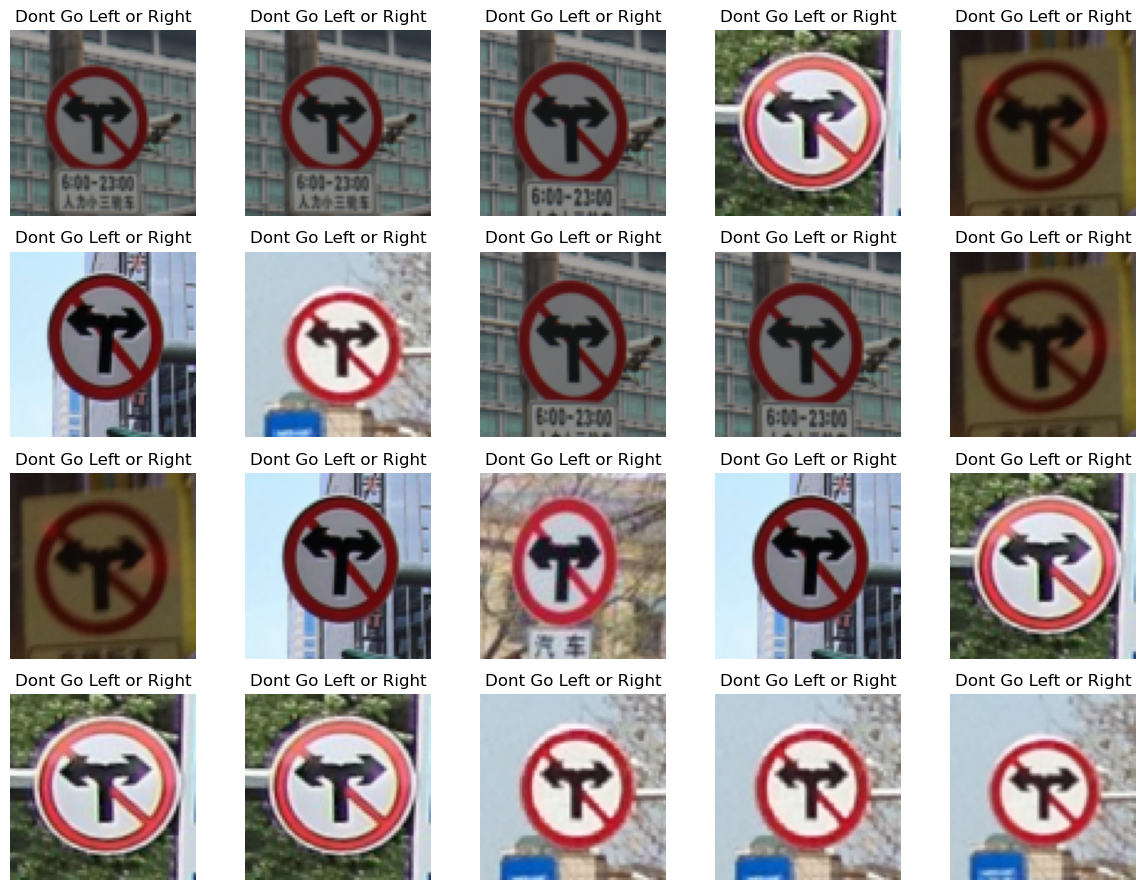

In [7]:
# Plotting Sample Training Images
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(train_datagen)
idx = 0

for i in range(4):
    for j in range(5):
        images, l = next(dataiter)
        img = images
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

### **Preliminary Steps**

i - Check the range of values of the data set

In [8]:
def max_min_values(dataset, type=0):
    max_value = float('-inf')
    min_value = float('inf')

    for batch in dataset:
        if type==0:
            images, _ = batch
        else:
            images = batch
        max_batch = images.max()
        min_batch = images.min()
        if max_batch > max_value:
            max_value = max_batch
        if min_batch < min_value:
            min_value = min_batch
        
    print("Maximum pixel value:", max_value)
    print("Minimum pixel value:", min_value)

In [9]:
# Check if the dataset needs to be normalized
print("Train dataset")
max_min_values(train_datagen) # train
print("Test dataset")
max_min_values(inference_dataset,1) # test

Train dataset
Maximum pixel value: tensor(1.)
Minimum pixel value: tensor(0.)
Test dataset
Maximum pixel value: tensor(1.)
Minimum pixel value: tensor(0.)


ii - Visualization of the distribution of each class

In [10]:
# Plot random images from the dataset
def plot_images(x,y,half=False):
  labels = {0:'12',1:'13',2:'24',3:'37',4:'38',5:'39',6:'44',7:'50',8:'6'}
  
  fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
  
  for i in range(4):
    for j in range(5):
      ind = random.randint(0, np.size(x, 0)-1)
      img = x[ind]
      
      label = the_real_labels[int(labels[y[ind].item()])]
      img_shape = img.shape  # Get the shape of the image

      img = np.transpose(img, (1, 2, 0)) # Transpose dimensions to (height, width, channels)
      
      ax[i, j].set_title(f"{label}")
      ax[i, j].imshow(img)
      ax[i, j].axis("off")
  
  plt.tight_layout()
  plt.show()

In [11]:
def get_class_distribution(dataset, ind=1):
    
    labels = {0:'12',1:'13',2:'24',3:'37',4:'38',5:'39',6:'44',7:'50',8:'6'}
    
    if (ind == 1):
        count_dict = {k:0 for k,v in dataset.class_to_idx.items()} # initialise dictionary
    elif (ind == 2):
        count_dict = {k:0 for k in np.unique(dataset)}
        count_dict = {labels[k]: v for k, v in count_dict.items()} # Convert class indices to corresponding labels
    else:
        count_dict = {label: 0 for label in dataset.dataset.class_to_idx.values()}
    
    #print(count_dict)
    if(ind != 2):
        for input, label in dataset:
            if (ind == 1):
                count_dict[labels[label]] += 1
            else:
                count_dict[label] += 1
    else:
        for label in dataset:
            count_dict[labels[label]] += 1
        
    if (ind==0):
        # Convert class indices to corresponding labels
        count_dict = {labels[k]: v for k, v in count_dict.items()}
    
    print(count_dict)        
    return count_dict

In [12]:
def plot_distribution(dataset, ind=1):
    # visualize the  class distribution
    if(ind == 1):
        plt.figure(figsize=(5, 5))
        sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset,ind)]).melt(), 
                    x = "variable", y="value", hue="variable").set_title('Class Distribution of the dataset')
    elif (ind == 2):
        plt.figure(figsize=(5, 5))
        sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset,ind)]).melt(), 
                    x = "variable", y="value", hue="variable").set_title('Class Distribution of the dataset')
    else:
        fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # Create subplots
        # Plot train set distribution
        sns.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset[0],ind)]).melt(),
                    x="variable", y="value", hue="variable", ax=axes[0]).set_title('Train Set')
        
        # Plot validation set distribution
        sns.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset[1],ind)]).melt(),
                    x="variable", y="value", hue="variable", ax=axes[1]).set_title('Validation Set')
        
        # Plot test set distribution
        sns.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset[2],ind)]).melt(),
                    x="variable", y="value", hue="variable", ax=axes[2]).set_title('Test Set')
        
        plt.suptitle('Datasets Class Distributions')
        plt.tight_layout()
        plt.show()

{'12': 96, '13': 36, '24': 100, '37': 58, '38': 30, '39': 34, '44': 30, '50': 56, '6': 78}


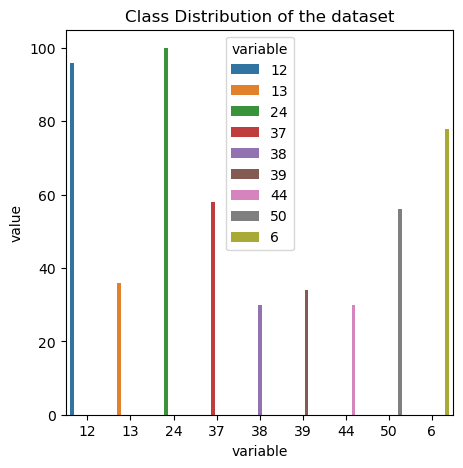

In [13]:
plot_distribution(train_datagen)

In [14]:
# We can see that the data is imbalanced in some classes there are lot of entries and in other there are little entries, that can lead to biased towards the majority class.

# Solutions: Data Augmentation (applying transformations in the images such as rotation, flipping, scaling and cropping)
#            Class Weighting (Giving different weights to the loss function, more weights to the minority classes)
#            Dropout / Undersampling or Oversampling
#            Ensemble Methods

In [15]:
# We can test 2 approaches to compare the results of the models
# Data Oversampling and Class Weighting

In [16]:
# Data Oversampling
def data_oversampling(X,y):
    # Instantiate the RandomOversampler
    ros = RandomOverSampler(random_state=42)

    # Resample the dataset
    X_res, y_res = ros.fit_resample(X, y)
    
    return X_res, y_res

In [17]:
# Class Weighting
def get_weights(y,debug=False):
    class_counts = torch.bincount(y.clone().detach()) # Count the number of samples in each class

    # Calculate the class weights
    total_samples = float(len(y))
    classes_weights = total_samples / (class_counts.float() + 1e-5)  # Add a small epsilon to avoid division by zero (if the class has zero samples)

    if debug:
        print(classes_weights)

    return classes_weights

iii -  Splitting the dataset into Train Validation Test sets

In [18]:
# Split the dataset in a 80/10/10 Ratio
train_size = int(0.8*len(train_datagen))
validation_size = int(0.1*len(train_datagen))
test_size = len(train_datagen) - train_size - validation_size

# Random_split
train_dataset, validation_dataset, test_dataset = random_split(train_datagen, [train_size,validation_size,test_size])

In [19]:
# Creating data loaders for train and validation
train_dataset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataset_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

{'12': 77, '13': 27, '24': 78, '37': 50, '38': 24, '39': 24, '44': 23, '50': 48, '6': 63}
{'12': 9, '13': 2, '24': 9, '37': 6, '38': 2, '39': 4, '44': 5, '50': 5, '6': 9}
{'12': 10, '13': 7, '24': 13, '37': 2, '38': 4, '39': 6, '44': 2, '50': 3, '6': 6}


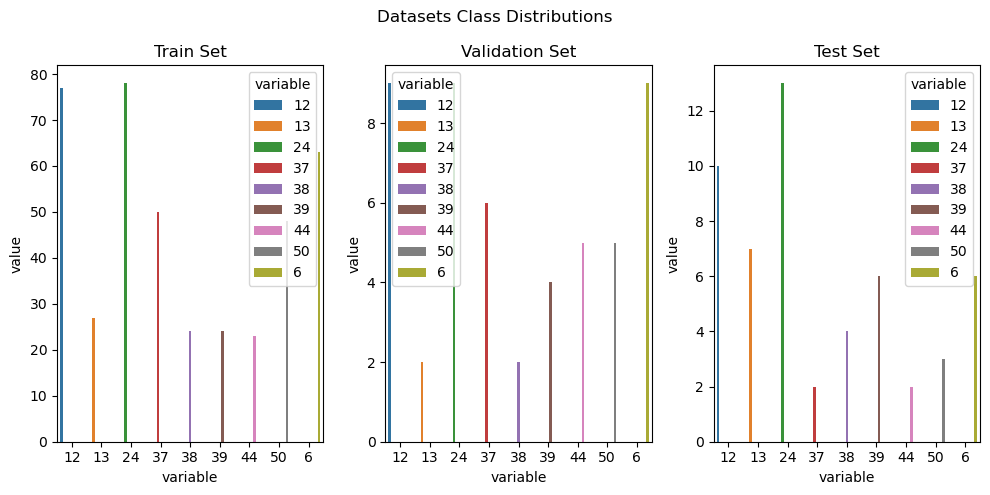

In [20]:
# Checks the distribution for each dataset
plot_distribution([train_dataset, validation_dataset, test_dataset], 0)

In [21]:
# Split the images from the labels in the dataset
def get_x_y(dataset):
    # list to store the images and labels
    x = []
    y = []

    # Iterate over the input to store them into X and Y
    for images, labels in dataset:
        x.append(images)
        y.append(labels)

    # Concatenate the list and transforms into a tensor
    x = torch.cat(x, dim=0)
    y = torch.cat(y, dim=0)

    return x, y

In [22]:
X_train, y_train = get_x_y(train_dataset_loader)
X_val, y_val = get_x_y(validation_dataset_loader)
X_test, y_test = get_x_y(test_dataset_loader)

In [23]:
# DATA OVERSAMPLING #
# flatten the image
X_train_fl = X_train.reshape(X_train.shape[0], -1) # Converts the 3D images to 1D vectors)

# Data Oversampling
X_train_data_ovs, y_train_data_ovs = data_oversampling(X_train_fl,y_train)

# Reshape the data
X_train_data_ovs = X_train_data_ovs.reshape(-1, 3, IMG_HEIGHT, IMG_WIDTH)  # Reshape to original format

print("Oversampling \n- Before:",len(X_train),"\n- After:", len(X_train_data_ovs))

Oversampling 
- Before: 414 
- After: 702


{'12': 78, '13': 78, '24': 78, '37': 78, '38': 78, '39': 78, '44': 78, '50': 78, '6': 78}


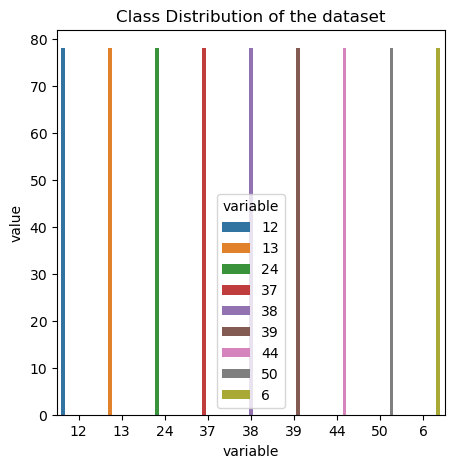

In [24]:
plot_distribution(y_train_data_ovs,2)

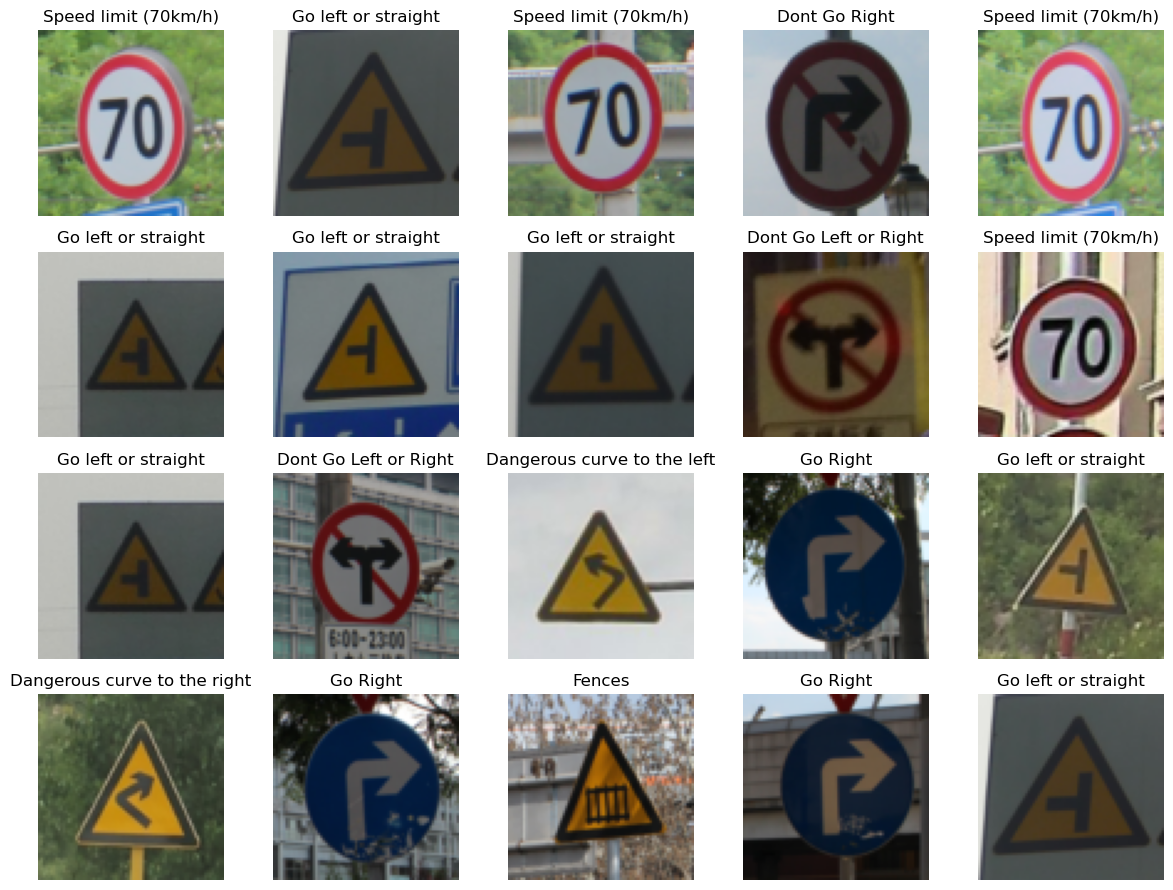

In [25]:
plot_images(X_train_data_ovs,y_train_data_ovs)

### **5. Models**

In [26]:
# Using manual seed to make sure that anyone who re-runs your code will get the exact same outputs. 
torch.manual_seed(42) 

In [27]:
# Check a better way to train the model instead of the CPU
if torch.backends.mps.is_available():
    device = torch.device("mps") # new macbooks
elif torch.cuda.is_available():    
    device = torch.device("cuda") # NVIDIA CUDA
else:
    device = torch.device("cpu")

###### **Save model results Function** 

In [28]:
def test(dataset):
    id = []
    x = []

    for batch, samples in enumerate(dataset):  
        id.append(batch+1)
        x.append(samples)
    
    x = torch.stack(x)
    
    return  id,x
id_kaggle, x_kaggle = test(test_dataset_loader_K)
x_kaggle_fl = x_kaggle.reshape(x_kaggle.shape[0], -1) # Converts the 3D images to 1D vectors)

In [29]:
x_kaggle.shape

torch.Size([310, 1, 3, 75, 75])

In [30]:
x_kaggle_1 = x_kaggle.view(310, 3, 75, 75)
x_kaggle_1.shape

torch.Size([310, 3, 75, 75])

In [31]:
X_train.shape

torch.Size([414, 3, 75, 75])

In [32]:
def save_file(model, id, x, filename, to_device=True):
  # Predict Kaggle results
  model.eval()
  if to_device:
        x = x.to(device)
        model = model.to(device)
        
  with torch.no_grad():
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1) # gets the result with the highest probability
    
  # Convert tensors to numpy arrays
  if to_device:
      predicted = predicted.to("cpu")
  
  # Convert the results into the real id of the classes
  predicted = predicted.numpy()
  
  pred_conv = []     
  for i in range(len(predicted)):
    label = None
    if predicted[i] == 0:
      label = 12
    elif predicted[i] == 1:
      label = 13
    elif predicted[i] == 2:
      label = 24
    elif predicted[i] == 3:
      label = 37
    elif predicted[i] == 4:
      label = 38
    elif predicted[i] == 5:
      label = 39
    elif predicted[i] == 6:
      label = 44
    elif predicted[i] == 7:
      label = 50
    elif predicted[i] == 8:
      label = 6
    
    pred_conv.append(label)

  # Save output
  df=pd.DataFrame({'ID': id, 'Class': pred_conv})
  df.to_csv(filename, index=False)

###### **Model Evatuation Function** 

In [33]:
# accuracy is weak for unbalanced datasets
# overfitting you are remembering the cases of the training data instead of learning from it
def evaluate_network(net, X, y, to_device=True):
    # Set the model to evaluation mode
    net.eval()
    if to_device:
        X = X.to(device)
        net = net.to(device)

    # Run the model on the test data
    with torch.no_grad():
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)

    # Convert tensors to numpy arrays
    if to_device:
        predicted = predicted.to("cpu")
    predicted_np = predicted.numpy()
    test_target_np = y.numpy()

    # Compute confusion matrix and F1 score
    conf_mat = confusion_matrix(test_target_np, predicted_np)
    f1 = f1_score(test_target_np, predicted_np, average='weighted')
    accuracy = accuracy_score(test_target_np, predicted_np)
    precision = precision_score(test_target_np, predicted_np, average='weighted')

    print('Confusion Matrix:\n', conf_mat)
    print('F1 Score: ', f1)
    print('Accuracy: ', accuracy)
    print('Precison: ', precision)
    

###### **Train Function** 

In [34]:
def fit(X_train, y_train, X_val, y_val, nn, criterion, optimizer, n_epochs, to_device=True, batch_size=32, ClassWeights=False, patience=5):
    #send everything to the device (ideally a GPU)
    if to_device:
        nn = nn.to(device)
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        
    if(ClassWeights == True): # In the case of Class Weighting
        class_weights = get_weights(y_train)

    # Train the network
    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []
    
    # Variables to help with the early stopping
    best_val_loss = float('inf')   
    best_model = None              
    epochs_no_improve = 0          # No of epochs with no improvement

    
    for epoch in range(n_epochs):
        nn.train()
        
        train_loss = 0
        train_acc = 0
        n = 0
        for i in range(0, X_train.size(0), batch_size): # the objective of the use of batch is to always improve the classifier in some sets of data
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = nn(X_batch)
                        
            _, predicted = torch.max(outputs.data, 1)
                        
            loss = criterion(outputs, y_batch)
            #accuracy = accuracy_score(y_batch, predicted)
            accuracy = accuracy_score(y_batch.cpu().detach().numpy(), predicted.cpu().detach().numpy())
            
                        
            if ClassWeights == True: # Manually apply class weights
                loss = torch.mean(loss * class_weights)
                
            train_loss += loss.item() 
            train_acc += accuracy          
            
            # Backward and optimize - to improve the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            n+=1
                
        # Calculate the loss and acc values for the validation set
        nn.eval()
        outputs_val = nn(X_val) 
        _, predicted_val = torch.max(outputs_val.data, 1)
                        
        # Loss function
        loss_val = criterion(outputs_val, y_val)
            
        # Accuracy
        accuracy_val = accuracy_score(y_val.cpu().detach().numpy(), predicted_val.cpu().detach().numpy())
            
        # calculate loss and accuracy
        val_loss = loss_val.item()
        val_acc = accuracy_val
            
        # Check for early stopping
        if val_loss < best_val_loss: 
            best_val_loss = val_loss # updates the best value
            best_model = nn.state_dict() # save the current model weights
            epochs_no_improve = 0 # reset the counter
        else:
            epochs_no_improve += 1 # case of no improvement
            
        print ('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, n_epochs, train_loss/n, val_loss, train_acc/n, val_acc))
            
        if epochs_no_improve >= patience: # if the patience value is reached, it stops the training
            print("Early stopping at epoch {}!".format(epoch + 1))
            break
            
        train_loss_values.append(train_loss/n)
        val_loss_values.append(val_loss)   
        train_acc_values.append(train_acc/n)
        val_acc_values.append(val_acc)

    # Load the best model weights
    nn.load_state_dict(best_model)
    
    return [train_loss_values, val_loss_values], [train_acc_values, val_acc_values], nn.to("cpu")

In [35]:
# Flatten the images #
# Train Dataset (With and Without Data Oversampling)
X_train_flattened_ovs = X_train_data_ovs.reshape(X_train_data_ovs.shape[0], -1) #Here we flatten the input 
print(type(X_train_flattened_ovs), X_train_flattened_ovs.shape)

X_train_flattened_ovs = torch.tensor(X_train_flattened_ovs, dtype=torch.float32)
y_train_fl_ovs = torch.tensor(y_train_data_ovs, dtype=torch.long)

X_train_flattened = X_train.reshape(X_train.shape[0], -1) 
print(type(X_train_flattened), X_train_flattened.shape)
 
y_train_fl = y_train.clone().detach()

# Validation Dataset
X_val_flattened = X_val.reshape(X_val.shape[0], -1)
y_val_fl = y_val.clone().detach()

# Test Dataset
X_test_fl = X_test.reshape(X_test.shape[0], -1)
y_test_fl = y_test.clone().detach()

X_train_ovs = torch.tensor(X_train_data_ovs, dtype=torch.float32)
y_train_ovs = torch.tensor(y_train_data_ovs, dtype=torch.long)

<class 'numpy.ndarray'> (702, 16875)
<class 'torch.Tensor'> torch.Size([414, 16875])


In [36]:
# Class weights only for the training set
# Define the loss function with class weights
criterion_CrossEntropy_classWeight = nn.CrossEntropyLoss(weight=get_weights(y_train, True))
criterion_CrossEntropy = nn.CrossEntropyLoss()
criterion_MSE = nn.MSELoss()

tensor([ 5.3766, 15.3333,  5.3077,  8.2800, 17.2500, 17.2500, 18.0000,  8.6250,
         6.5714])


In [37]:
# Define the input variables for the models
n_epochs = 30
n_layers = 3
num_inputs_dos = X_train_flattened_ovs.shape[1]
num_inputs = X_train_flattened.shape[1]

num_classes = int(y_train.max().item() + 1)

In [38]:
def plot_acc_functions(acc_values,labels, title):    
    title = title + 'Accuracy values'
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # Create subplots
    # Plot train set distribution
    axes[0].plot(acc_values[0][0], label='Training Acc')
    axes[0].plot(acc_values[0][1], label='Validation Acc')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(labels[0])
    
    axes[1].plot(acc_values[1][0], label='Training Acc')
    axes[1].plot(acc_values[1][1], label='Validation Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(labels[1])
    
    axes[2].plot(acc_values[2][0], label='Training Acc')
    axes[2].plot(acc_values[2][1], label='Validation Acc')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title(labels[2])
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.legend(loc="lower right")
    plt.show()    

In [39]:
def plot_loss_functions(loss_values,labels, title):    
    title = title + 'loss values'
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # Create subplots
    # Plot train set distribution
    axes[0].plot(loss_values[0][0], label='Training Loss')
    axes[0].plot(loss_values[0][1], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(labels[0])
    
    axes[1].plot(loss_values[1][0], label='Training Loss')
    axes[1].plot(loss_values[1][1], label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(labels[1])
    
    axes[2].plot(loss_values[2][0], label='Training Loss')
    axes[2].plot(loss_values[2][1], label='Validation Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title(labels[2])
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.show()    

In [40]:
def plot_loss_acc_function(loss_values, acc_values,labels):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # Create subplots
    
    axes[0].plot(loss_values[0], label='Training Loss')
    axes[0].plot(loss_values[1], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Values')
    
    axes[1].plot(acc_values[0], label='Training Acc')
    axes[1].plot(acc_values[1], label='Validation Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Acc Value')
    
    plt.suptitle(labels)
    plt.tight_layout()
    plt.legend(loc="lower right")
    plt.show()

In [41]:
def plot_loss_function(loss_values,labels):
    plt.plot(loss_values[0], label='Training Loss')
    plt.plot(loss_values[1], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(labels)
    
    plt.suptitle('MLP Loss Values')
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.show()

In [42]:
def plot_acc_function(acc_values,labels):
    plt.plot(acc_values[0], label='Training Acc')
    plt.plot(acc_values[1], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(labels)
    
    plt.suptitle('MLP Acc Values')
    plt.tight_layout()
    plt.legend(loc="lower right")
    plt.show()

In [43]:
def train_val_model_ev_best_optmizer(model, num_inputs, hidden_layer_sizes, num_classes, X_train, y_train, X_val, y_val, criterion, optimizer, n_epochs, title, ClassWeights=False, patience=7, type='MLP', lr=[0.1,0.01,0.001]):
    
    if type == 'MLP':
        model_1 = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
        model_2 = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
        model_3 = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
    else: # type == 'CNN' 
        model_1 = model(input_channels=num_inputs , num_classes=num_classes)
        model_2 = model(input_channels=num_inputs , num_classes=num_classes)
        model_3 = model(input_channels=num_inputs , num_classes=num_classes)
    
    if optimizer == "RMSprop":
        optimizer1 = optim.RMSprop(model_1.parameters(), lr=lr[0])
        optimizer2 = optim.RMSprop(model_2.parameters(), lr=lr[1])
        optimizer3 = optim.RMSprop(model_3.parameters(), lr=lr[2])
        label_0 = 'lr='+str(lr[0])
        label_1 = 'lr='+str(lr[1])
        label_2 = 'lr='+str(lr[2])
        labels= [label_0,label_1,label_2] 
    elif optimizer == "Adam":
        optimizer1 = optim.Adam(model_1.parameters(), lr=lr[0])
        optimizer2 = optim.Adam(model_2.parameters(), lr=lr[1])
        optimizer3 = optim.Adam(model_3.parameters(), lr=lr[2])
        label_0 = 'lr='+str(lr[0])
        label_1 = 'lr='+str(lr[1])
        label_2 = 'lr='+str(lr[2])
        labels= [label_0,label_1,label_2] 
    elif optimizer == "SGD": 
        optimizer1 = optim.SGD(model_1.parameters(), lr=lr[0], momentum=0.9)
        optimizer2 = optim.SGD(model_2.parameters(), lr=lr[1], momentum=0.9)
        optimizer3 = optim.SGD(model_3.parameters(), lr=lr[2], momentum=0.9)
        label_0 = 'lr='+str(lr[0])+' w/ m=0.9'
        label_1 = 'lr='+str(lr[1])+' w/ m=0.9'
        label_2 = 'lr='+str(lr[2])+' w/ m=0.9'
        labels= [label_0,label_1,label_2] 

    print(title,"w/ ",label_0)
    loss_values_1, acc_values_1, model_1 = fit(X_train, y_train, X_val, y_val, model_1, criterion, optimizer1, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=patience, ClassWeights=ClassWeights)
    loss_values_1 = preprocessing.normalize(loss_values_1)
    
    print(title,"w/ ",label_1)
    loss_values_2, acc_values_2, model_2 = fit(X_train, y_train, X_val, y_val, model_2, criterion, optimizer2, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=patience, ClassWeights=ClassWeights)
    loss_values_2 = preprocessing.normalize(loss_values_2)
    
    print(title,"w/ ",label_2)
    loss_values_3, acc_values_3, model_3 = fit(X_train, y_train, X_val, y_val, model_3, criterion, optimizer3, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=patience, ClassWeights=ClassWeights)
    loss_values_3 = preprocessing.normalize(loss_values_3)
        
    plot_loss_functions([loss_values_1,loss_values_2,loss_values_3],labels,title)
    plot_acc_functions([acc_values_1,acc_values_2,acc_values_3],labels,title)
    
    return [loss_values_1, acc_values_1, model_1],[loss_values_2, acc_values_2, model_2],[loss_values_3, acc_values_3, model_3]

In [44]:
def train_val_model_ev(model, num_inputs, hidden_layer_sizes, num_classes, X_train, y_train, X_val, y_val, criterion, optimizer, n_epochs, title, lr, patience=5, m=0.9, ClassWeights=False):
    
    model = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
     
    if optimizer == "RMSprop":
        optimizer_lr = optim.RMSprop(model.parameters(), lr=lr)
        
    elif optimizer == "Adam":
        optimizer_lr = optim.Adam(model.parameters(), lr=lr)
        
    elif optimizer == "SGD": 
        optimizer_lr = optim.SGD(model.parameters(), lr=lr, momentum=m)
        
    print(title,"w/ lr=", lr)
    loss_values, acc_values, model = fit(X_train, y_train, X_val, y_val, model, criterion, optimizer_lr, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=patience, ClassWeights=ClassWeights)
    loss_values = preprocessing.normalize(loss_values)
    labels= 'lr='+str(lr)
    
    plot_loss_acc_function(loss_values, acc_values, labels)
    
    print('Evaluating with the Training data')
    evaluate_network(model, X_train, y_train)
    
    print('Evaluating with the Validation data')
    evaluate_network(model, X_val, y_val)
    
    return model

In [45]:
def evaluate_model(model_set, X_train, y_train, X_val, y_val, X_test, y_test, labels):
    loss_values = model_set[0]
    acc_values = model_set[1]
    model = model_set[2]
    
    plot_loss_acc_function(loss_values, acc_values, labels)
    
    print('Evaluating with the Training data')
    evaluate_network(model, X_train, y_train)
    
    print('Evaluating with the Validation data')
    evaluate_network(model, X_val, y_val)
    
    print('Evaluating with the Test data')
    evaluate_network(model, X_test, y_test)

In [46]:
def plot_results(labels,train,validation=None,test=None,title=None, n_values=3):
    colors = {'Train': 'lightblue', 'Validation': 'orange', 'Test': 'yellow'}

    if n_values == 3:
        data = pd.DataFrame({
            'Model': labels * 3,
            'Score': train + validation + test,
            'Set': ['Train'] * len(labels) + ['Validation'] * len(labels) + ['Test'] * len(labels)
        })
    else:
        data = pd.DataFrame({
            'Model': labels,
            'Score': train,
            'Set': ['Train'] * len(labels)
        })

    plt.figure(figsize=(12, 8))
    sns.barplot(data=data, x='Model', y='Score', hue='Set', palette=colors)
    plt.axhline(y=1, color='red', linestyle='--', label='Threshold')  # Plot a red line at y=1
    
    for p in plt.gca().patches:
        plt.gca().annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                        textcoords='offset points')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [47]:
def visualize_filters(model, layer_index, figsize=(10, 5)):
    # Get the weights of the specified layer
    if layer_index == 1:
        filters = model.conv1.weight.data  
    elif layer_index ==2:
        model.conv2.weight.data 
    else:
        model.conv3[0].weight.data
    
    # Normalize the weights to visualize them better
    filters = filters - filters.min()
    filters = filters / filters.max()

    # Determine the number of filters in the layer
    num_filters, num_channels, height, width = filters.size()

    # Calculate the number of rows and columns for the subplot grid
    num_cols = 8  # Number of columns for visualization
    num_rows = num_filters // num_cols + 1

    # Create a figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Plot each filter
    for i in range(num_filters):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        filter_data = filters[i].cpu().numpy()
        for channel in range(num_channels):
            ax.imshow(filter_data[channel], cmap='gray')
            ax.axis('off')

    # Hide any remaining empty subplots
    for i in range(num_filters, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

##### **CUDA MEMORY**

In [48]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [125]:
flag_clean_memory = False
if flag_clean_memory == True:
    torch.cuda.empty_cache()

##### **i - Multilayer Perceptron - MLP**

###### **Architecture**

In [272]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes)) # no hidden layer
        else: # case that you have hidden 
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
            self.activations.append(nn.ReLU())        
        
            for i in range(1,len(hidden_sizes)):
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                self.activations.append(nn.ReLU())

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes)) # final hidden layer is linear
    
    def forward(self, x):    
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            if i < len(self.activations): # if the layer have an activation function
                x = self.activations[i](x)
        return x

In [209]:
hidden_layer_sizes_1 = ((num_inputs + num_classes) // 2,)*1
hidden_layer_sizes_1_2 = ((num_inputs + num_classes) // 4,)*1

###### **Data Oversampling RMSprop and CrossEntropy**

In [82]:
print(((num_inputs + num_classes) // 2,)*1)

(8442,)


RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/50], Train Loss: 3970652.2009, Val Loss: 82037.5312, Train Acc: 0.1133, Val Acc: 0.2157
Epoch [2/50], Train Loss: 64326.0753, Val Loss: 35195.8672, Train Acc: 0.2474, Val Acc: 0.2745
Epoch [3/50], Train Loss: 12120.0078, Val Loss: 7284.6938, Train Acc: 0.4237, Val Acc: 0.4510
Epoch [4/50], Train Loss: 19006.1059, Val Loss: 6714.5103, Train Acc: 0.3768, Val Acc: 0.4706
Epoch [5/50], Train Loss: 3489.8574, Val Loss: 5518.2407, Train Acc: 0.5804, Val Acc: 0.6078
Epoch [6/50], Train Loss: 2225.2443, Val Loss: 4233.9077, Train Acc: 0.6468, Val Acc: 0.5686
Epoch [7/50], Train Loss: 2382.0320, Val Loss: 27384.6094, Train Acc: 0.6207, Val Acc: 0.4118
Epoch [8/50], Train Loss: 4416.4477, Val Loss: 1384.0897, Train Acc: 0.5859, Val Acc: 0.7059
Epoch [9/50], Train Loss: 1522.8661, Val Loss: 1522.8197, Train Acc: 0.6901, Val Acc: 0.6863
Epoch [10/50], Train Loss: 707.9044, Val Loss: 600.2037, Train Acc: 0.7487, Val Acc: 0.7255
Epoch [11/50], Train Loss: 

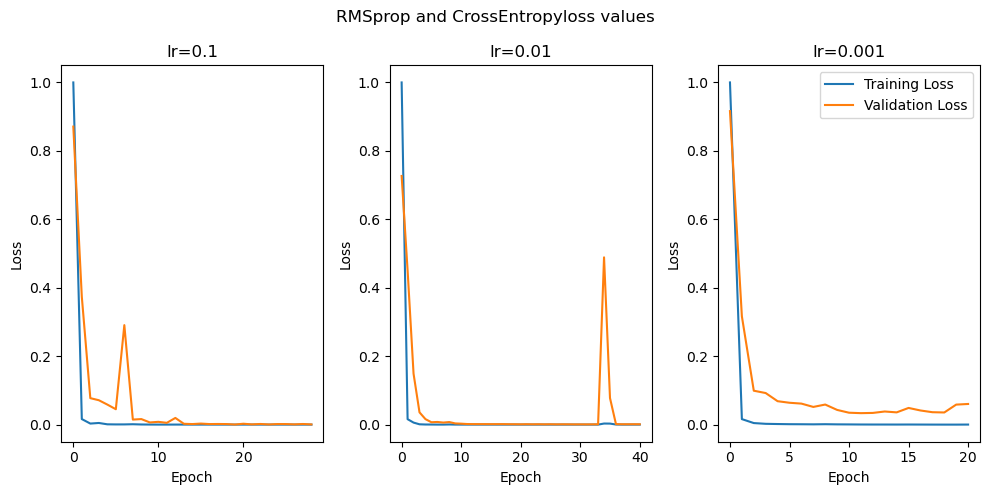

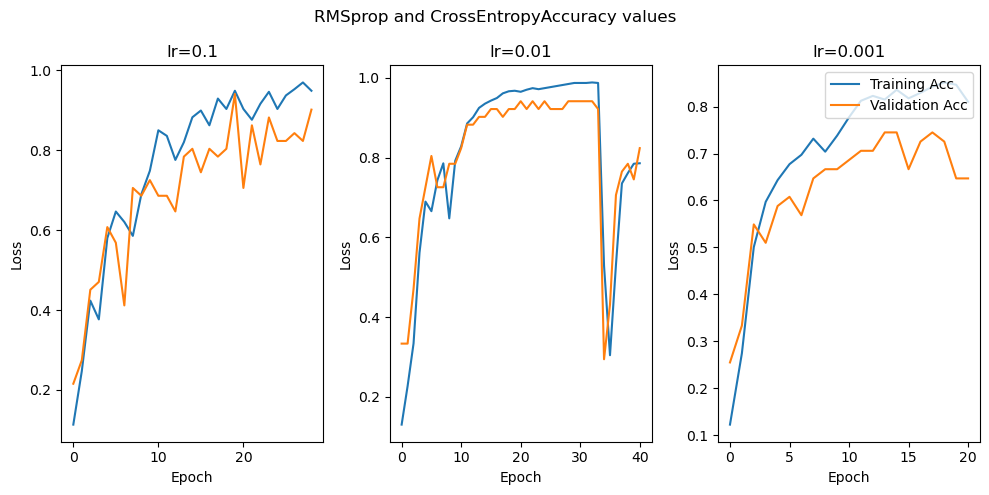

In [42]:
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 50, 'RMSprop and CrossEntropy', patience=10)

RMSprop and CrossEntropy w/ lr= 0.01
Epoch [1/27], Train Loss: 48094.7807, Val Loss: 989.2047, Train Acc: 0.1142, Val Acc: 0.0196
Epoch [2/27], Train Loss: 543.1167, Val Loss: 78.0554, Train Acc: 0.2057, Val Acc: 0.4314
Epoch [3/27], Train Loss: 28.8559, Val Loss: 73.6684, Train Acc: 0.5819, Val Acc: 0.5490
Epoch [4/27], Train Loss: 21.6463, Val Loss: 56.9607, Train Acc: 0.6216, Val Acc: 0.5490
Epoch [5/27], Train Loss: 10.2008, Val Loss: 8.6656, Train Acc: 0.7299, Val Acc: 0.7843
Epoch [6/27], Train Loss: 4.7614, Val Loss: 19.6656, Train Acc: 0.7491, Val Acc: 0.6471
Epoch [7/27], Train Loss: 6.7654, Val Loss: 24.7878, Train Acc: 0.7363, Val Acc: 0.7059
Epoch [8/27], Train Loss: 5.2435, Val Loss: 4.8500, Train Acc: 0.7997, Val Acc: 0.8431
Epoch [9/27], Train Loss: 0.6730, Val Loss: 6.2763, Train Acc: 0.8843, Val Acc: 0.7451
Epoch [10/27], Train Loss: 0.6373, Val Loss: 3.6688, Train Acc: 0.8949, Val Acc: 0.8039
Epoch [11/27], Train Loss: 0.3024, Val Loss: 3.5265, Train Acc: 0.9332, Val 

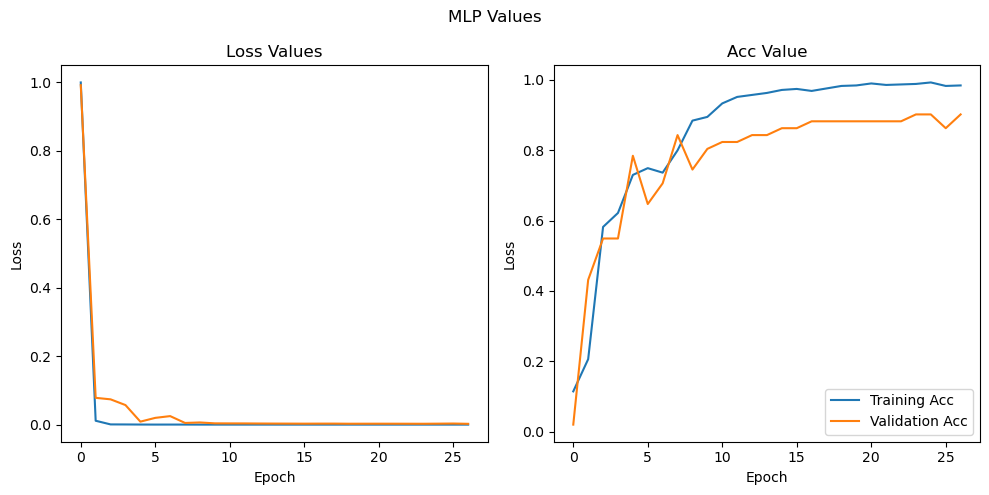

Evaluating with the Training data
Confusion Matrix:
 [[76  0  0  0  0  0  0  0  0]
 [ 0 76  0  0  0  0  0  0  0]
 [ 0  0 76  0  0  0  0  0  0]
 [ 0  0  0 67  2  7  0  0  0]
 [ 0  0  0  0 76  0  0  0  0]
 [ 0  0  0  0  0 76  0  0  0]
 [ 0  0  0  0  0  0 76  0  0]
 [ 0  0  0  0  0  0  0 76  0]
 [ 0  0  0  0  0  0  0  0 76]]
F1 Score:  0.9866723074270245
Accuracy:  0.9868421052631579
Precison:  0.9877801805512648
Evaluating with the Validation data
Confusion Matrix:
 [[ 8  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  1  0  0  0]
 [ 0  0  0  5  1  2  0  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9191335756800653
Accuracy:  0.9019607843137255
Precison:  0.9558823529411765
Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  2]
 [ 0  0 11  0  0  1  0  0  0]
 [ 0  0  0  5  1  0  0  0  0]
 

In [84]:
# lr = 0.01
model_rms_ce_dos_2 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 27, 'RMSprop and CrossEntropy',0.01, patience=10)
print('Evaluating with the Test data')
evaluate_network(model_rms_ce_dos_2, X_test_fl, y_test_fl)

(4221,)
RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/50], Train Loss: 2066280.0090, Val Loss: 118887.2812, Train Acc: 0.1224, Val Acc: 0.0784
Epoch [2/50], Train Loss: 39860.7269, Val Loss: 29351.4785, Train Acc: 0.2891, Val Acc: 0.3333
Epoch [3/50], Train Loss: 12358.9737, Val Loss: 5579.6313, Train Acc: 0.3626, Val Acc: 0.4706
Epoch [4/50], Train Loss: 3465.7075, Val Loss: 13963.4199, Train Acc: 0.4307, Val Acc: 0.3529
Epoch [5/50], Train Loss: 3358.1820, Val Loss: 4198.5273, Train Acc: 0.4669, Val Acc: 0.4902
Epoch [6/50], Train Loss: 898.7922, Val Loss: 1365.5300, Train Acc: 0.5983, Val Acc: 0.5490
Epoch [7/50], Train Loss: 641.1617, Val Loss: 671.8296, Train Acc: 0.6450, Val Acc: 0.4902
Epoch [8/50], Train Loss: 270.5321, Val Loss: 399.4708, Train Acc: 0.6104, Val Acc: 0.6078
Epoch [9/50], Train Loss: 163.0174, Val Loss: 69.9440, Train Acc: 0.6707, Val Acc: 0.6078
Epoch [10/50], Train Loss: 86.9021, Val Loss: 10.0297, Train Acc: 0.6087, Val Acc: 0.7059
Epoch [11/50], Train Loss: 4.

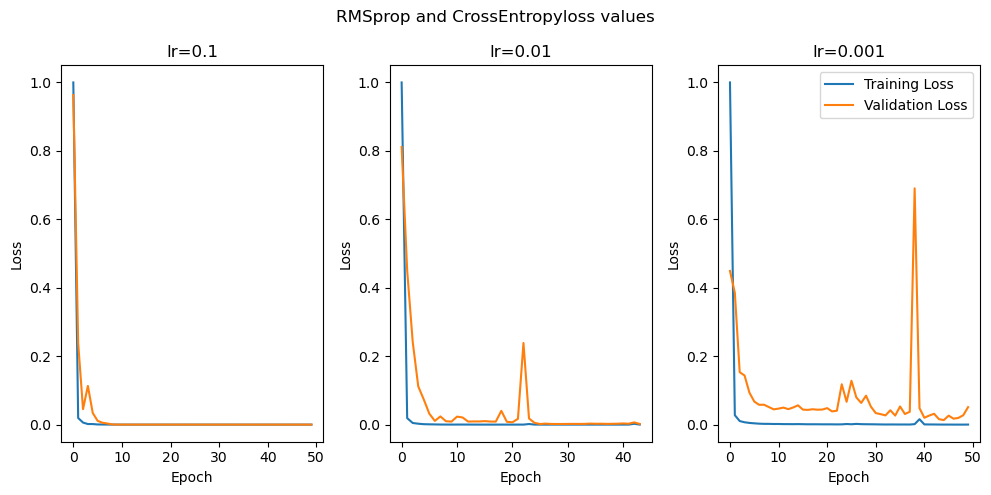

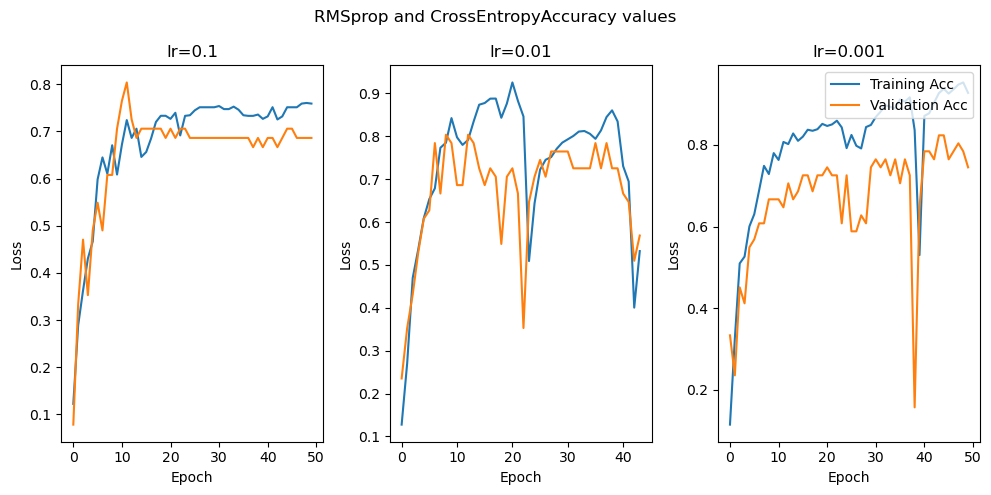

In [55]:
print(((num_inputs + num_classes) // 4,)*1)
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_1_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 50, 'RMSprop and CrossEntropy', patience=15)

RMSprop and CrossEntropy w/ lr= 0.1
Epoch [1/30], Train Loss: 2299684.5031, Val Loss: 56984.4102, Train Acc: 0.1369, Val Acc: 0.2157
Epoch [2/30], Train Loss: 36491.9439, Val Loss: 17185.4648, Train Acc: 0.1796, Val Acc: 0.3137
Epoch [3/30], Train Loss: 6226.9739, Val Loss: 4266.0293, Train Acc: 0.3506, Val Acc: 0.4510
Epoch [4/30], Train Loss: 1170.1517, Val Loss: 480.9512, Train Acc: 0.5567, Val Acc: 0.7059
Epoch [5/30], Train Loss: 119.6490, Val Loss: 333.7867, Train Acc: 0.7837, Val Acc: 0.7255
Epoch [6/30], Train Loss: 168.8450, Val Loss: 260.5649, Train Acc: 0.7264, Val Acc: 0.7255
Epoch [7/30], Train Loss: 80.7124, Val Loss: 136.0235, Train Acc: 0.7938, Val Acc: 0.7843
Epoch [8/30], Train Loss: 39.8283, Val Loss: 65.4156, Train Acc: 0.8587, Val Acc: 0.8824
Epoch [9/30], Train Loss: 109.9660, Val Loss: 399.8999, Train Acc: 0.7747, Val Acc: 0.7451
Epoch [10/30], Train Loss: 54.0941, Val Loss: 100.5419, Train Acc: 0.8631, Val Acc: 0.8627
Epoch [11/30], Train Loss: 41.1438, Val Loss

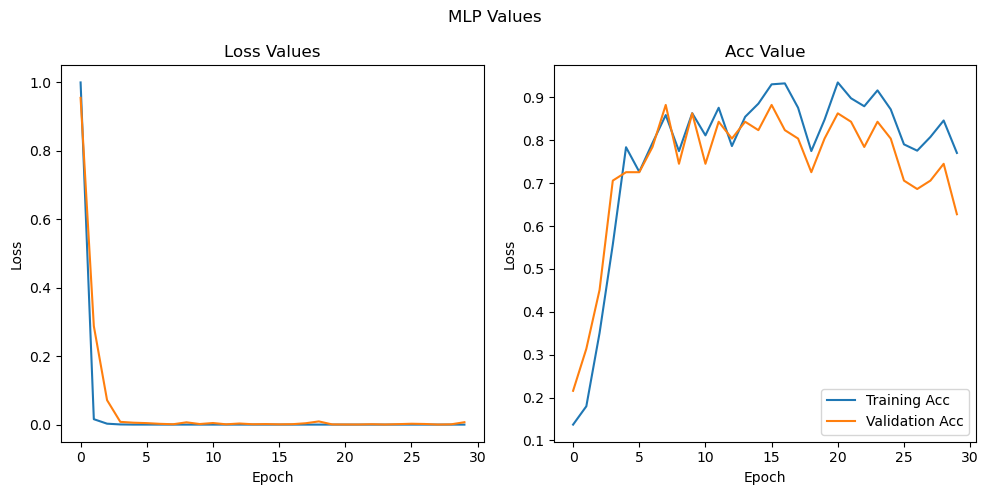

Evaluating with the Training data
Confusion Matrix:
 [[41 12  0  0  0  0 12 11  0]
 [ 0 76  0  0  0  0  0  0  0]
 [ 0  0 71  0  0  0  1  0  4]
 [ 0  0  0 38  0  2  0 36  0]
 [ 0 14  0  0  0  0  8 54  0]
 [ 0  0  0  0  0  0  0 76  0]
 [ 0  6  0  0  0  0  2 68  0]
 [ 0  0  0  0  0  0  0 76  0]
 [ 0 17  0  0  0  0 17  8 34]]
F1 Score:  0.4551121440242224
Accuracy:  0.49415204678362573
Precison:  0.5315266535132156
Evaluating with the Validation data
Confusion Matrix:
 [[ 5  1  0  0  0  0  0  2  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  1  0  2]
 [ 0  0  0  3  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  2  0  0  0  0  1  0  4]]
F1 Score:  0.6425490668898377
Accuracy:  0.6274509803921569
Precison:  0.7679738562091503
Evaluating with the Test data
Confusion Matrix:
 [[6 1 0 0 0 0 4 1 0]
 [0 4 0 0 0 0 2 0 0]
 [0 0 9 0 0 0 0 0 3]
 [0 0 0 1 0 1 0 4 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0

c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
# lr = 0.1
model_rms_ce_dos_21 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 30, 'RMSprop and CrossEntropy',0.1, patience=15)
print('Evaluating with the Test data')
evaluate_network(model_rms_ce_dos_21, X_test_fl, y_test_fl)

(8442, 8442)
RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 1991308962.9747, Val Loss: 1904914.3750, Train Acc: 0.1289, Val Acc: 0.1176
Epoch [2/30], Train Loss: 22165988.5339, Val Loss: 126695.1797, Train Acc: 0.1735, Val Acc: 0.1765
Epoch [3/30], Train Loss: 154686.3483, Val Loss: 19401.7188, Train Acc: 0.2182, Val Acc: 0.2941
Epoch [4/30], Train Loss: 11382.2115, Val Loss: 3544.6094, Train Acc: 0.2422, Val Acc: 0.2745
Epoch [5/30], Train Loss: 3328.5672, Val Loss: 68.2967, Train Acc: 0.2562, Val Acc: 0.3529
Epoch [6/30], Train Loss: 5599834.3210, Val Loss: 26170.6738, Train Acc: 0.3402, Val Acc: 0.2549
Epoch [7/30], Train Loss: 6742.1668, Val Loss: 3744.7588, Train Acc: 0.3019, Val Acc: 0.2549
Epoch [8/30], Train Loss: 1376.8487, Val Loss: 1795.2950, Train Acc: 0.3870, Val Acc: 0.3333
Epoch [9/30], Train Loss: 1105.9938, Val Loss: 392.5328, Train Acc: 0.3581, Val Acc: 0.3333
Epoch [10/30], Train Loss: 436.9119, Val Loss: 96.0593, Train Acc: 0.3106, Val Acc: 0.3725
Epoc

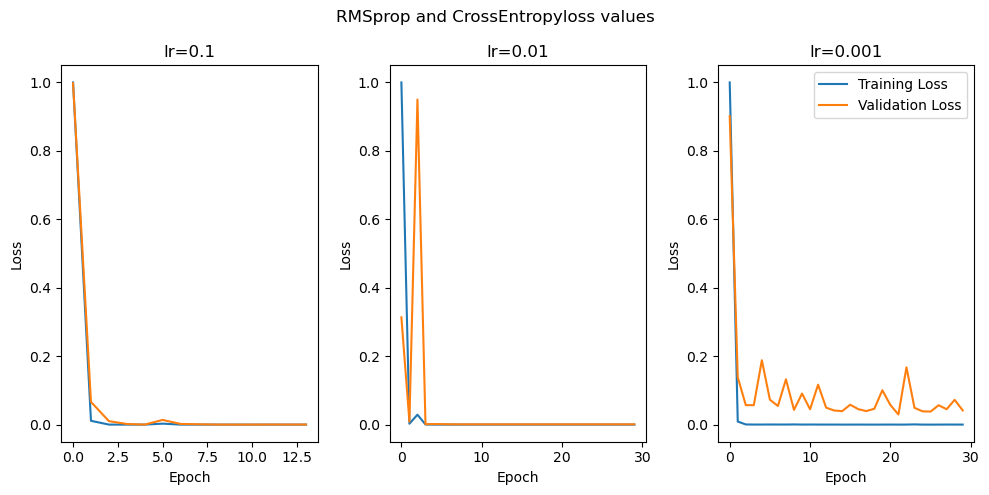

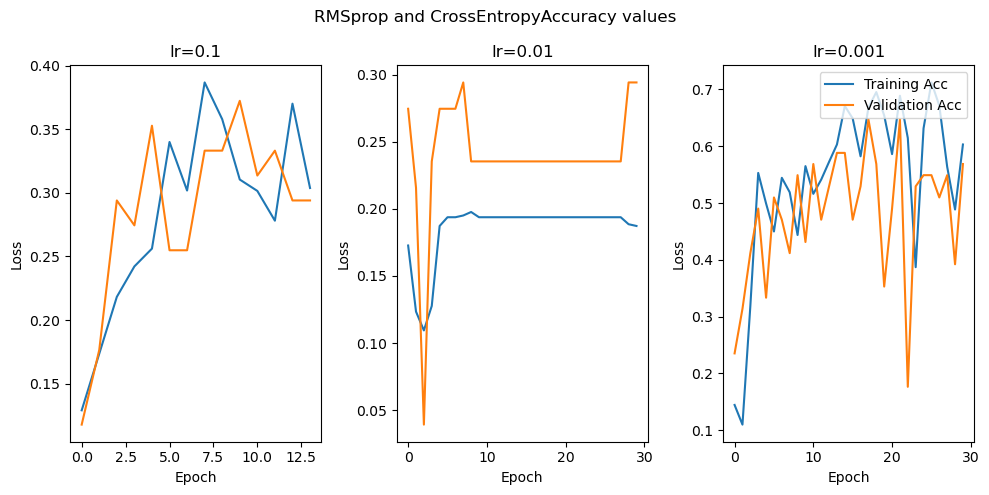

In [76]:
hidden_layer_sizes_2 = ((num_inputs + num_classes) // 2,)*2
print(hidden_layer_sizes_2)
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 30, 'RMSprop and CrossEntropy', patience=10)

###### **Class Weighting RMSprop and CrossEntropy**

RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 101106320.1352, Val Loss: 1907600.1250, Train Acc: 0.0991, Val Acc: 0.0980
Epoch [2/30], Train Loss: 7240286.3036, Val Loss: 82357.3984, Train Acc: 0.1622, Val Acc: 0.4314
Epoch [3/30], Train Loss: 857723.0759, Val Loss: 16943.4766, Train Acc: 0.3057, Val Acc: 0.5294
Epoch [4/30], Train Loss: 153504.3069, Val Loss: 2215.7285, Train Acc: 0.4932, Val Acc: 0.7059
Epoch [5/30], Train Loss: 19969.9200, Val Loss: 1533.0754, Train Acc: 0.6762, Val Acc: 0.7647
Epoch [6/30], Train Loss: 9631.5851, Val Loss: 1802.3812, Train Acc: 0.7527, Val Acc: 0.7059
Epoch [7/30], Train Loss: 6002.9265, Val Loss: 790.8915, Train Acc: 0.8152, Val Acc: 0.8039
Epoch [8/30], Train Loss: 2502.4273, Val Loss: 974.4769, Train Acc: 0.8674, Val Acc: 0.7451
Epoch [9/30], Train Loss: 3704.5284, Val Loss: 665.5875, Train Acc: 0.8473, Val Acc: 0.7647
Epoch [10/30], Train Loss: 2726.7443, Val Loss: 252.3208, Train Acc: 0.8509, Val Acc: 0.8235
Epoch [11/30], Train

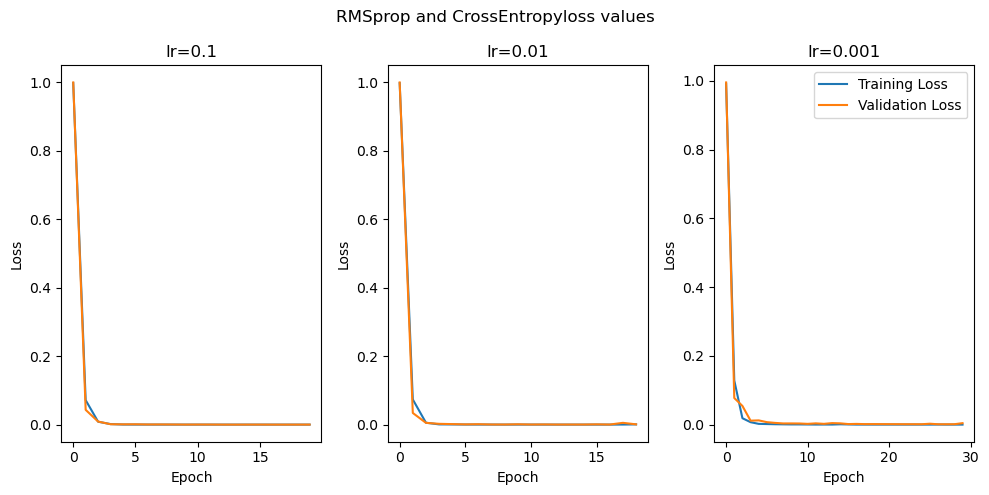

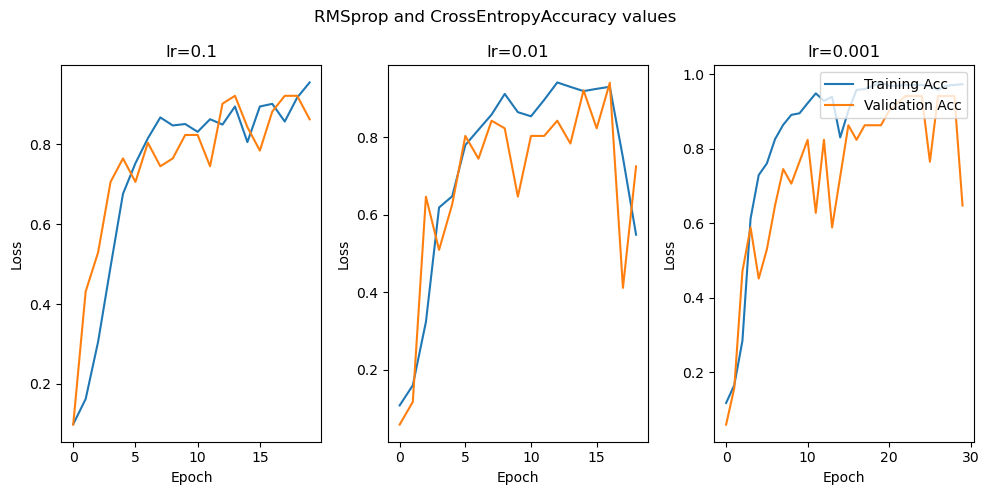

In [85]:
# With hidden layer 1
train_val_model_ev_best_optmizer(MLP, num_inputs, hidden_layer_sizes_1, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy', ClassWeights=True)

RMSprop and CrossEntropy w/ lr= 0.1
Epoch [1/30], Train Loss: 91586235.9596, Val Loss: 3608005.7500, Train Acc: 0.1125, Val Acc: 0.0392
Epoch [2/30], Train Loss: 10178153.6429, Val Loss: 343006.4375, Train Acc: 0.1278, Val Acc: 0.1569
Epoch [3/30], Train Loss: 1356861.0357, Val Loss: 15201.0928, Train Acc: 0.3141, Val Acc: 0.6863
Epoch [4/30], Train Loss: 202829.5011, Val Loss: 7473.9863, Train Acc: 0.5251, Val Acc: 0.6471
Epoch [5/30], Train Loss: 83575.7355, Val Loss: 2879.6160, Train Acc: 0.6415, Val Acc: 0.7255
Epoch [6/30], Train Loss: 33327.6906, Val Loss: 13761.7246, Train Acc: 0.7146, Val Acc: 0.5294
Epoch [7/30], Train Loss: 84810.2140, Val Loss: 2328.0264, Train Acc: 0.5850, Val Acc: 0.7843
Epoch [8/30], Train Loss: 18634.3914, Val Loss: 3010.8259, Train Acc: 0.7643, Val Acc: 0.8039
Epoch [9/30], Train Loss: 16579.0515, Val Loss: 806.2996, Train Acc: 0.8177, Val Acc: 0.8824
Epoch [10/30], Train Loss: 7343.1317, Val Loss: 76.1917, Train Acc: 0.8496, Val Acc: 0.9608
Epoch [11/3

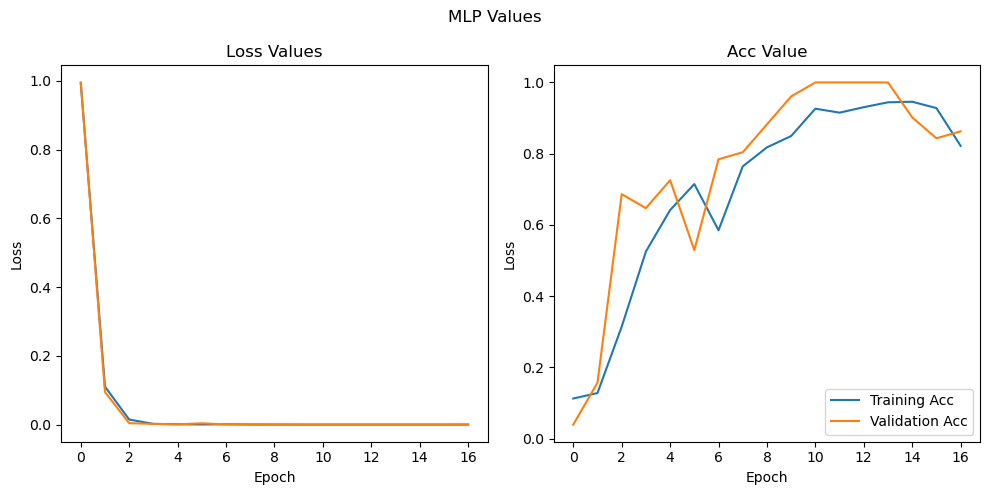

Evaluating with the Training data
Confusion Matrix:
 [[54  0  0  0  0  0  5  0 15]
 [ 0 27  0  0  0  0  0  0  2]
 [ 0  0 82  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  4  0  0]
 [ 0  0  0  2 20  2  3  0  0]
 [ 0  0  0  2  0 17 10  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0 10 10 20  0]
 [ 0  0  0  0  0  0  0  0 63]]
F1 Score:  0.8463184712895627
Accuracy:  0.8429951690821256
Precison:  0.892944847020934
Evaluating with the Validation data
Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  1]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  4  1  2  0]
 [ 0  0  0  0  0  0  0  0  8]]
F1 Score:  0.873997180571575
Accuracy:  0.8823529411764706
Precison:  0.9433551198257081
Evaluating with the Test data
Confusion Matrix:
 [[8 0 0 0 0 0 1 0 3]
 [0 4 0 0 0 0 0 0 1]
 [0 0 7 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 2 0 

c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
# lr = 0.1
model_rms_ce_cw = train_val_model_ev(MLP, num_inputs, hidden_layer_sizes_1, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy',0.1, ClassWeights=True)
print('Evaluating with the Test data')
evaluate_network(model_rms_ce_cw, X_test_fl, y_test_fl)

RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 53871452.6413, Val Loss: 1504209.2500, Train Acc: 0.0991, Val Acc: 0.2157
Epoch [2/30], Train Loss: 5415707.6786, Val Loss: 162437.8438, Train Acc: 0.0985, Val Acc: 0.0980
Epoch [3/30], Train Loss: 717302.6696, Val Loss: 13526.6270, Train Acc: 0.2198, Val Acc: 0.6078
Epoch [4/30], Train Loss: 152368.1741, Val Loss: 10625.3125, Train Acc: 0.4216, Val Acc: 0.4118
Epoch [5/30], Train Loss: 75132.1392, Val Loss: 2305.2510, Train Acc: 0.5811, Val Acc: 0.7451
Epoch [6/30], Train Loss: 34854.5347, Val Loss: 6155.3955, Train Acc: 0.6634, Val Acc: 0.5882
Epoch [7/30], Train Loss: 46869.7550, Val Loss: 4598.1392, Train Acc: 0.5939, Val Acc: 0.6471
Epoch [8/30], Train Loss: 30760.7280, Val Loss: 1596.7858, Train Acc: 0.6988, Val Acc: 0.6667
Epoch [9/30], Train Loss: 25149.2411, Val Loss: 3166.3303, Train Acc: 0.6778, Val Acc: 0.7255
Epoch [10/30], Train Loss: 10761.8710, Val Loss: 945.2234, Train Acc: 0.8314, Val Acc: 0.8039
Epoch [11/3

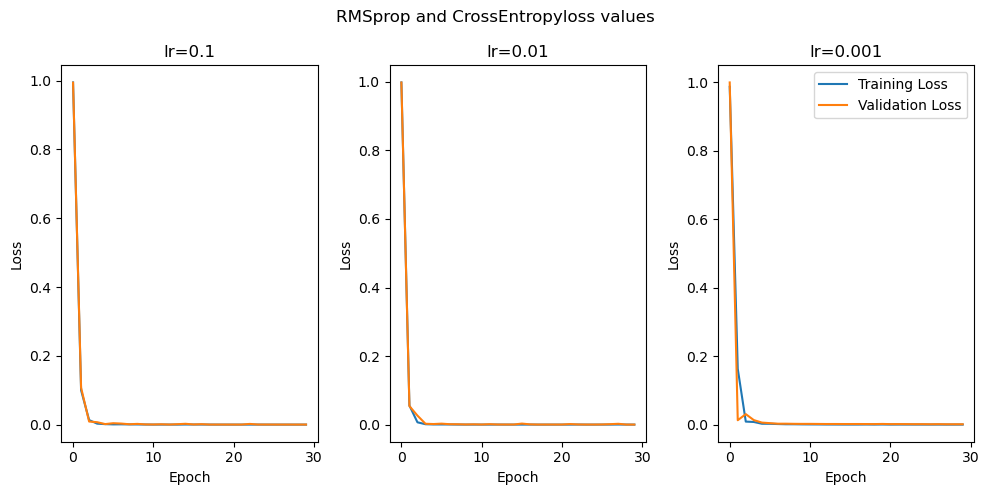

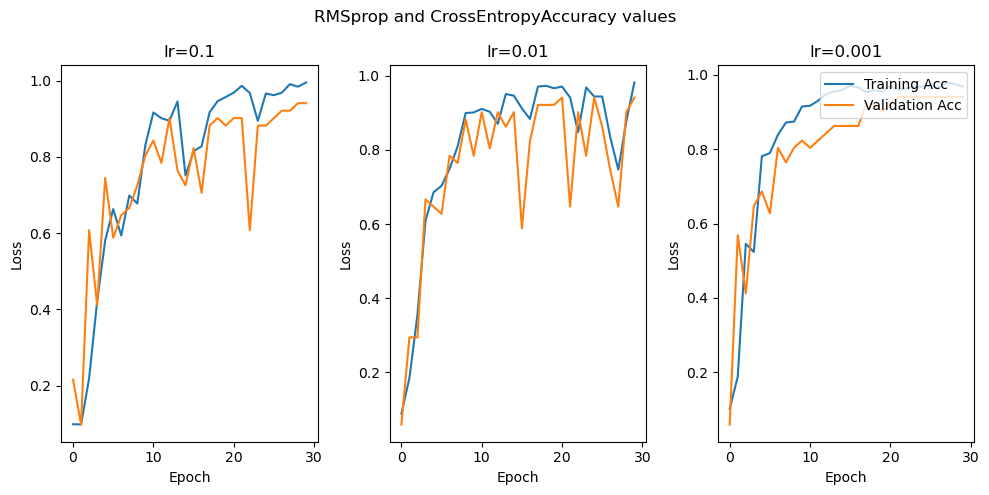

In [86]:
# With hidden layer 2
train_val_model_ev_best_optmizer(MLP, num_inputs, hidden_layer_sizes_1_2, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy', ClassWeights=True)

RMSprop and CrossEntropy w/ lr= 0.001
Epoch [1/30], Train Loss: 4932.1004, Val Loss: 361.6419, Train Acc: 0.1644, Val Acc: 0.0392
Epoch [2/30], Train Loss: 1130.4394, Val Loss: 61.3422, Train Acc: 0.1999, Val Acc: 0.0392
Epoch [3/30], Train Loss: 174.7132, Val Loss: 3.3665, Train Acc: 0.3165, Val Acc: 0.7647
Epoch [4/30], Train Loss: 25.1787, Val Loss: 0.7399, Train Acc: 0.6762, Val Acc: 0.9020
Epoch [5/30], Train Loss: 6.1509, Val Loss: 1.2335, Train Acc: 0.8621, Val Acc: 0.7255
Epoch [6/30], Train Loss: 9.1721, Val Loss: 0.7572, Train Acc: 0.7929, Val Acc: 0.8431
Epoch [7/30], Train Loss: 6.6452, Val Loss: 1.0425, Train Acc: 0.8598, Val Acc: 0.7451
Epoch [8/30], Train Loss: 5.2639, Val Loss: 0.3413, Train Acc: 0.8929, Val Acc: 0.9020
Epoch [9/30], Train Loss: 4.0004, Val Loss: 0.3366, Train Acc: 0.9216, Val Acc: 0.9020
Epoch [10/30], Train Loss: 3.7153, Val Loss: 0.2621, Train Acc: 0.9238, Val Acc: 0.9412
Epoch [11/30], Train Loss: 3.5275, Val Loss: 0.2212, Train Acc: 0.9353, Val Acc

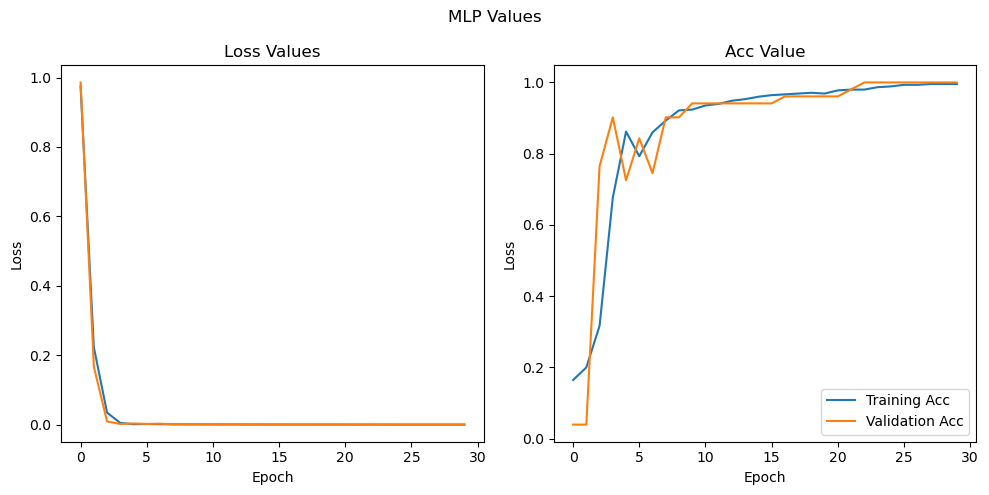

Evaluating with the Training data
Confusion Matrix:
 [[74  0  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0  0]
 [ 0  0 82  0  0  0  0  0  0]
 [ 0  0  0 42  0  0  0  0  0]
 [ 0  0  0  0 24  1  2  0  0]
 [ 0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0  0 40  0]
 [ 0  0  0  0  0  0  0  0 63]]
F1 Score:  0.9926442561371358
Accuracy:  0.9927536231884058
Precison:  0.9931561996779387
Evaluating with the Validation data
Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  8]]
F1 Score:  1.0
Accuracy:  1.0
Precison:  1.0
Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  3  0  0]
 [ 0

c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
# lr = 0.001
model_rms_ce_cw_2 = train_val_model_ev(MLP, num_inputs, hidden_layer_sizes_1_2, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy',0.001, ClassWeights=True)
print('Evaluating with the Test data')
evaluate_network(model_rms_ce_cw_2, X_test_fl, y_test_fl)

###### **Data Oversampling Adam and CrossEntropy**

Adam and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 54471.8538, Val Loss: 3756.1514, Train Acc: 0.0755, Val Acc: 0.1373
Epoch [2/30], Train Loss: 1553.5794, Val Loss: 1498.9645, Train Acc: 0.2126, Val Acc: 0.0784
Epoch [3/30], Train Loss: 1063.2121, Val Loss: 329.9958, Train Acc: 0.1636, Val Acc: 0.3529
Epoch [4/30], Train Loss: 134.4000, Val Loss: 3.5118, Train Acc: 0.2383, Val Acc: 0.2353
Epoch [5/30], Train Loss: 2.4225, Val Loss: 1.7601, Train Acc: 0.2188, Val Acc: 0.2353
Epoch [6/30], Train Loss: 1.9540, Val Loss: 1.7459, Train Acc: 0.2031, Val Acc: 0.2353
Epoch [7/30], Train Loss: 1.9275, Val Loss: 1.7408, Train Acc: 0.1484, Val Acc: 0.2941
Epoch [8/30], Train Loss: 2.0193, Val Loss: 1.7572, Train Acc: 0.2310, Val Acc: 0.2745
Epoch [9/30], Train Loss: 1.9387, Val Loss: 1.7548, Train Acc: 0.2232, Val Acc: 0.2745
Epoch [10/30], Train Loss: 1.9384, Val Loss: 1.7496, Train Acc: 0.2232, Val Acc: 0.2941
Epoch [11/30], Train Loss: 1.9381, Val Loss: 1.7451, Train Acc: 0.2245, Val A

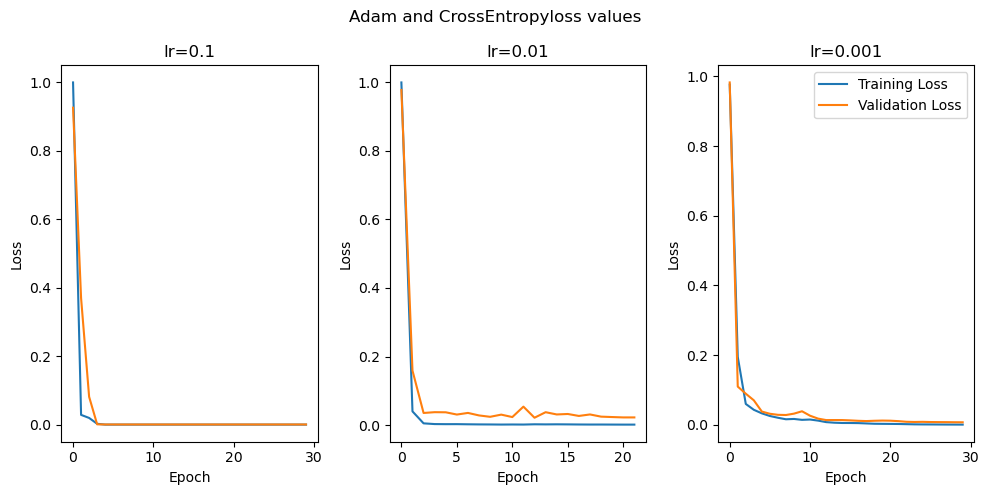

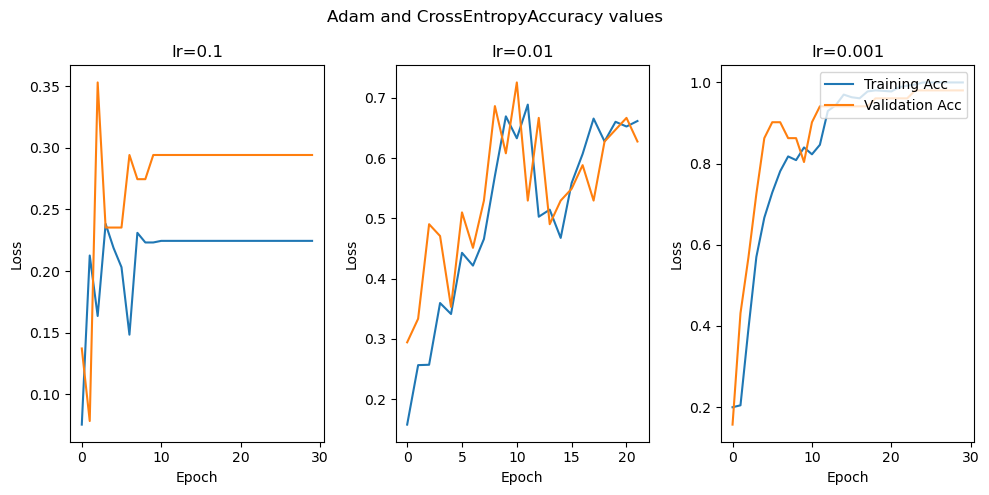

In [80]:
# Hidden layer size 1
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'Adam', n_epochs, 'Adam and CrossEntropy', patience=10)

Adam and CrossEntropy w/ lr= 0.001
Epoch [1/22], Train Loss: 29.6262, Val Loss: 12.0017, Train Acc: 0.2266, Val Acc: 0.2353
Epoch [2/22], Train Loss: 4.7035, Val Loss: 2.7446, Train Acc: 0.2498, Val Acc: 0.1569
Epoch [3/22], Train Loss: 2.7633, Val Loss: 2.0491, Train Acc: 0.2812, Val Acc: 0.3529
Epoch [4/22], Train Loss: 1.8442, Val Loss: 1.3144, Train Acc: 0.3605, Val Acc: 0.4314
Epoch [5/22], Train Loss: 1.4099, Val Loss: 0.7600, Train Acc: 0.4694, Val Acc: 0.7451
Epoch [6/22], Train Loss: 0.9588, Val Loss: 0.6789, Train Acc: 0.6831, Val Acc: 0.7843
Epoch [7/22], Train Loss: 0.8303, Val Loss: 0.7158, Train Acc: 0.6896, Val Acc: 0.7451
Epoch [8/22], Train Loss: 0.6777, Val Loss: 0.4904, Train Acc: 0.7853, Val Acc: 0.9020
Epoch [9/22], Train Loss: 0.5287, Val Loss: 0.3650, Train Acc: 0.8400, Val Acc: 0.9216
Epoch [10/22], Train Loss: 0.4059, Val Loss: 0.3352, Train Acc: 0.8841, Val Acc: 0.9020
Epoch [11/22], Train Loss: 0.3816, Val Loss: 0.2595, Train Acc: 0.8750, Val Acc: 0.9216
Epoc

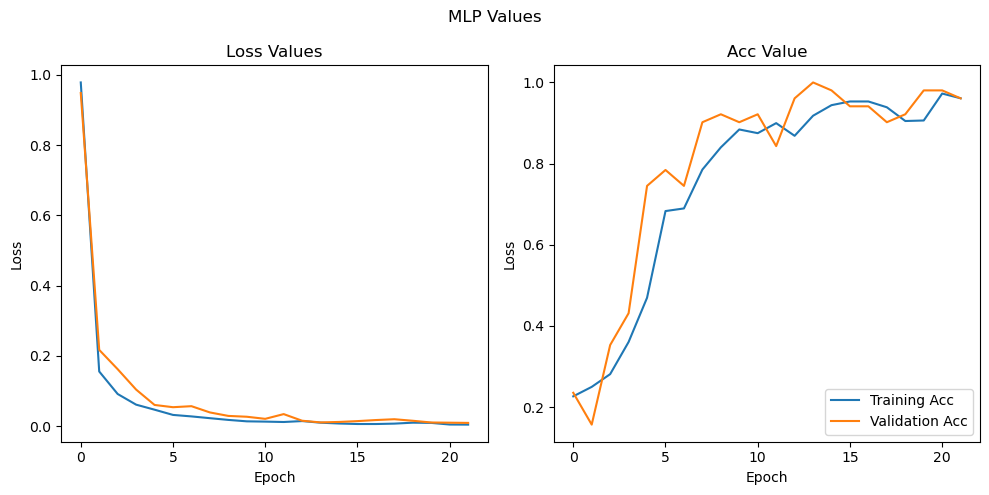

Evaluating with the Training data
Confusion Matrix:
 [[82  0  0  0  0  0  0  0  0]
 [ 0 82  0  0  0  0  0  0  0]
 [ 0  0 82  0  0  0  0  0  0]
 [ 0  0  0 71  3  8  0  0  0]
 [ 0  0  0  0 82  0  0  0  0]
 [ 0  0  0  0  0 82  0  0  0]
 [ 0  0  0  0  0  1 81  0  0]
 [ 0  0  0  0  0  0  0 82  0]
 [ 0  0  0  0  0  0  0  0 82]]
F1 Score:  0.9835536013994083
Accuracy:  0.983739837398374
Precison:  0.9850894203835381
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  7  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  4  0  0]
 [ 0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  5]]
F1 Score:  0.9688453159041395
Accuracy:  0.9607843137254902
Precison:  0.9869281045751634
Evaluating with the Test data
Confusion Matrix:
 [[6 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 4 0 0

In [49]:
# lr = 0.001
model_adam_ce_dos = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'Adam', 22, 'Adam and CrossEntropy',0.001, patience=10)
print('Evaluating with the Test data')
evaluate_network(model_adam_ce_dos, X_test_fl, y_test_fl)

Adam and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 28267.8298, Val Loss: 1805.0988, Train Acc: 0.1003, Val Acc: 0.1569
Epoch [2/30], Train Loss: 1154.8411, Val Loss: 835.5029, Train Acc: 0.2469, Val Acc: 0.0588
Epoch [3/30], Train Loss: 273.9740, Val Loss: 69.9228, Train Acc: 0.1949, Val Acc: 0.4118
Epoch [4/30], Train Loss: 15.3706, Val Loss: 2.4739, Train Acc: 0.2339, Val Acc: 0.0784
Epoch [5/30], Train Loss: 2.2473, Val Loss: 2.3837, Train Acc: 0.1396, Val Acc: 0.0588
Epoch [6/30], Train Loss: 2.2460, Val Loss: 2.2819, Train Acc: 0.1357, Val Acc: 0.0588
Epoch [7/30], Train Loss: 2.2053, Val Loss: 2.2248, Train Acc: 0.1357, Val Acc: 0.0588
Epoch [8/30], Train Loss: 2.1857, Val Loss: 2.2038, Train Acc: 0.1357, Val Acc: 0.0588
Epoch [9/30], Train Loss: 2.1789, Val Loss: 2.2005, Train Acc: 0.1357, Val Acc: 0.0588
Epoch [10/30], Train Loss: 2.1776, Val Loss: 2.2025, Train Acc: 0.1110, Val Acc: 0.0588
Epoch [11/30], Train Loss: 2.1779, Val Loss: 2.2045, Train Acc: 0.1110, Val Acc: 

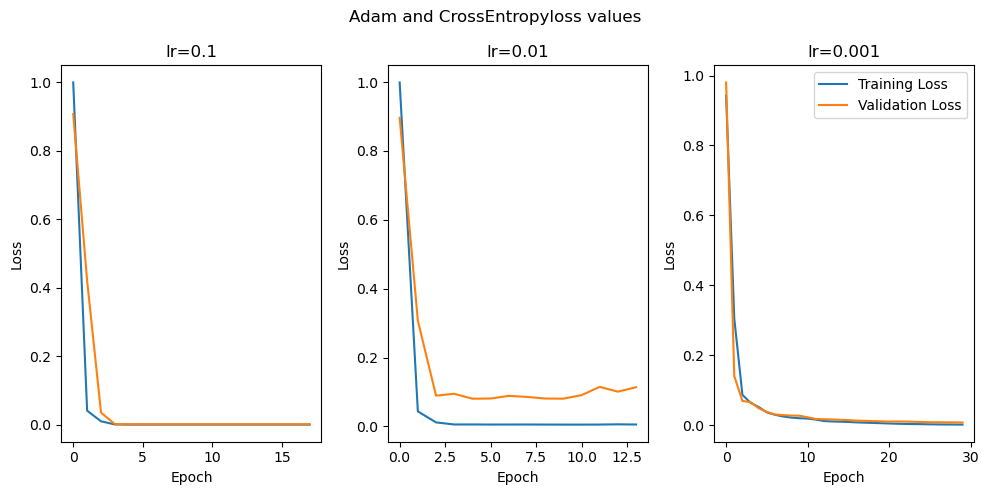

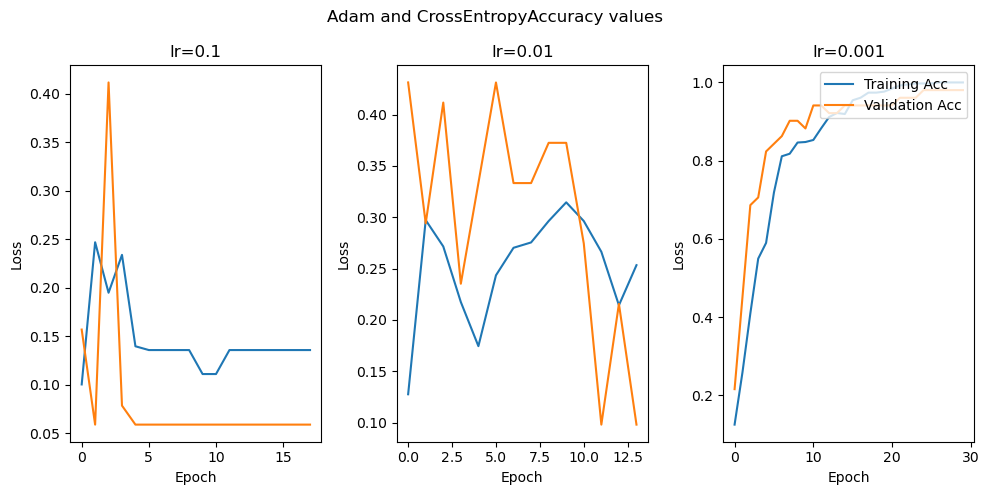

In [84]:
# Hidden layer size 2
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_1_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'Adam', n_epochs, 'Adam and CrossEntropy', patience=10)

Adam and CrossEntropy w/ lr= 0.001
Epoch [1/22], Train Loss: 19.5033, Val Loss: 9.0393, Train Acc: 0.1810, Val Acc: 0.0392
Epoch [2/22], Train Loss: 5.5170, Val Loss: 1.8814, Train Acc: 0.2083, Val Acc: 0.3529
Epoch [3/22], Train Loss: 2.1297, Val Loss: 1.3036, Train Acc: 0.3215, Val Acc: 0.6078
Epoch [4/22], Train Loss: 1.4819, Val Loss: 1.2282, Train Acc: 0.4990, Val Acc: 0.5686
Epoch [5/22], Train Loss: 1.1668, Val Loss: 0.8584, Train Acc: 0.6121, Val Acc: 0.7059
Epoch [6/22], Train Loss: 0.8806, Val Loss: 0.4891, Train Acc: 0.7124, Val Acc: 0.8824
Epoch [7/22], Train Loss: 0.5829, Val Loss: 0.3569, Train Acc: 0.8581, Val Acc: 0.9020
Epoch [8/22], Train Loss: 0.4895, Val Loss: 0.3132, Train Acc: 0.8647, Val Acc: 0.9020
Epoch [9/22], Train Loss: 0.4067, Val Loss: 0.2989, Train Acc: 0.8752, Val Acc: 0.8824
Epoch [10/22], Train Loss: 0.3706, Val Loss: 0.2784, Train Acc: 0.9025, Val Acc: 0.9020
Epoch [11/22], Train Loss: 0.3266, Val Loss: 0.2579, Train Acc: 0.9090, Val Acc: 0.9216
Epoch

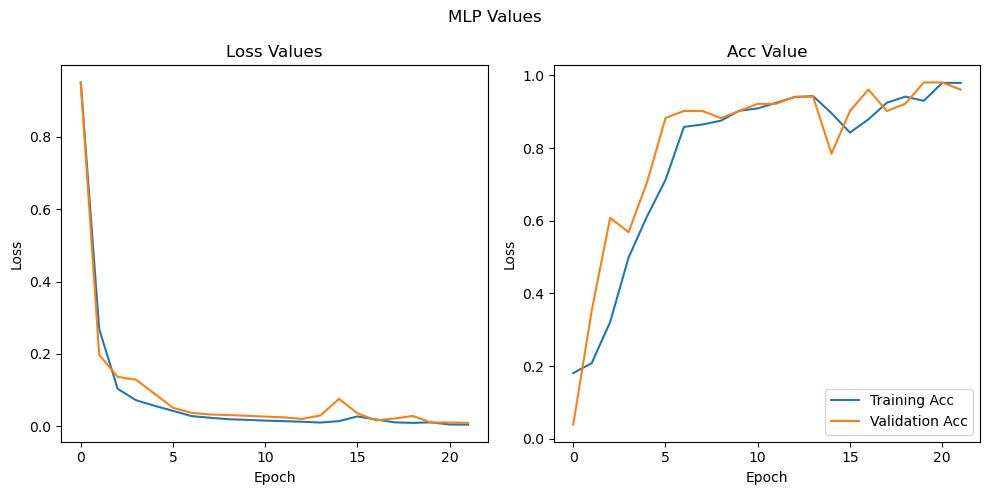

Evaluating with the Training data
Confusion Matrix:
 [[82  0  0  0  0  0  0  0  0]
 [ 0 82  0  0  0  0  0  0  0]
 [ 0  0 82  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  0  0]
 [ 0  0  0  0 82  0  0  0  0]
 [ 0  0  0  0  0 82  0  0  0]
 [ 0  0  0  0  0  1 81  0  0]
 [ 0  0  0  0  0  0  0 82  0]
 [ 0  0  0  0  0  0  0  0 82]]
F1 Score:  0.9946024407214059
Accuracy:  0.994579945799458
Precison:  0.9948320413436692
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  7  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  4  0  0]
 [ 0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  5]]
F1 Score:  0.9688453159041395
Accuracy:  0.9607843137254902
Precison:  0.9869281045751634
Evaluating with the Test data
Confusion Matrix:
 [[6 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 4 0 0

In [56]:
# lr = 0.001
model_adam_ce_dos_2 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'Adam', 22, 'Adam and CrossEntropy',0.001, patience=10)
print('Evaluating with the Test data')
evaluate_network(model_adam_ce_dos_2, X_test_fl, y_test_fl)

###### **Class Weighting Adam and CrossEntropy**

Adam and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 1218297.7315, Val Loss: 54691.8516, Train Acc: 0.0943, Val Acc: 0.0980
Epoch [2/30], Train Loss: 208131.1186, Val Loss: 2684.5461, Train Acc: 0.1443, Val Acc: 0.1373
Epoch [3/30], Train Loss: 10033.3568, Val Loss: 178.8298, Train Acc: 0.1717, Val Acc: 0.3922
Epoch [4/30], Train Loss: 688.6309, Val Loss: 2.0205, Train Acc: 0.3439, Val Acc: 0.2353
Epoch [5/30], Train Loss: 22.0282, Val Loss: 1.9850, Train Acc: 0.2948, Val Acc: 0.2549
Epoch [6/30], Train Loss: 21.9482, Val Loss: 1.9470, Train Acc: 0.2948, Val Acc: 0.2745
Epoch [7/30], Train Loss: 22.3729, Val Loss: 2.0285, Train Acc: 0.2948, Val Acc: 0.2157
Epoch [8/30], Train Loss: 22.1726, Val Loss: 2.0280, Train Acc: 0.2985, Val Acc: 0.3333
Epoch [9/30], Train Loss: 22.1014, Val Loss: 2.0303, Train Acc: 0.3409, Val Acc: 0.3333
Epoch [10/30], Train Loss: 21.9800, Val Loss: 1.9996, Train Acc: 0.3432, Val Acc: 0.3529
Epoch [11/30], Train Loss: 21.6682, Val Loss: 1.9318, Train Acc: 

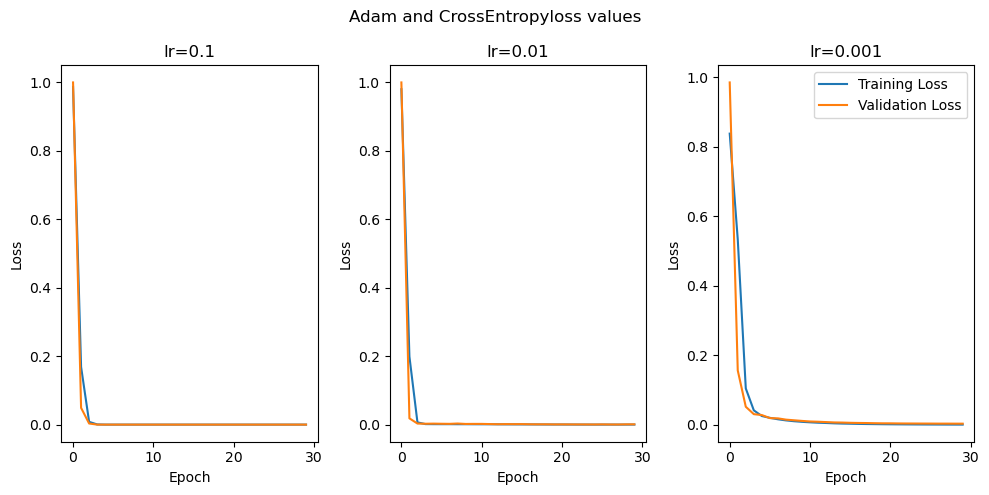

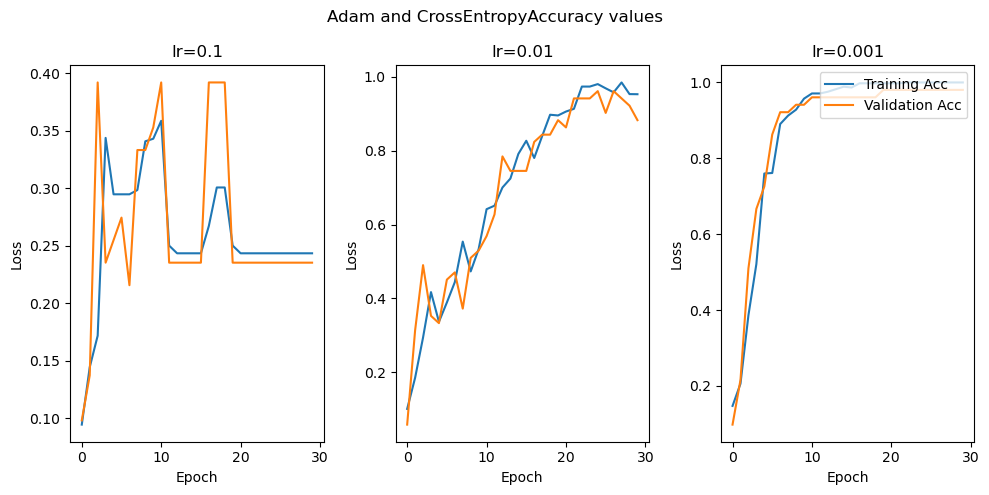

In [87]:
# Hidden layer size 1
train_val_model_ev_best_optmizer(MLP, num_inputs, hidden_layer_sizes_1, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'Adam', n_epochs, 'Adam and CrossEntropy', patience=15, ClassWeights=True)

Adam and CrossEntropy w/ lr= 0.001
Epoch [1/20], Train Loss: 397.5306, Val Loss: 53.7271, Train Acc: 0.1549, Val Acc: 0.0196
Epoch [2/20], Train Loss: 330.0900, Val Loss: 3.4066, Train Acc: 0.1115, Val Acc: 0.4902
Epoch [3/20], Train Loss: 55.9610, Val Loss: 1.9905, Train Acc: 0.3942, Val Acc: 0.4902
Epoch [4/20], Train Loss: 19.5921, Val Loss: 1.6347, Train Acc: 0.4435, Val Acc: 0.4902
Epoch [5/20], Train Loss: 14.0875, Val Loss: 1.2041, Train Acc: 0.6561, Val Acc: 0.7255
Epoch [6/20], Train Loss: 10.4453, Val Loss: 1.0065, Train Acc: 0.8001, Val Acc: 0.7255
Epoch [7/20], Train Loss: 8.4409, Val Loss: 0.8098, Train Acc: 0.8180, Val Acc: 0.8431
Epoch [8/20], Train Loss: 6.7254, Val Loss: 0.7059, Train Acc: 0.9057, Val Acc: 0.8431
Epoch [9/20], Train Loss: 5.6986, Val Loss: 0.6650, Train Acc: 0.9149, Val Acc: 0.8431
Epoch [10/20], Train Loss: 4.8052, Val Loss: 0.5692, Train Acc: 0.9327, Val Acc: 0.9216
Epoch [11/20], Train Loss: 4.0669, Val Loss: 0.5343, Train Acc: 0.9464, Val Acc: 0.90

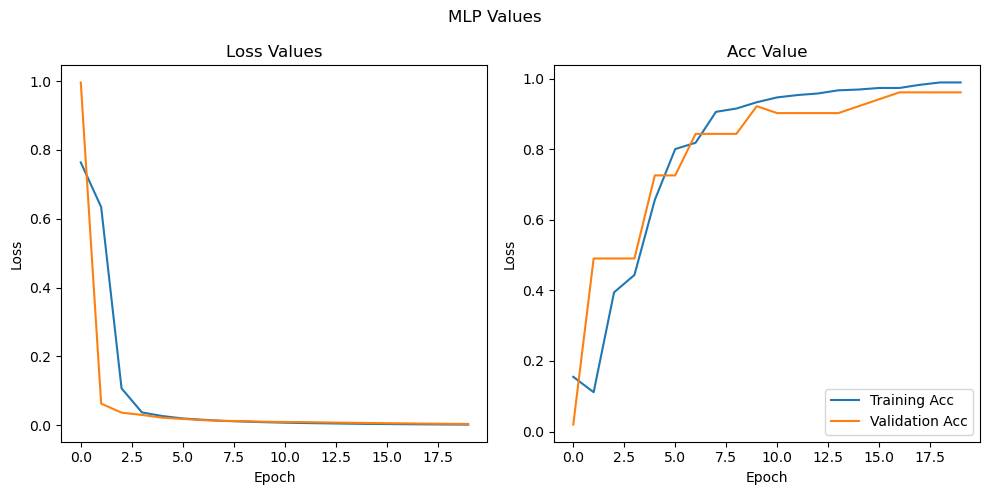

Evaluating with the Training data
Confusion Matrix:
 [[76  0  0  0  0  0  0  0  0]
 [ 0 27  0  0  0  0  0  0  0]
 [ 0  0 72  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  1  0  0]
 [ 0  0  0  0 26  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0]
 [ 0  0  0  0  0  1 25  0  0]
 [ 0  0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0  0  0 65]]
F1 Score:  0.9951737806310521
Accuracy:  0.9951690821256038
Precison:  0.9952422778509734
Evaluating with the Validation data
Confusion Matrix:
 [[ 8  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  1  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9633986928104575
Accuracy:  0.9607843137254902
Precison:  0.9705882352941176
Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  2]
 [ 0  0 12  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0]
 

In [77]:
# lr = 0.001
model_adam_ce_cw = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'Adam', 20, 'Adam and CrossEntropy',0.001, patience=10, ClassWeights=True)
print('Evaluating with the Test data')
evaluate_network(model_adam_ce_cw, X_test_fl, y_test_fl)

Adam and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 626583.0750, Val Loss: 25390.4180, Train Acc: 0.0969, Val Acc: 0.0980
Epoch [2/30], Train Loss: 91651.4990, Val Loss: 1073.4867, Train Acc: 0.1805, Val Acc: 0.1961
Epoch [3/30], Train Loss: 4475.4718, Val Loss: 26.1424, Train Acc: 0.2314, Val Acc: 0.3922
Epoch [4/30], Train Loss: 249.5980, Val Loss: 4.6834, Train Acc: 0.3333, Val Acc: 0.2549
Epoch [5/30], Train Loss: 30.4912, Val Loss: 2.3141, Train Acc: 0.2680, Val Acc: 0.1373
Epoch [6/30], Train Loss: 22.9413, Val Loss: 2.1240, Train Acc: 0.1966, Val Acc: 0.1373
Epoch [7/30], Train Loss: 23.3886, Val Loss: 2.1057, Train Acc: 0.1787, Val Acc: 0.1373
Epoch [8/30], Train Loss: 23.3412, Val Loss: 2.0949, Train Acc: 0.2405, Val Acc: 0.2941
Epoch [9/30], Train Loss: 23.2307, Val Loss: 2.0918, Train Acc: 0.2963, Val Acc: 0.2941
Epoch [10/30], Train Loss: 23.1560, Val Loss: 2.0930, Train Acc: 0.2963, Val Acc: 0.2941
Epoch [11/30], Train Loss: 23.1050, Val Loss: 2.0954, Train Acc: 0.29

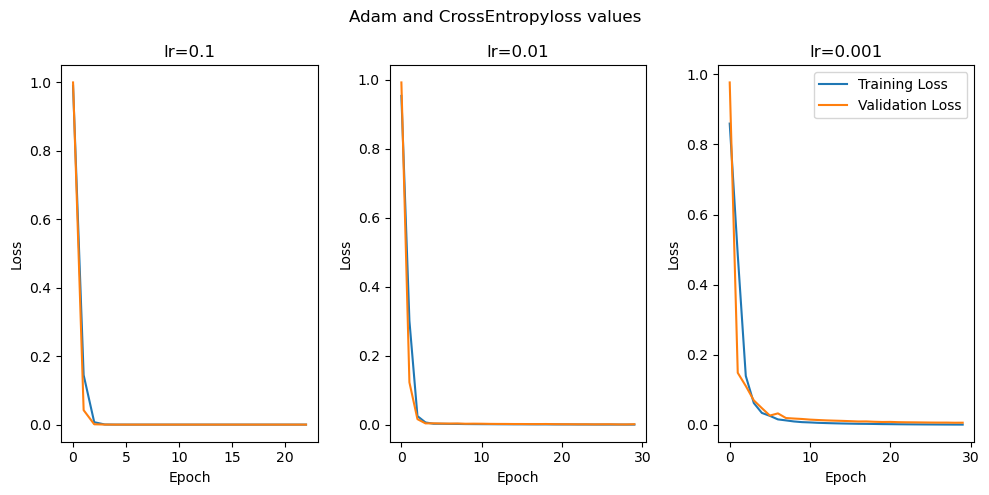

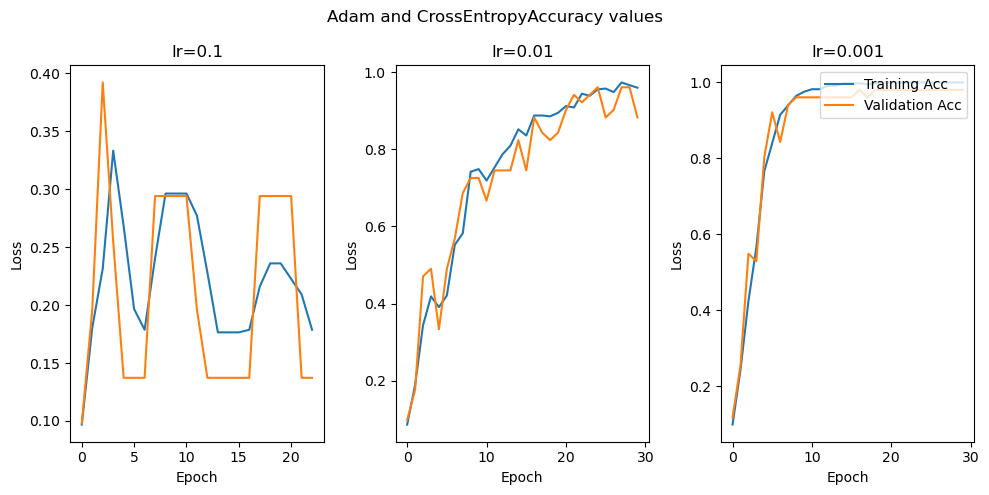

In [88]:
# Hidden layer size 2
train_val_model_ev_best_optmizer(MLP, num_inputs, hidden_layer_sizes_1_2, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'Adam', n_epochs, 'Adam and CrossEntropy', patience=15, ClassWeights=True)

Adam and CrossEntropy w/ lr= 0.01
Epoch [1/30], Train Loss: 6013.2365, Val Loss: 538.9587, Train Acc: 0.1479, Val Acc: 0.0196
Epoch [2/30], Train Loss: 1879.5997, Val Loss: 28.6210, Train Acc: 0.1710, Val Acc: 0.2941
Epoch [3/30], Train Loss: 149.1473, Val Loss: 2.4741, Train Acc: 0.3301, Val Acc: 0.5490
Epoch [4/30], Train Loss: 22.9619, Val Loss: 1.4514, Train Acc: 0.4060, Val Acc: 0.5294
Epoch [5/30], Train Loss: 17.5229, Val Loss: 1.3308, Train Acc: 0.4713, Val Acc: 0.5098
Epoch [6/30], Train Loss: 16.6056, Val Loss: 1.2165, Train Acc: 0.4783, Val Acc: 0.5294
Epoch [7/30], Train Loss: 15.2061, Val Loss: 1.1985, Train Acc: 0.4844, Val Acc: 0.5686
Epoch [8/30], Train Loss: 14.4507, Val Loss: 1.1301, Train Acc: 0.5254, Val Acc: 0.6471
Epoch [9/30], Train Loss: 12.6547, Val Loss: 0.9669, Train Acc: 0.6332, Val Acc: 0.7255
Epoch [10/30], Train Loss: 11.6017, Val Loss: 0.9073, Train Acc: 0.6899, Val Acc: 0.7647
Epoch [11/30], Train Loss: 10.7945, Val Loss: 0.8281, Train Acc: 0.7158, Val 

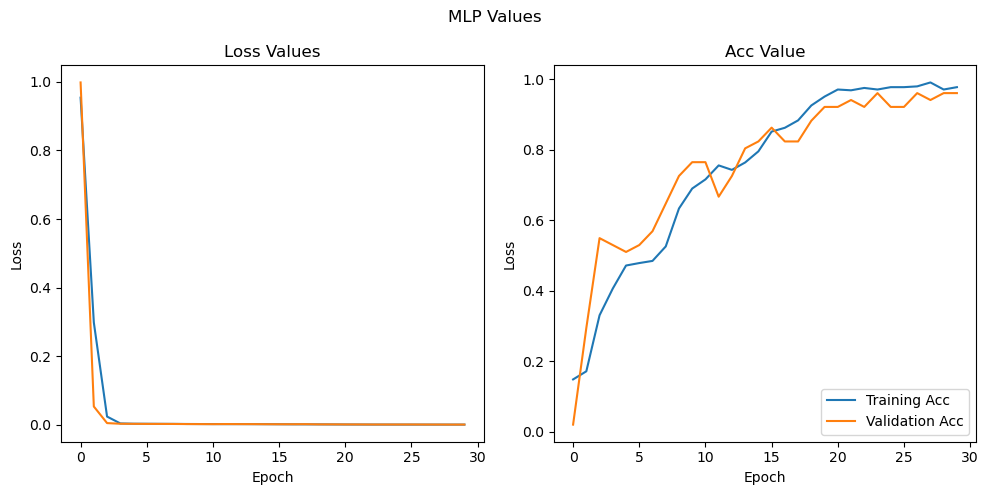

Evaluating with the Training data
Confusion Matrix:
 [[76  0  0  0  0  0  0  0  0]
 [ 0 27  0  0  0  0  0  0  0]
 [ 0  0 72  0  0  0  0  0  0]
 [ 0  0  0 44  0  0  0  0  0]
 [ 0  0  0  0 25  1  0  0  0]
 [ 0  0  0  0  0 32  0  0  0]
 [ 0  0  0  0  0  3 23  0  0]
 [ 0  0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0  0  0 65]]
F1 Score:  0.9903768270593261
Accuracy:  0.9903381642512077
Precison:  0.9914117015566292
Evaluating with the Validation data
Confusion Matrix:
 [[ 8  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0]
 [ 0  0  0  0  2  1  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9588235294117646
Accuracy:  0.9607843137254902
Precison:  0.9673202614379085
Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 2  4  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0]
 

c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
# lr = 0.01
model_adam_ce_cw_2 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1_2, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'Adam', n_epochs, 'Adam and CrossEntropy',0.01, patience=10, ClassWeights=True)
print('Evaluating with the Test data')
evaluate_network(model_adam_ce_cw_2, X_test_fl, y_test_fl)

###### **Data Oversampling SGD and CrossEntropy**

SGD and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 2.7009, Val Loss: 2.8013, Train Acc: 0.2344, Val Acc: 0.0784
Epoch [2/30], Train Loss: 2.2017, Val Loss: 1.8617, Train Acc: 0.2040, Val Acc: 0.5294
Epoch [3/30], Train Loss: 1.9759, Val Loss: 1.6837, Train Acc: 0.2956, Val Acc: 0.5098
Epoch [4/30], Train Loss: 1.7256, Val Loss: 1.5241, Train Acc: 0.3630, Val Acc: 0.5882
Epoch [5/30], Train Loss: 1.5002, Val Loss: 1.2545, Train Acc: 0.4343, Val Acc: 0.7059
Epoch [6/30], Train Loss: 1.3219, Val Loss: 1.0754, Train Acc: 0.4970, Val Acc: 0.7059
Epoch [7/30], Train Loss: 1.1660, Val Loss: 0.8045, Train Acc: 0.6052, Val Acc: 0.7451
Epoch [8/30], Train Loss: 0.9186, Val Loss: 0.5733, Train Acc: 0.6835, Val Acc: 0.8039
Epoch [9/30], Train Loss: 0.6897, Val Loss: 0.3962, Train Acc: 0.7724, Val Acc: 0.9020
Epoch [10/30], Train Loss: 0.4550, Val Loss: 0.4095, Train Acc: 0.8490, Val Acc: 0.8627
Epoch [11/30], Train Loss: 0.5707, Val Loss: 0.9378, Train Acc: 0.8130, Val Acc: 0.8039
Epoch [12/

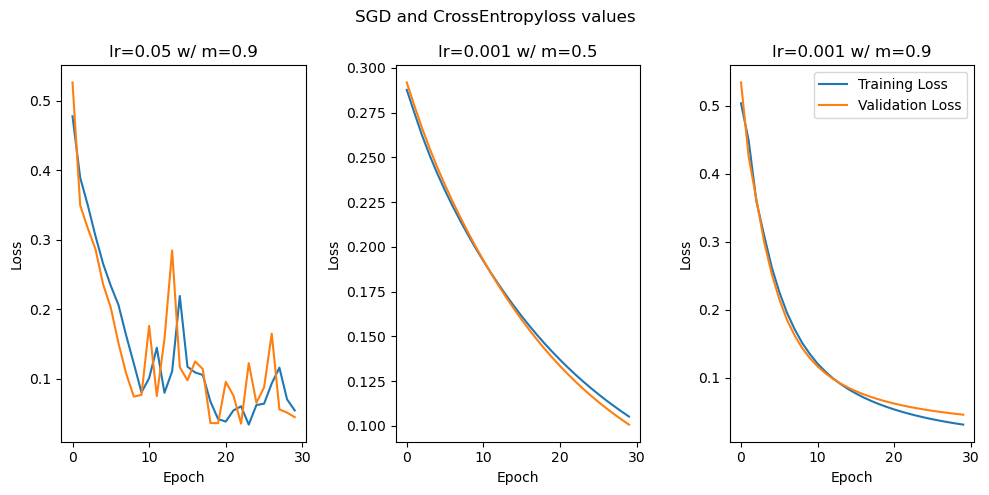

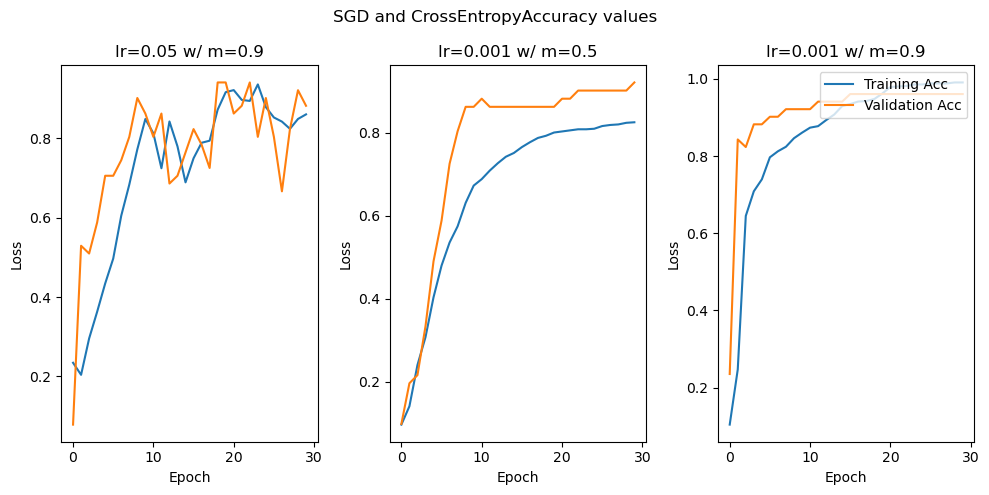

In [114]:
# Hidden layer size 1
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'SGD', n_epochs, 'SGD and CrossEntropy', patience=10)

In [ ]:
# SGD with momentum prevents to use a high lr and miss the minimum. 
# This SGD w/ momentum can be explained by the analogy of the bowl, you can use momentum to acelerate the descreace to the bottom.

SGD and CrossEntropy w/ lr= 0.001
Epoch [1/35], Train Loss: 2.3158, Val Loss: 2.0537, Train Acc: 0.0962, Val Acc: 0.1961
Epoch [2/35], Train Loss: 2.0272, Val Loss: 1.7045, Train Acc: 0.2822, Val Acc: 0.7255
Epoch [3/35], Train Loss: 1.6914, Val Loss: 1.4178, Train Acc: 0.6778, Val Acc: 0.7255
Epoch [4/35], Train Loss: 1.4435, Val Loss: 1.2081, Train Acc: 0.7260, Val Acc: 0.8039
Epoch [5/35], Train Loss: 1.2219, Val Loss: 1.0269, Train Acc: 0.7700, Val Acc: 0.8235
Epoch [6/35], Train Loss: 1.0443, Val Loss: 0.8907, Train Acc: 0.8112, Val Acc: 0.8235
Epoch [7/35], Train Loss: 0.8964, Val Loss: 0.7846, Train Acc: 0.8423, Val Acc: 0.8235
Epoch [8/35], Train Loss: 0.7780, Val Loss: 0.6992, Train Acc: 0.8665, Val Acc: 0.8627
Epoch [9/35], Train Loss: 0.6817, Val Loss: 0.6327, Train Acc: 0.8920, Val Acc: 0.8627
Epoch [10/35], Train Loss: 0.6034, Val Loss: 0.5776, Train Acc: 0.8991, Val Acc: 0.8627
Epoch [11/35], Train Loss: 0.5387, Val Loss: 0.5325, Train Acc: 0.9091, Val Acc: 0.9020
Epoch [

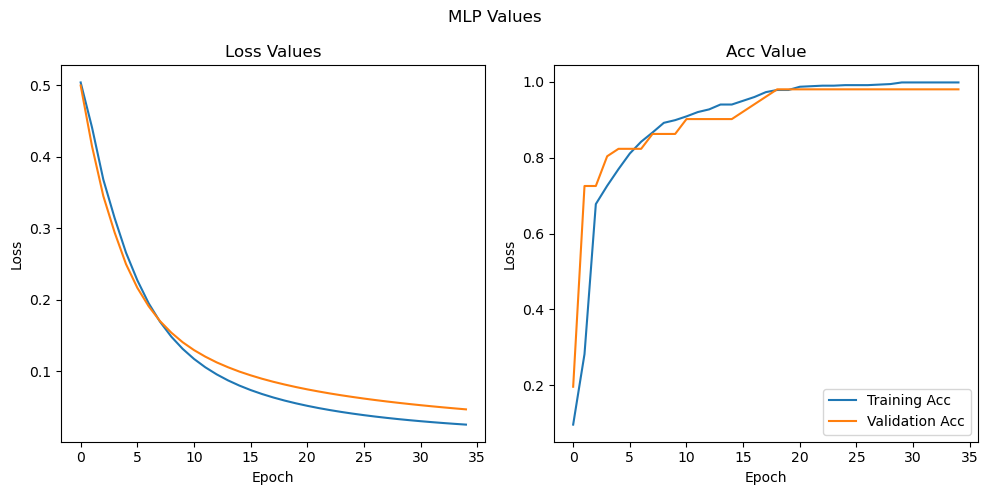

Evaluating with the Training data
Confusion Matrix:
 [[76  0  0  0  0  0  0  0  0]
 [ 0 76  0  0  0  0  0  0  0]
 [ 0  0 76  0  0  0  0  0  0]
 [ 0  0  0 75  0  0  1  0  0]
 [ 0  0  0  0 76  0  0  0  0]
 [ 0  0  0  0  0 76  0  0  0]
 [ 0  0  0  0  0  0 76  0  0]
 [ 0  0  0  0  0  0  0 76  0]
 [ 0  0  0  0  0  0  0  0 76]]
F1 Score:  0.9985379484145878
Accuracy:  0.9985380116959064
Precison:  0.9985569985569985
Evaluating with the Validation data
Confusion Matrix:
 [[ 8  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  1  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9830065359477126
Accuracy:  0.9803921568627451
Precison:  0.9901960784313726
Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  2]
 [ 0  0 12  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0]
 

In [87]:
# lr = 0.001
model_sgd_ce_dos = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'SGD', 35, 'SGD and CrossEntropy',0.001, patience=10)
print('Evaluating with the Test data')
evaluate_network(model_sgd_ce_dos, X_test_fl, y_test_fl)

SGD and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 2.6324, Val Loss: 2.6332, Train Acc: 0.1849, Val Acc: 0.0980
Epoch [2/30], Train Loss: 2.2516, Val Loss: 1.9899, Train Acc: 0.1883, Val Acc: 0.2745
Epoch [3/30], Train Loss: 2.0900, Val Loss: 1.7898, Train Acc: 0.2513, Val Acc: 0.4314
Epoch [4/30], Train Loss: 1.8426, Val Loss: 1.6262, Train Acc: 0.3333, Val Acc: 0.4118
Epoch [5/30], Train Loss: 1.5850, Val Loss: 1.2754, Train Acc: 0.4306, Val Acc: 0.6275
Epoch [6/30], Train Loss: 1.3774, Val Loss: 1.1660, Train Acc: 0.4579, Val Acc: 0.6667
Epoch [7/30], Train Loss: 1.2244, Val Loss: 0.9492, Train Acc: 0.5446, Val Acc: 0.7451
Epoch [8/30], Train Loss: 1.0565, Val Loss: 0.6591, Train Acc: 0.6339, Val Acc: 0.7843
Epoch [9/30], Train Loss: 0.7326, Val Loss: 0.5362, Train Acc: 0.7412, Val Acc: 0.8431
Epoch [10/30], Train Loss: 0.5128, Val Loss: 0.5584, Train Acc: 0.8346, Val Acc: 0.7843
Epoch [11/30], Train Loss: 0.6105, Val Loss: 1.0266, Train Acc: 0.7878, Val Acc: 0.8431
Epoch [12/

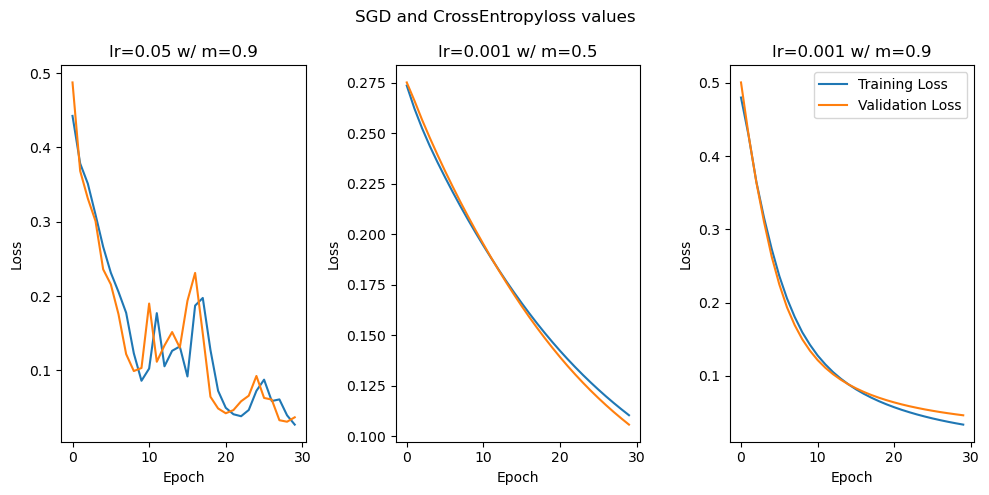

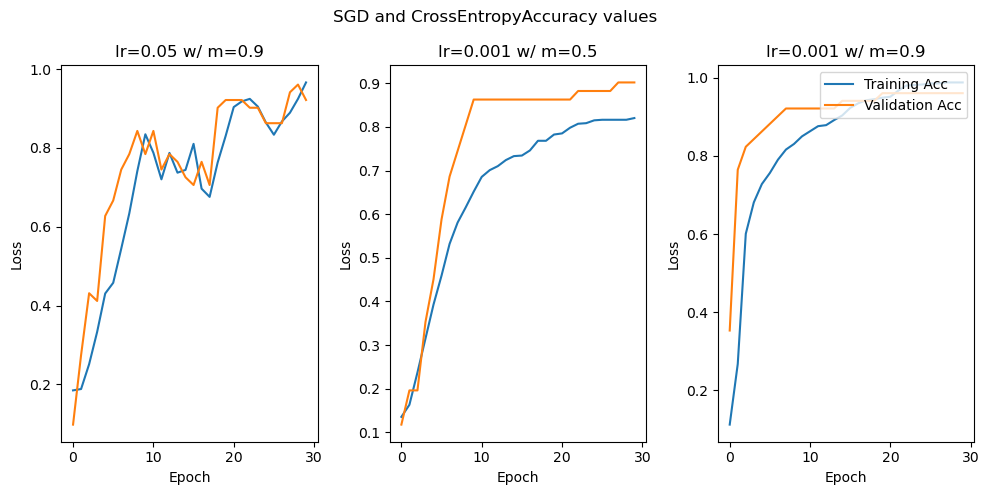

In [116]:
# Hidden layer size 2
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_1_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'SGD', n_epochs, 'SGD and CrossEntropy', patience=10)

SGD and CrossEntropy w/ lr= 0.001
Epoch [1/35], Train Loss: 2.2920, Val Loss: 2.0208, Train Acc: 0.0989, Val Acc: 0.4510
Epoch [2/35], Train Loss: 2.0171, Val Loss: 1.8181, Train Acc: 0.3368, Val Acc: 0.6667
Epoch [3/35], Train Loss: 1.7945, Val Loss: 1.5076, Train Acc: 0.6366, Val Acc: 0.7843
Epoch [4/35], Train Loss: 1.5456, Val Loss: 1.3232, Train Acc: 0.7381, Val Acc: 0.8039
Epoch [5/35], Train Loss: 1.3493, Val Loss: 1.1257, Train Acc: 0.7658, Val Acc: 0.8235
Epoch [6/35], Train Loss: 1.1623, Val Loss: 0.9822, Train Acc: 0.7942, Val Acc: 0.8235
Epoch [7/35], Train Loss: 1.0086, Val Loss: 0.8617, Train Acc: 0.8169, Val Acc: 0.8235
Epoch [8/35], Train Loss: 0.8776, Val Loss: 0.7677, Train Acc: 0.8496, Val Acc: 0.8235
Epoch [9/35], Train Loss: 0.7712, Val Loss: 0.6915, Train Acc: 0.8595, Val Acc: 0.8627
Epoch [10/35], Train Loss: 0.6820, Val Loss: 0.6304, Train Acc: 0.8935, Val Acc: 0.8627
Epoch [11/35], Train Loss: 0.6087, Val Loss: 0.5790, Train Acc: 0.9006, Val Acc: 0.8824
Epoch [

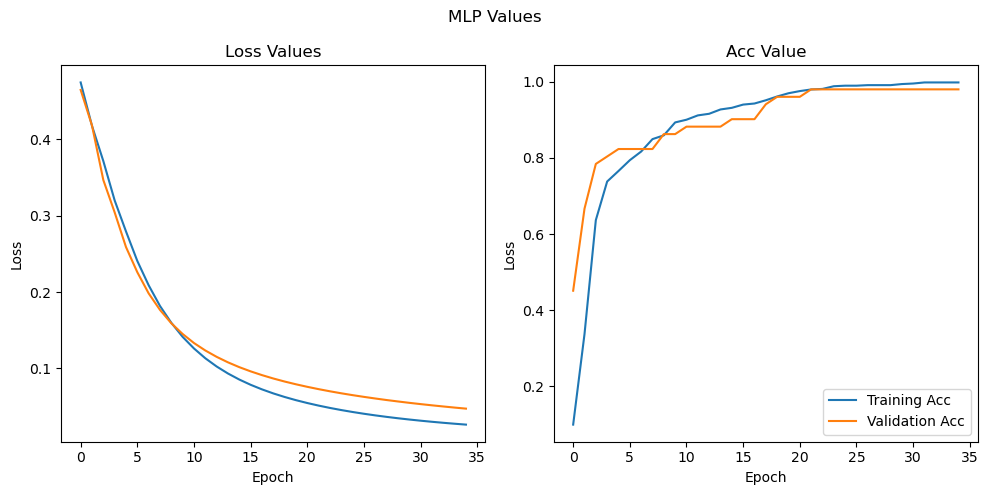

Evaluating with the Training data
Confusion Matrix:
 [[76  0  0  0  0  0  0  0  0]
 [ 0 76  0  0  0  0  0  0  0]
 [ 0  0 76  0  0  0  0  0  0]
 [ 0  0  0 75  0  0  1  0  0]
 [ 0  0  0  0 76  0  0  0  0]
 [ 0  0  0  0  0 76  0  0  0]
 [ 0  0  0  0  0  0 76  0  0]
 [ 0  0  0  0  0  0  0 76  0]
 [ 0  0  0  0  0  0  0  0 76]]
F1 Score:  0.9985379484145878
Accuracy:  0.9985380116959064
Precison:  0.9985569985569985
Evaluating with the Validation data
Confusion Matrix:
 [[ 8  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  1  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9830065359477126
Accuracy:  0.9803921568627451
Precison:  0.9901960784313726
Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  2]
 [ 0  0 12  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0]
 

In [89]:
# lr = 0.001
model_sgd_ce_dos_2 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'SGD', 35, 'SGD and CrossEntropy',0.001, patience=10)
print('Evaluating with the Test data')
evaluate_network(model_sgd_ce_dos_2, X_test_fl, y_test_fl)

###### **Class Weighting SGD and CrossEntropy**

SGD and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 58.6125, Val Loss: 2.2710, Train Acc: 0.1766, Val Acc: 0.2745
Epoch [2/30], Train Loss: 30.2670, Val Loss: 4.4936, Train Acc: 0.2479, Val Acc: 0.2549
Epoch [3/30], Train Loss: 32.1803, Val Loss: 2.7394, Train Acc: 0.2749, Val Acc: 0.5098
Epoch [4/30], Train Loss: 22.6839, Val Loss: 2.8552, Train Acc: 0.5028, Val Acc: 0.5294
Epoch [5/30], Train Loss: 61.2263, Val Loss: 5.6535, Train Acc: 0.2353, Val Acc: 0.2353
Epoch [6/30], Train Loss: 26.5363, Val Loss: 2.2918, Train Acc: 0.3473, Val Acc: 0.2941
Epoch [7/30], Train Loss: 22.5664, Val Loss: 3.3646, Train Acc: 0.3470, Val Acc: 0.3333
Epoch [8/30], Train Loss: 21.5173, Val Loss: 1.8403, Train Acc: 0.3875, Val Acc: 0.4510
Epoch [9/30], Train Loss: 18.5638, Val Loss: 2.2438, Train Acc: 0.5076, Val Acc: 0.4314
Epoch [10/30], Train Loss: 22.1808, Val Loss: 1.9681, Train Acc: 0.3589, Val Acc: 0.3725
Epoch [11/30], Train Loss: 22.4782, Val Loss: 1.9959, Train Acc: 0.3149, Val Acc: 0.2353

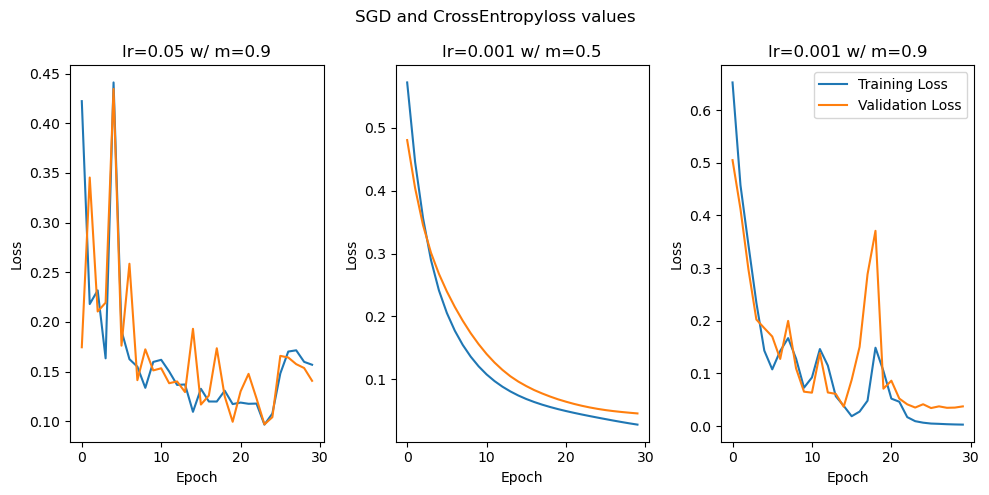

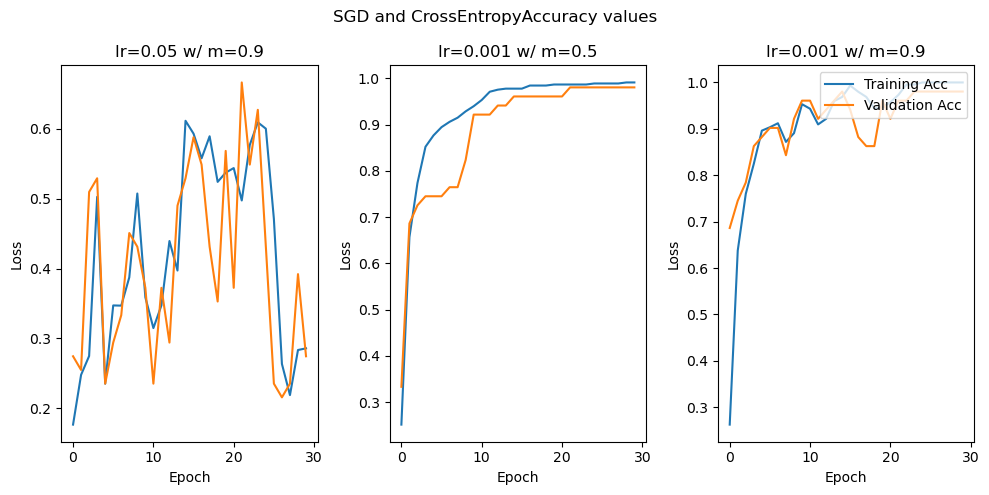

In [120]:
# Hidden layer size 1
train_val_model_ev_best_optmizer(MLP, num_inputs, hidden_layer_sizes_1, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'SGD', n_epochs, 'SGD and CrossEntropy', patience=15, ClassWeights=True)

SGD and CrossEntropy w/ lr= 0.001
Epoch [1/30], Train Loss: 21.0432, Val Loss: 1.5109, Train Acc: 0.3171, Val Acc: 0.6471
Epoch [2/30], Train Loss: 15.4539, Val Loss: 1.1468, Train Acc: 0.6214, Val Acc: 0.7843
Epoch [3/30], Train Loss: 11.9489, Val Loss: 0.9303, Train Acc: 0.7493, Val Acc: 0.8039
Epoch [4/30], Train Loss: 9.6349, Val Loss: 0.7955, Train Acc: 0.8171, Val Acc: 0.8235
Epoch [5/30], Train Loss: 8.0421, Val Loss: 0.7038, Train Acc: 0.8464, Val Acc: 0.8431
Epoch [6/30], Train Loss: 6.8828, Val Loss: 0.6367, Train Acc: 0.8621, Val Acc: 0.8431
Epoch [7/30], Train Loss: 6.0036, Val Loss: 0.5849, Train Acc: 0.8827, Val Acc: 0.8431
Epoch [8/30], Train Loss: 5.3146, Val Loss: 0.5447, Train Acc: 0.8964, Val Acc: 0.8627
Epoch [9/30], Train Loss: 4.7641, Val Loss: 0.5124, Train Acc: 0.9143, Val Acc: 0.8627
Epoch [10/30], Train Loss: 4.3110, Val Loss: 0.4866, Train Acc: 0.9210, Val Acc: 0.8627
Epoch [11/30], Train Loss: 3.9360, Val Loss: 0.4647, Train Acc: 0.9210, Val Acc: 0.8627
Epoc

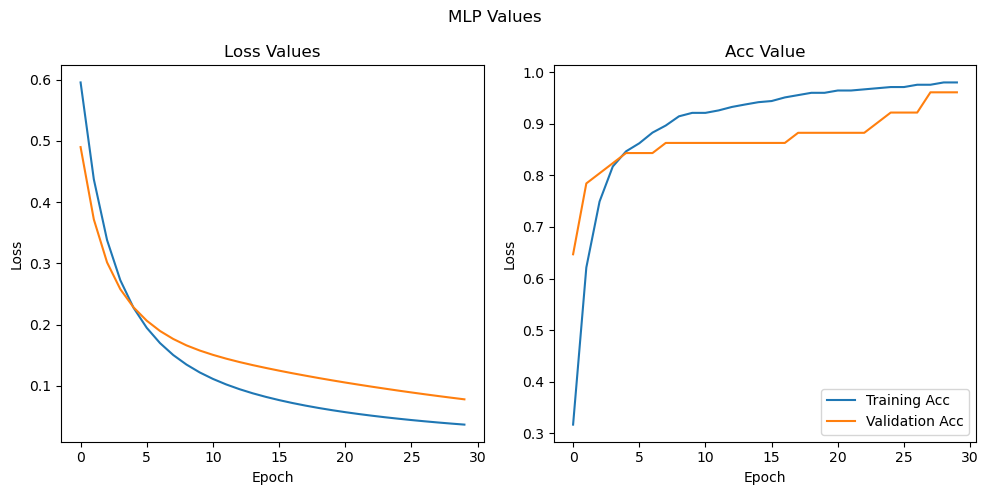

Evaluating with the Training data
Confusion Matrix:
 [[76  0  0  0  0  0  0  0  0]
 [ 0 27  0  0  0  0  0  0  0]
 [ 0  0 72  0  0  0  0  0  0]
 [ 0  0  0 38  0  5  1  0  0]
 [ 0  0  0  0 24  2  0  0  0]
 [ 0  0  0  0  0 32  0  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0  0  0 65]]
F1 Score:  0.9809057782359358
Accuracy:  0.9806763285024155
Precison:  0.9838005973271674
Evaluating with the Validation data
Confusion Matrix:
 [[ 8  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0]
 [ 0  0  0  6  0  1  1  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9645191409897294
Accuracy:  0.9607843137254902
Precison:  0.9803921568627451
Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  2]
 [ 0  0 12  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0]
 

In [92]:
# lr = 0.001
model_sgd_ce_cw = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'SGD', 30, 'SGD and CrossEntropy',0.001, patience=10, ClassWeights=True, m=0.5)
print('Evaluating with the Test data')
evaluate_network(model_sgd_ce_cw, X_test_fl, y_test_fl)

SGD and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 44.7936, Val Loss: 2.6248, Train Acc: 0.1259, Val Acc: 0.2157
Epoch [2/30], Train Loss: 23.2654, Val Loss: 2.0869, Train Acc: 0.2982, Val Acc: 0.3922
Epoch [3/30], Train Loss: 41.8959, Val Loss: 2.8834, Train Acc: 0.2927, Val Acc: 0.3922
Epoch [4/30], Train Loss: 22.6784, Val Loss: 2.4975, Train Acc: 0.3990, Val Acc: 0.3922
Epoch [5/30], Train Loss: 19.9529, Val Loss: 1.7118, Train Acc: 0.3993, Val Acc: 0.5686
Epoch [6/30], Train Loss: 28.1070, Val Loss: 2.1883, Train Acc: 0.3891, Val Acc: 0.2353
Epoch [7/30], Train Loss: 20.9267, Val Loss: 2.1082, Train Acc: 0.3811, Val Acc: 0.3922
Epoch [8/30], Train Loss: 19.9596, Val Loss: 1.7998, Train Acc: 0.4104, Val Acc: 0.4510
Epoch [9/30], Train Loss: 20.1027, Val Loss: 2.3544, Train Acc: 0.4003, Val Acc: 0.2745
Epoch [10/30], Train Loss: 21.2229, Val Loss: 2.0608, Train Acc: 0.3263, Val Acc: 0.2745
Epoch [11/30], Train Loss: 21.3916, Val Loss: 1.9336, Train Acc: 0.3021, Val Acc: 0.4118

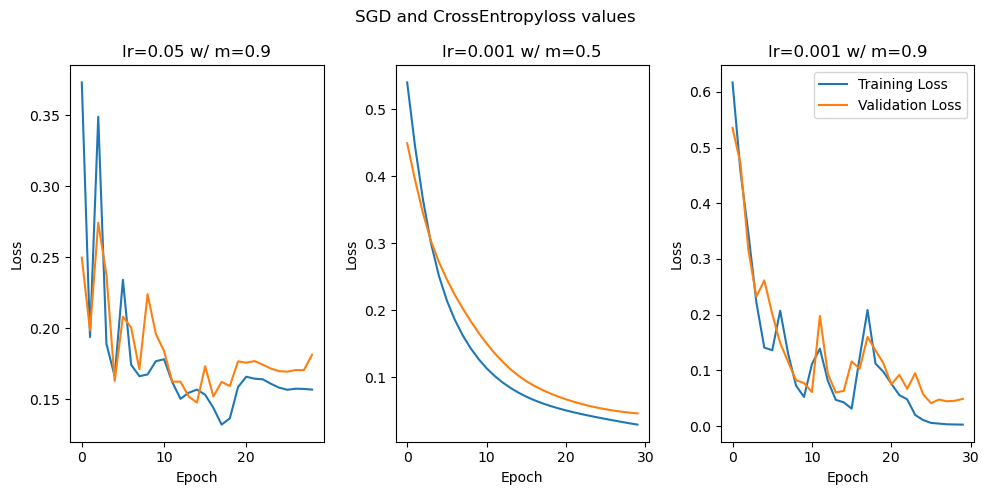

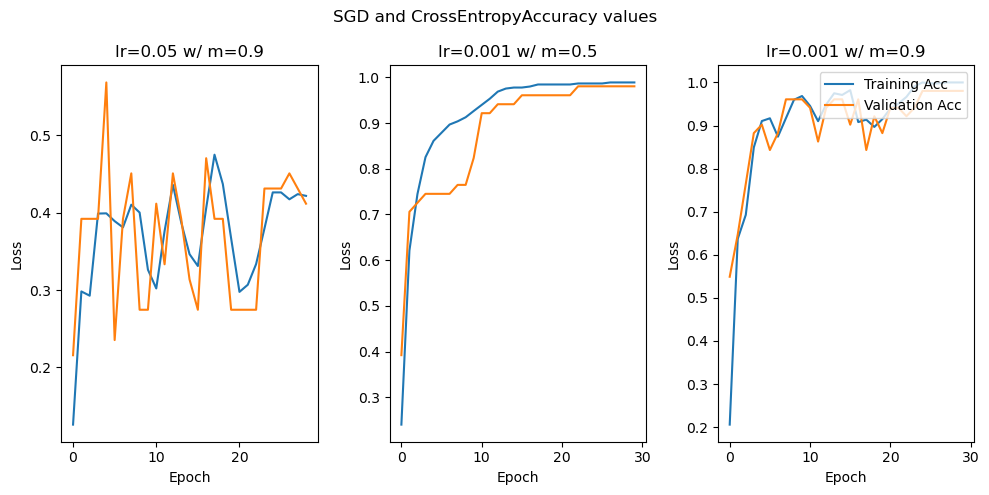

In [121]:
# Hidden layer size 2
train_val_model_ev_best_optmizer(MLP, num_inputs, hidden_layer_sizes_1_2, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'SGD', n_epochs, 'SGD and CrossEntropy', patience=15, ClassWeights=True)

SGD and CrossEntropy w/ lr= 0.001
Epoch [1/30], Train Loss: 21.0600, Val Loss: 1.5586, Train Acc: 0.3260, Val Acc: 0.6275
Epoch [2/30], Train Loss: 16.1495, Val Loss: 1.2103, Train Acc: 0.6144, Val Acc: 0.7843
Epoch [3/30], Train Loss: 12.7748, Val Loss: 0.9876, Train Acc: 0.7292, Val Acc: 0.8039
Epoch [4/30], Train Loss: 10.3962, Val Loss: 0.8445, Train Acc: 0.7967, Val Acc: 0.8235
Epoch [5/30], Train Loss: 8.7106, Val Loss: 0.7469, Train Acc: 0.8260, Val Acc: 0.8235
Epoch [6/30], Train Loss: 7.4717, Val Loss: 0.6755, Train Acc: 0.8464, Val Acc: 0.8431
Epoch [7/30], Train Loss: 6.5236, Val Loss: 0.6199, Train Acc: 0.8598, Val Acc: 0.8431
Epoch [8/30], Train Loss: 5.7754, Val Loss: 0.5755, Train Acc: 0.8897, Val Acc: 0.8627
Epoch [9/30], Train Loss: 5.1731, Val Loss: 0.5399, Train Acc: 0.8987, Val Acc: 0.8627
Epoch [10/30], Train Loss: 4.6788, Val Loss: 0.5111, Train Acc: 0.9143, Val Acc: 0.8627
Epoch [11/30], Train Loss: 4.2691, Val Loss: 0.4870, Train Acc: 0.9210, Val Acc: 0.8627
Epo

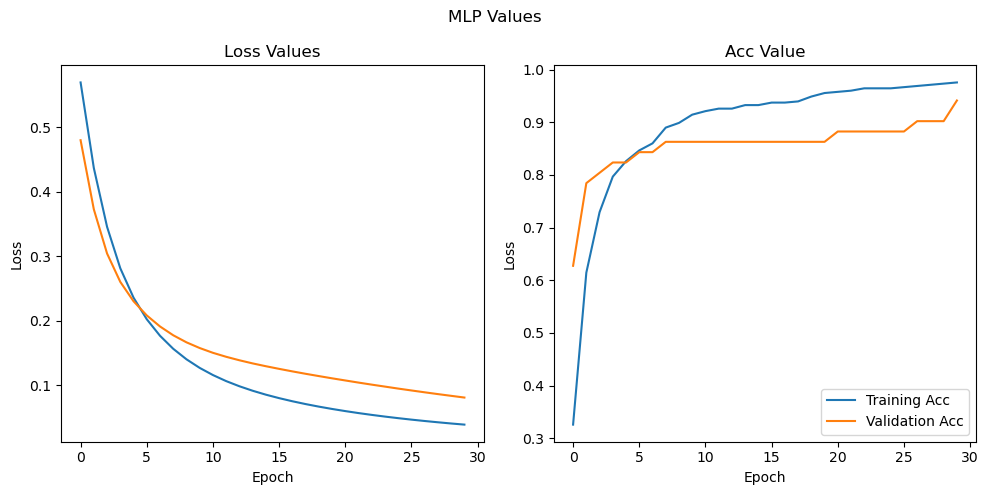

Evaluating with the Training data
Confusion Matrix:
 [[76  0  0  0  0  0  0  0  0]
 [ 0 27  0  0  0  0  0  0  0]
 [ 0  0 72  0  0  0  0  0  0]
 [ 0  0  0 38  0  5  1  0  0]
 [ 0  0  0  0 24  2  0  0  0]
 [ 0  0  0  0  0 32  0  0  0]
 [ 0  0  0  0  0  1 25  0  0]
 [ 0  0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0  0  0 65]]
F1 Score:  0.9787075658196196
Accuracy:  0.9782608695652174
Precison:  0.9821256038647344
Evaluating with the Validation data
Confusion Matrix:
 [[ 8  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0]
 [ 0  0  0  6  0  1  1  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9481792717086835
Accuracy:  0.9411764705882353
Precison:  0.9673202614379085
Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  2]
 [ 0  0 12  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0]
 

In [95]:
# lr = 0.001
model_sgd_ce_cw_2 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1_2, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'SGD', 30, 'SGD and CrossEntropy',0.001, patience=10, ClassWeights=True, m=0.5)
print('Evaluating with the Test data')
evaluate_network(model_sgd_ce_cw_2, X_test_fl, y_test_fl)

###### **Plot the results**

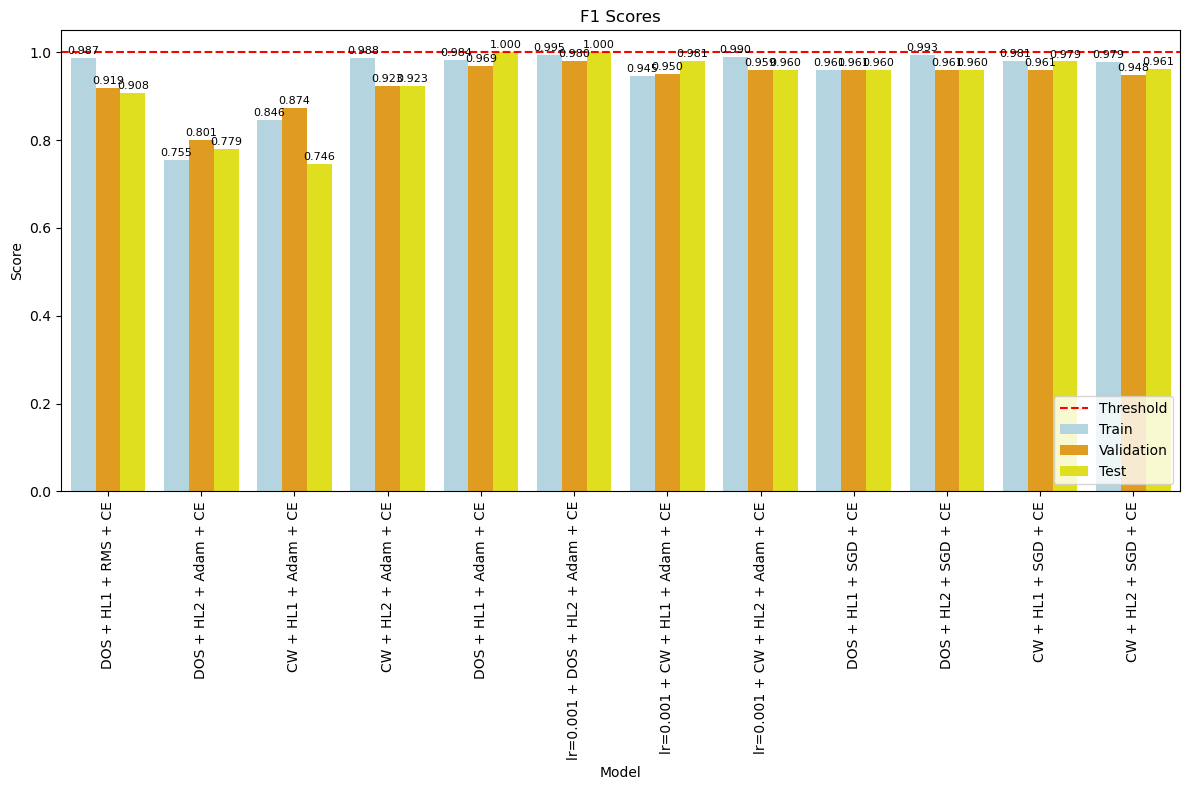

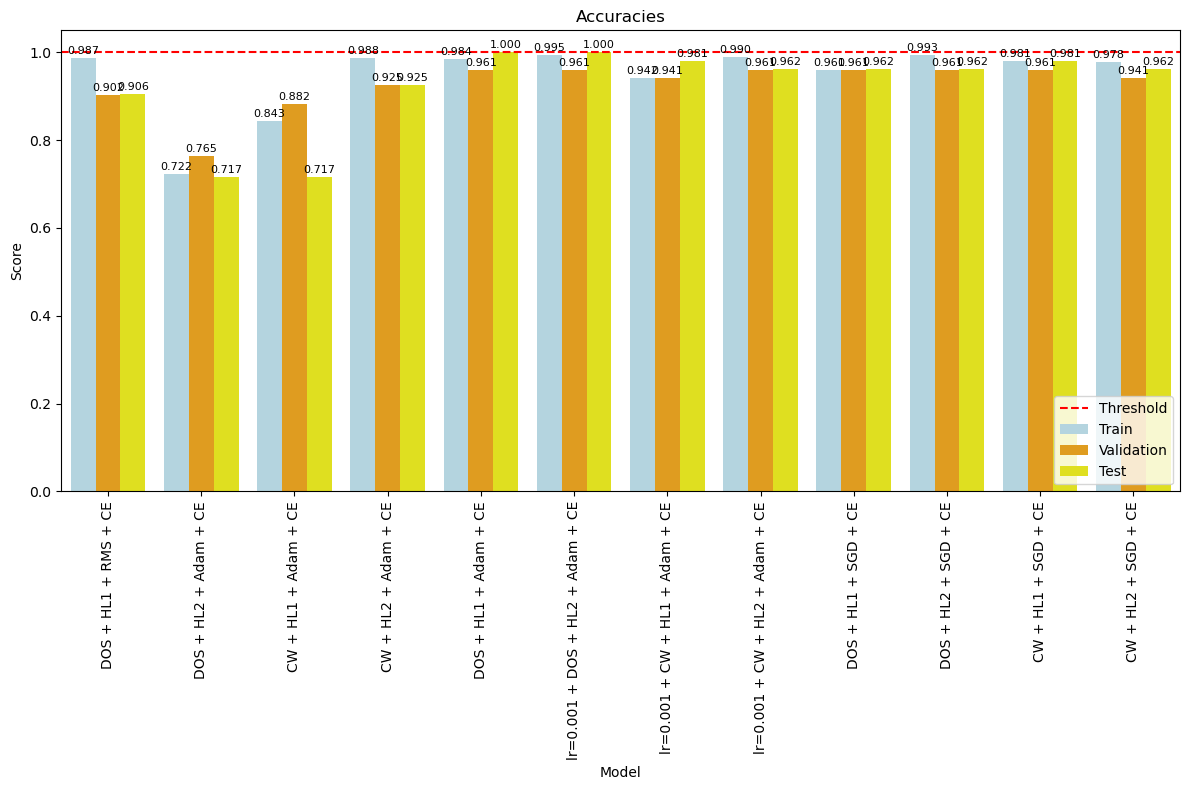

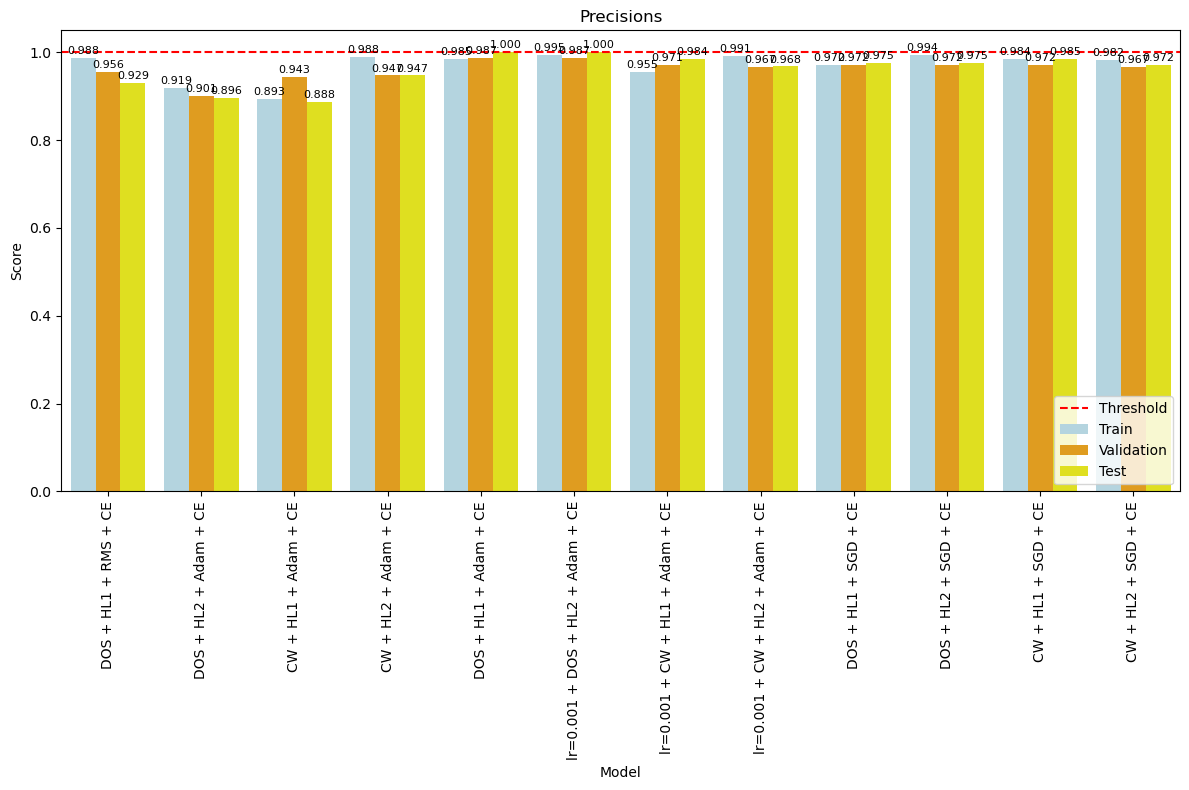

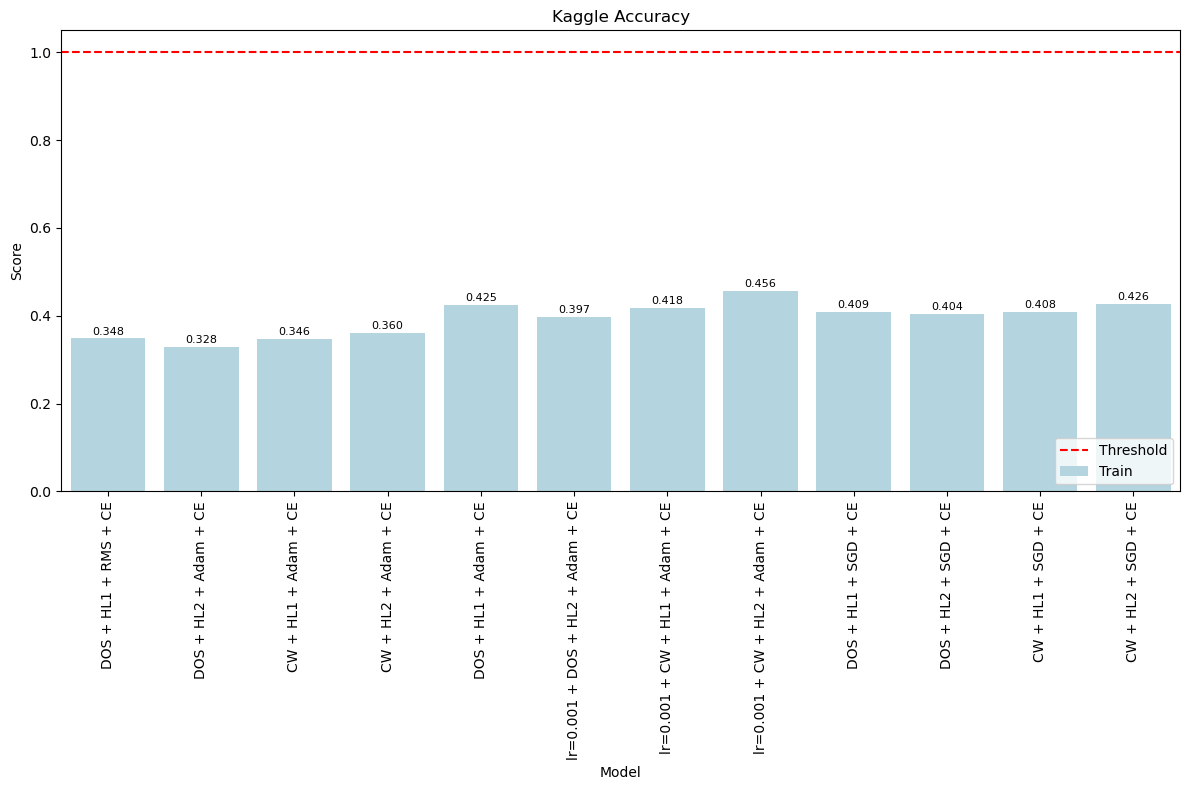

In [94]:
labels = ["DOS + HL1 + RMS + CE","DOS + HL2 + Adam + CE","CW + HL1 + Adam + CE", "CW + HL2 + Adam + CE", "DOS + HL1 + Adam + CE","lr=0.001 + DOS + HL2 + Adam + CE","lr=0.001 + CW + HL1 + Adam + CE","lr=0.001 + CW + HL2 + Adam + CE","DOS + HL1 + SGD + CE","DOS + HL2 + SGD + CE","CW + HL1 + SGD + CE","CW + HL2 + SGD + CE"]

f1_scores_train = [0.9866723074270245, 0.7552769743839503, 0.8463184712895627, 0.9879388343283266, 0.9835536013994083, 0.9946024407214059, 0.9450647372823132, 0.9903768270593261, 0.9606909430438841, 0.9932705535331573, 0.9809057782359358, 0.9787075658196196]
f1_scores_validation = [0.9191335756800653, 0.8007554536966301, 0.873997180571575, 0.9234120177516404, 0.9688453159041395, 0.9798828622358035, 0.9495520370952897, 0.9588235294117646, 0.9606909430438841, 0.9606909430438841, 0.9606909430438841, 0.9481792717086835]
f1_scores_test = [0.9078067680200576, 0.7789643375492433, 0.7455021917286068, 0.9234120177516404, 1.0, 1.0, 0.9806419995099241, 0.9599419448476052, 0.959748427672956, 0.959748427672956, 0.9790356394129979, 0.9611859838274931]

accuracy_train = [0.9868421052631579, 0.7222222222222222, 0.8429951690821256, 0.9879227053140096, 0.983739837398374, 0.994579945799458, 0.9420289855072463, 0.9903381642512077, 0.9607843137254902, 0.9932249322493225, 0.9806763285024155, 0.9782608695652174]
accuracy_validation = [0.9019607843137255, 0.7647058823529411, 0.8823529411764706, 0.9245283018867925, 0.9607843137254902, 0.9607843137254902, 0.9411764705882353, 0.9607843137254902, 0.9607843137254902, 0.9607843137254902, 0.9607843137254902, 0.9411764705882353]
accuracy_test = [0.9056603773584906, 0.7169811320754716, 0.7169811320754716, 0.9245283018867925, 1.0, 1.0, 0.9811320754716981, 0.9622641509433962, 0.9622641509433962, 0.9622641509433962, 0.9811320754716981, 0.9622641509433962]

precision_train = [0.9877801805512648, 0.9193570318570319, 0.892944847020934, 0.988377564464521, 0.9850894203835381, 0.9948320413436692, 0.9554734103933189, 0.9914117015566292, 0.9719887955182073, 0.9936143039591315, 0.9838005973271674 , 0.9821256038647344]
precision_validation = [0.9558823529411765, 0.9014580191050778, 0.9433551198257081, 0.9471698113207547, 0.9869281045751634, 0.9869281045751634, 0.9705882352941176, 0.9673202614379085, 0.9719887955182073, 0.9719887955182073, 0.9719887955182073, 0.9673202614379085]
precision_test = [0.9292452830188679, 0.8963300850093304, 0.8878216123499142, 0.9471698113207547, 1.0, 1.0, 0.9842767295597485, 0.967654986522911, 0.9748427672955975, 0.9748427672955975, 0.9849056603773585, 0.9716981132075472] 

accuracy_kaggle = [0.34822, 0.32786, 0.34616, 0.36036, 0.42543, 0.39723, 0.41831, 0.45582, 0.40921, 0.40366, 0.40779, 0.42631]

# F1_score Plot
plot_results(labels, f1_scores_train, f1_scores_validation, f1_scores_test, 'F1 Scores')

# Accuracy Plot
plot_results(labels, accuracy_train, accuracy_validation, accuracy_test, 'Accuracies')

# Precision Plot
plot_results(labels, precision_train, precision_validation, precision_test, 'Precisions')

# Kaggle Accuracy Plot
plot_results(labels, accuracy_kaggle, title='Kaggle Accuracy',n_values=1)

###### **Save the results**

In [86]:
save_file(model_rms_ce_dos_2, id_kaggle,x_kaggle_fl,'model_rms_ce_dos_ly1.csv')

In [90]:
save_file(model_rms_ce_dos_21, id_kaggle,x_kaggle_fl,'model_rms_ce_dos_ly2.csv')

In [98]:
save_file(model_rms_ce_cw, id_kaggle,x_kaggle_fl,'model_rms_ce_cw_ly1.csv')

In [100]:
save_file(model_rms_ce_cw_2, id_kaggle,x_kaggle_fl,'model_rms_ce_cw_ly2.csv')

In [52]:
save_file(model_adam_ce_dos, id_kaggle,x_kaggle_fl,'model_adam_ce_dos_ly1.csv')

In [54]:
save_file(model_adam_ce_dos_2, id_kaggle,x_kaggle_fl,'model_adam_ce_dos_ly2.csv')

In [78]:
save_file(model_adam_ce_cw, id_kaggle,x_kaggle_fl,'model_adam_ce_cw_ly1.csv')

In [82]:
save_file(model_adam_ce_cw_2, id_kaggle,x_kaggle_fl,'model_adam_ce_cw_ly2.csv')

In [88]:
save_file(model_sgd_ce_dos, id_kaggle,x_kaggle_fl,'model_sgd_ce_dos_ly1.csv')

In [93]:
save_file(model_sgd_ce_dos_2, id_kaggle,x_kaggle_fl,'model_sgd_ce_dos_ly2.csv')

In [94]:
save_file(model_sgd_ce_cw, id_kaggle,x_kaggle_fl,'model_sgd_ce_cw_ly1.csv')

In [96]:
save_file(model_sgd_ce_cw_2, id_kaggle,x_kaggle_fl,'model_sgd_ce_cw_ly2.csv')

##### **ii - Simple CNN**

###### **Architecture**

In [69]:
# Shallow CNN
class CNN_simple(nn.Module):
    def __init__(self, input_channels=3, num_classes=9):
        super(CNN_simple, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1) # will extract 16 filters from the input
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding = 1) # will extract 8 filters from the output of the other convolution layer
        
        #8x8x8=512 is the dimension of the tensor after the last convolution. 
        #It consists of 8 filters of size 8x8 (due to pooling)
        self.fc1 = nn.Linear(8*18*18, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):  
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) 
        x =  F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        x = x.view(-1, self.fc1.in_features)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

###### **Data Oversampling RMSprop and CrossEntropy**

RMSprop and CrossEntropy w/  lr=0.007
Epoch [1/10], Train Loss: 18.6228, Val Loss: 2.1739, Train Acc: 0.0951, Val Acc: 0.1373
Epoch [2/10], Train Loss: 2.2121, Val Loss: 2.1769, Train Acc: 0.1087, Val Acc: 0.0784
Epoch [3/10], Train Loss: 2.2084, Val Loss: 2.1801, Train Acc: 0.1019, Val Acc: 0.0784
Epoch [4/10], Train Loss: 2.2063, Val Loss: 2.1830, Train Acc: 0.0951, Val Acc: 0.0784
Epoch [5/10], Train Loss: 2.2050, Val Loss: 2.1855, Train Acc: 0.0883, Val Acc: 0.0784
Epoch [6/10], Train Loss: 2.2040, Val Loss: 2.1876, Train Acc: 0.0910, Val Acc: 0.1373
Epoch [7/10], Train Loss: 2.2034, Val Loss: 2.1895, Train Acc: 0.0842, Val Acc: 0.1373
Epoch [8/10], Train Loss: 2.2029, Val Loss: 2.1912, Train Acc: 0.1304, Val Acc: 0.1373
Epoch [9/10], Train Loss: 2.2026, Val Loss: 2.1926, Train Acc: 0.1304, Val Acc: 0.1373
Epoch [10/10], Train Loss: 2.2023, Val Loss: 2.1938, Train Acc: 0.1304, Val Acc: 0.1373
RMSprop and CrossEntropy w/  lr=0.005
Epoch [1/10], Train Loss: 3.0281, Val Loss: 2.1729, 

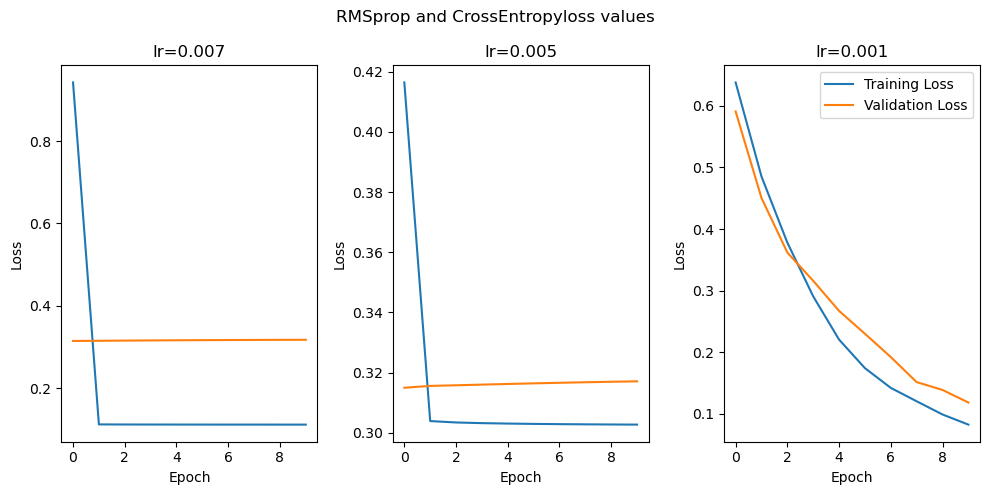

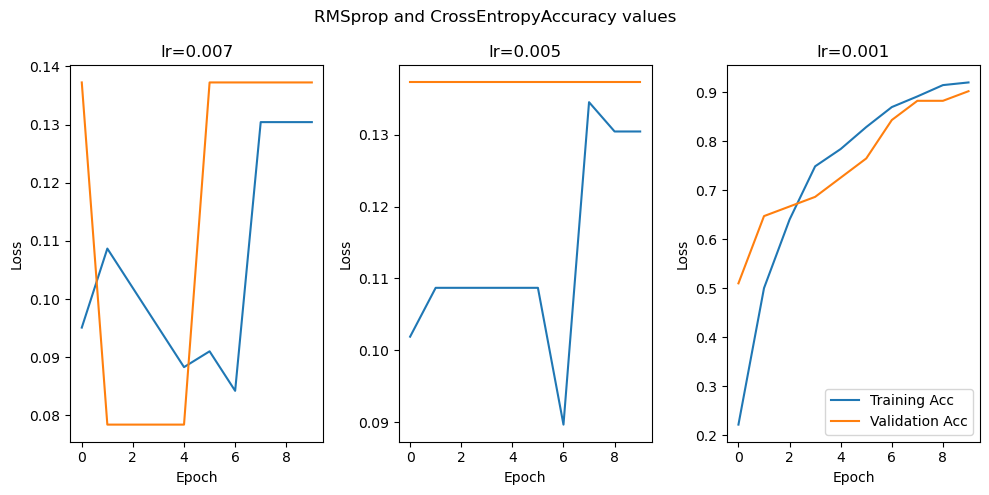

In [77]:
cnn_simple_dos_rms_ce_1, cnn_simple_dos_rms_ce_2, cnn_simple_dos_rms_ce_3 = train_val_model_ev_best_optmizer(CNN_simple, 3, 0, num_classes, X_train_ovs, y_train_ovs, X_val, y_val, criterion_CrossEntropy, 'RMSprop', 10, 'RMSprop and CrossEntropy', patience=10, type='CNN', lr=[0.007,0.005,0.001])

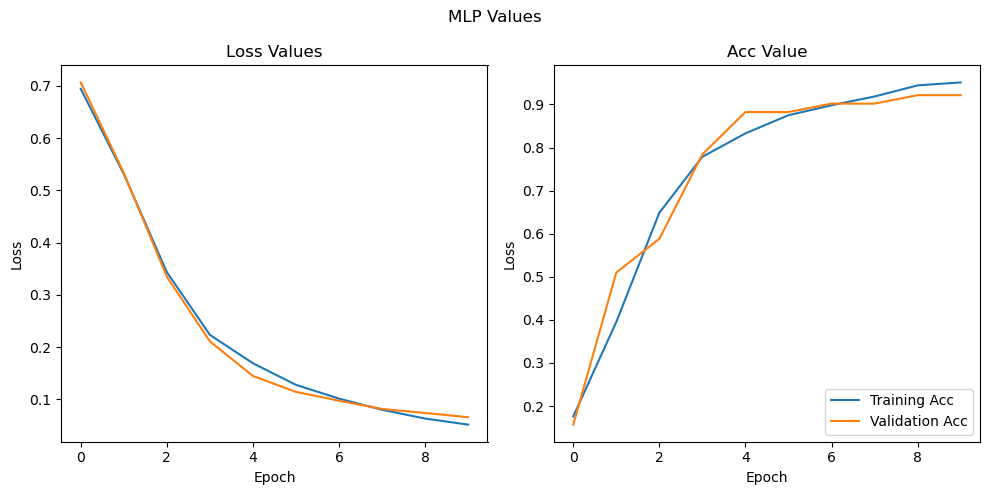

Evaluating with the Training data
Confusion Matrix:
 [[79  0  0  0  0  0  0  0  0]
 [ 0 79  0  0  0  0  0  0  0]
 [ 0  0 79  0  0  0  0  0  0]
 [ 0  0  0 63  0 11  5  0  0]
 [ 0  0  0  0 26 20 33  0  0]
 [ 0  0  0  0  0 79  0  0  0]
 [ 0  0  0  0  0  0 79  0  0]
 [ 0  0  0  0  0  0  0 79  0]
 [ 0  0  0  0  0  0  0  0 79]]
F1 Score:  0.8916292582064994
Accuracy:  0.9029535864978903
Precison:  0.932599499266166
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  2  0  1  1  0  0]
 [ 0  0  0  0  1  1  1  0  0]
 [ 0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  8]]
F1 Score:  0.9166666666666666
Accuracy:  0.9215686274509803
Precison:  0.9568627450980391
Evaluating with the Test data
Confusion Matrix:
 [[14  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  2  0  1  0  0  0]
 [

In [81]:
# lr = 0.001
evaluate_model(cnn_simple_dos_rms_ce_3,X_train_ovs, y_train_ovs, X_val, y_val, X_test, y_test, 'Simple CNN w/ RMSprop, CrossEntropy amd lr = 0.001')

###### **Class Weighting RMSprop and CrossEntropy**

RMSprop and CrossEntropy w/  lr=0.007
Epoch [1/10], Train Loss: 19.0667, Val Loss: 2.1959, Train Acc: 0.1335, Val Acc: 0.1373
Epoch [2/10], Train Loss: 2.2026, Val Loss: 2.1961, Train Acc: 0.1527, Val Acc: 0.1373
Epoch [3/10], Train Loss: 2.2013, Val Loss: 2.1964, Train Acc: 0.1551, Val Acc: 0.1373
Epoch [4/10], Train Loss: 2.2007, Val Loss: 2.1966, Train Acc: 0.1474, Val Acc: 0.1373
Epoch [5/10], Train Loss: 2.2003, Val Loss: 2.1968, Train Acc: 0.1474, Val Acc: 0.1373
Epoch [6/10], Train Loss: 2.2001, Val Loss: 2.1969, Train Acc: 0.1449, Val Acc: 0.1373
Epoch [7/10], Train Loss: 2.1999, Val Loss: 2.1969, Train Acc: 0.1449, Val Acc: 0.0784
Epoch [8/10], Train Loss: 2.1998, Val Loss: 2.1970, Train Acc: 0.1329, Val Acc: 0.0784
Epoch [9/10], Train Loss: 2.1997, Val Loss: 2.1970, Train Acc: 0.1329, Val Acc: 0.0784
Epoch [10/10], Train Loss: 2.1996, Val Loss: 2.1971, Train Acc: 0.1329, Val Acc: 0.0784
RMSprop and CrossEntropy w/  lr=0.005
Epoch [1/10], Train Loss: 4.5592, Val Loss: 2.1671, 

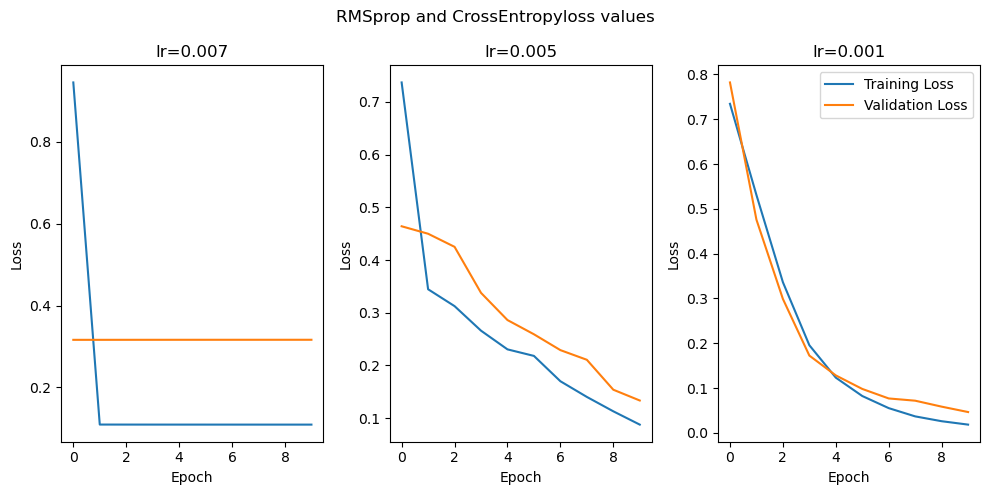

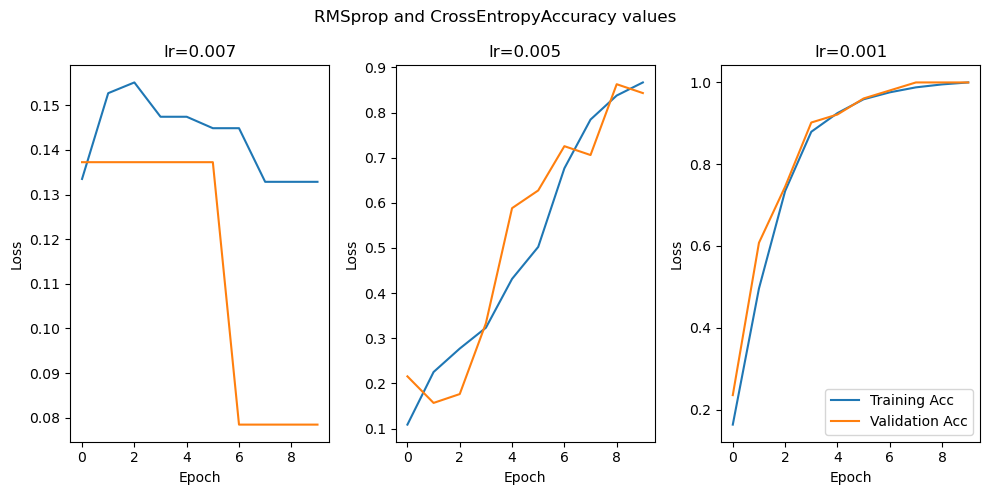

In [74]:
cnn_simple_cw_rms_ce_1, cnn_simple_cw_rms_ce_2, cnn_simple_cw_rms_ce_3 = train_val_model_ev_best_optmizer(CNN_simple, 3, 0, num_classes, X_train, y_train, X_val, y_val, criterion_CrossEntropy_classWeight, 'RMSprop', 10, 'RMSprop and CrossEntropy', patience=10, type='CNN', lr=[0.007,0.005,0.001])

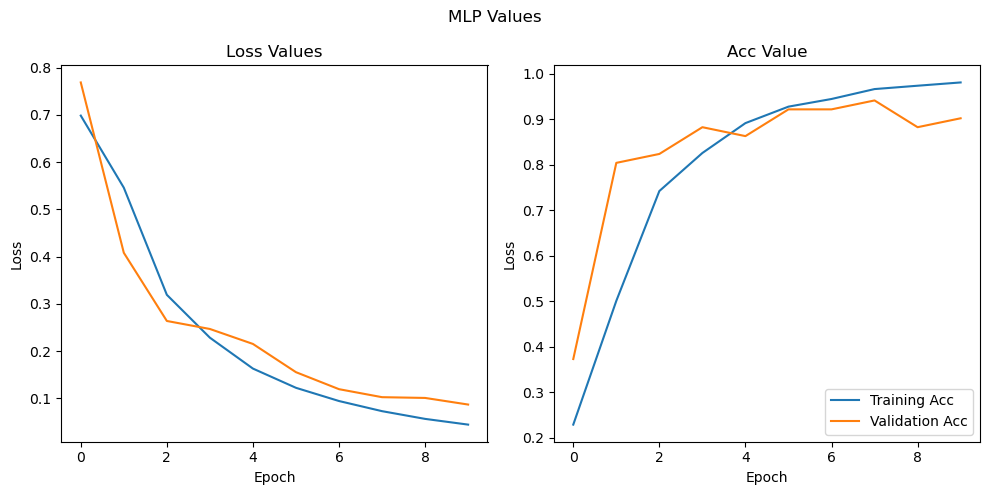

Evaluating with the Training data
Confusion Matrix:
 [[73  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  0  0]
 [ 0  0 79  0  0  0  0  0  0]
 [ 0  0  0 41  8  0  2  0  0]
 [ 0  0  0  0 23  0  0  0  0]
 [ 0  0  0  0 11 15  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  3 37  0]
 [ 0  0  0  0  0  0  0  0 65]]
F1 Score:  0.9442673097313699
Accuracy:  0.9420289855072463
Precison:  0.9648033126293997
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  3  1  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  7  0]
 [ 0  0  0  0  0  0  0  0  8]]
F1 Score:  0.9109161311583458
Accuracy:  0.9019607843137255
Precison:  0.9529411764705883
Evaluating with the Test data
Confusion Matrix:
 [[14  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  2  1  0  0  0  0]
 

In [96]:
# lr = 0.001
evaluate_model(cnn_simple_cw_rms_ce_3,X_train, y_train, X_val, y_val, X_test, y_test, 'Simple CNN w/ CW, RMSprop, CrossEntropy amd lr = 0.001')

###### **Data Oversampling Adam and CrossEntropy**

Adam and CrossEntropy w/ lr=0.007
Epoch [1/10], Train Loss: 2.0389, Val Loss: 2.1153, Train Acc: 0.2160, Val Acc: 0.2157
Epoch [2/10], Train Loss: 2.0027, Val Loss: 1.9006, Train Acc: 0.2459, Val Acc: 0.4510
Epoch [3/10], Train Loss: 1.8505, Val Loss: 1.3360, Train Acc: 0.3117, Val Acc: 0.6078
Epoch [4/10], Train Loss: 1.4198, Val Loss: 0.9579, Train Acc: 0.4934, Val Acc: 0.5686
Epoch [5/10], Train Loss: 1.1331, Val Loss: 0.8128, Train Acc: 0.5642, Val Acc: 0.6667
Epoch [6/10], Train Loss: 0.9726, Val Loss: 0.6489, Train Acc: 0.6044, Val Acc: 0.7451
Epoch [7/10], Train Loss: 1.1593, Val Loss: 0.4014, Train Acc: 0.5223, Val Acc: 0.8824
Epoch [8/10], Train Loss: 0.6374, Val Loss: 0.8845, Train Acc: 0.7269, Val Acc: 0.6863
Epoch [9/10], Train Loss: 0.7079, Val Loss: 0.2688, Train Acc: 0.7283, Val Acc: 0.9020
Epoch [10/10], Train Loss: 0.4796, Val Loss: 0.2587, Train Acc: 0.8084, Val Acc: 0.9020
Adam and CrossEntropy w/ lr=0.005
Epoch [1/10], Train Loss: 2.1722, Val Loss: 2.0182, Train Acc

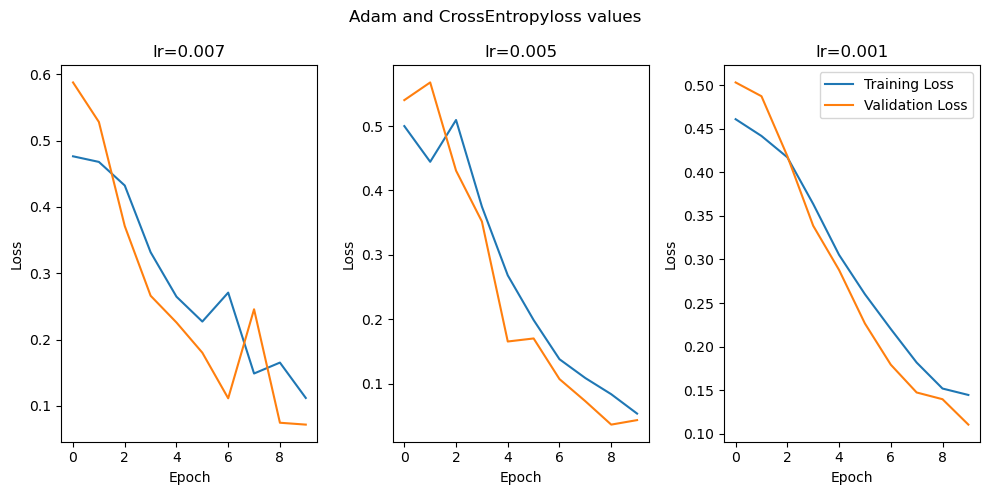

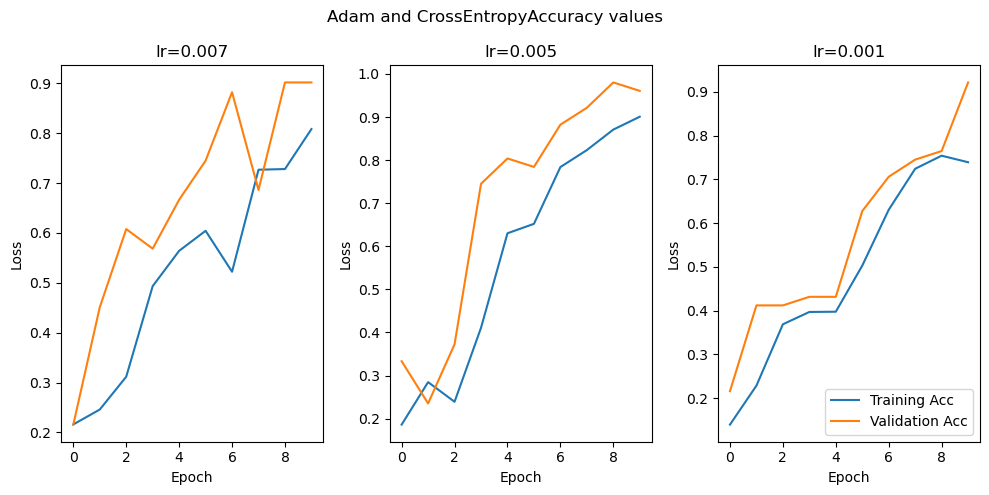

In [100]:
cnn_simple_dos_adam_ce_1, cnn_simple_dos_adam_ce_2, cnn_simple_dos_adam_ce_3 = train_val_model_ev_best_optmizer(CNN_simple, 3, 0, num_classes, X_train_ovs, y_train_ovs, X_val, y_val, criterion_CrossEntropy, 'Adam', 10, 'Adam and CrossEntropy', patience=10, type='CNN', lr=[0.007,0.005,0.001])

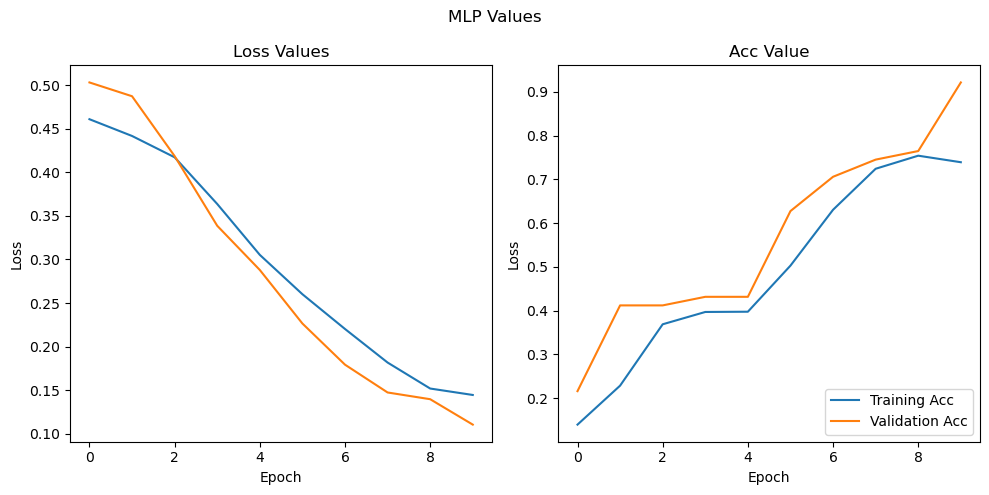

Evaluating with the Training data
Confusion Matrix:
 [[76  0  0  0  0  0  0  0  3]
 [ 0 72  0  0  0  0  0  0  7]
 [ 0  0 79  0  0  0  0  0  0]
 [ 0  0  0 36 33  7  3  0  0]
 [ 0  0  0  0 51 13 10  5  0]
 [ 0  0  0  0 15 64  0  0  0]
 [ 0  0  0 17  0  0 55  7  0]
 [ 0  0  0  0  0  0  0 79  0]
 [ 0  0  0  0  0  0  0  0 79]]
F1 Score:  0.8284710163606215
Accuracy:  0.8312236286919831
Precison:  0.8356552674507757
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  2  2  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  8]]
F1 Score:  0.9200746965452847
Accuracy:  0.9215686274509803
Precison:  0.9527629233511586
Evaluating with the Test data
Confusion Matrix:
 [[14  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  2  1  0  0  0  0]
 

In [102]:
# lr = 0.001
evaluate_model(cnn_simple_dos_adam_ce_3,X_train_ovs, y_train_ovs, X_val, y_val, X_test, y_test, 'Simple CNN w/ Adam, CrossEntropy amd lr = 0.001')

###### **Class Weighting Adam and CrossEntropy**

Adam and CrossEntropy w/ lr=0.007
Epoch [1/8], Train Loss: 24.4341, Val Loss: 2.1259, Train Acc: 0.2253, Val Acc: 0.3137
Epoch [2/8], Train Loss: 22.2362, Val Loss: 1.7760, Train Acc: 0.4034, Val Acc: 0.5098
Epoch [3/8], Train Loss: 17.9534, Val Loss: 1.4183, Train Acc: 0.5758, Val Acc: 0.6078
Epoch [4/8], Train Loss: 13.7919, Val Loss: 0.8256, Train Acc: 0.6623, Val Acc: 0.8431
Epoch [5/8], Train Loss: 8.4853, Val Loss: 0.4854, Train Acc: 0.8191, Val Acc: 0.9216
Epoch [6/8], Train Loss: 4.9599, Val Loss: 0.3615, Train Acc: 0.8795, Val Acc: 0.9216
Epoch [7/8], Train Loss: 3.1036, Val Loss: 0.4414, Train Acc: 0.9276, Val Acc: 0.9216
Epoch [8/8], Train Loss: 1.7866, Val Loss: 0.1489, Train Acc: 0.9638, Val Acc: 0.9608
Adam and CrossEntropy w/ lr=0.005
Epoch [1/8], Train Loss: 24.3614, Val Loss: 2.1288, Train Acc: 0.2005, Val Acc: 0.2745
Epoch [2/8], Train Loss: 22.8283, Val Loss: 1.8102, Train Acc: 0.3894, Val Acc: 0.5490
Epoch [3/8], Train Loss: 16.8233, Val Loss: 1.0127, Train Acc: 0.6

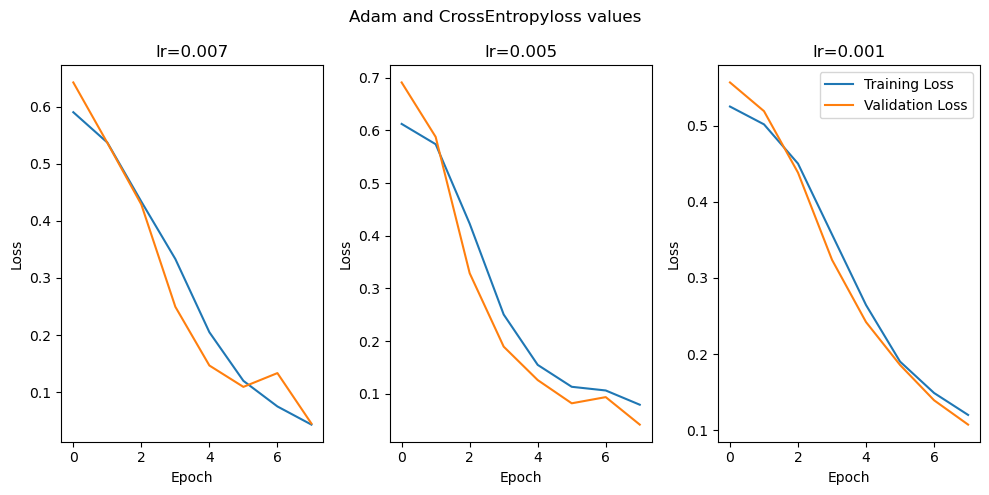

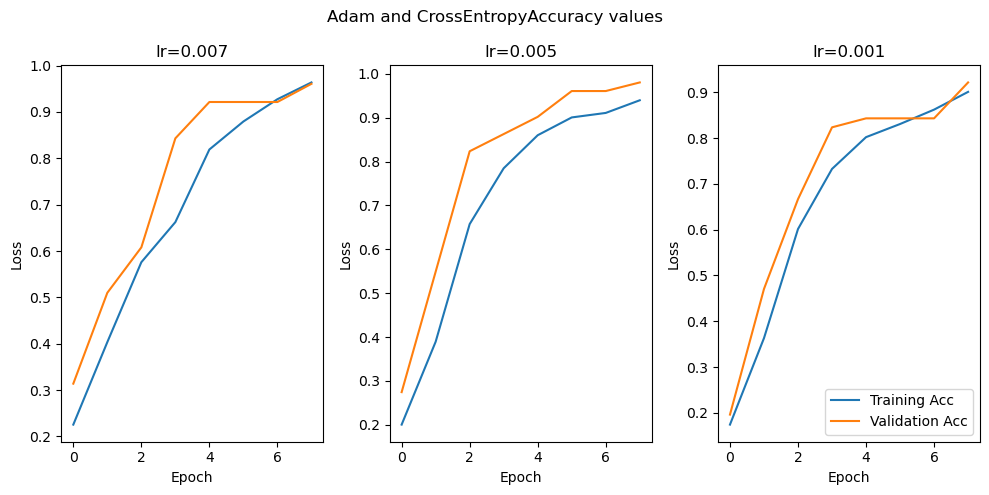

In [117]:
cnn_simple_cw_adam_ce_1, cnn_simple_cw_adam_ce_2, cnn_simple_cw_adam_ce_3 = train_val_model_ev_best_optmizer(CNN_simple, 3, 0, num_classes, X_train, y_train, X_val, y_val, criterion_CrossEntropy_classWeight, 'Adam', 8, 'Adam and CrossEntropy', patience=10, ClassWeights=True, type='CNN')

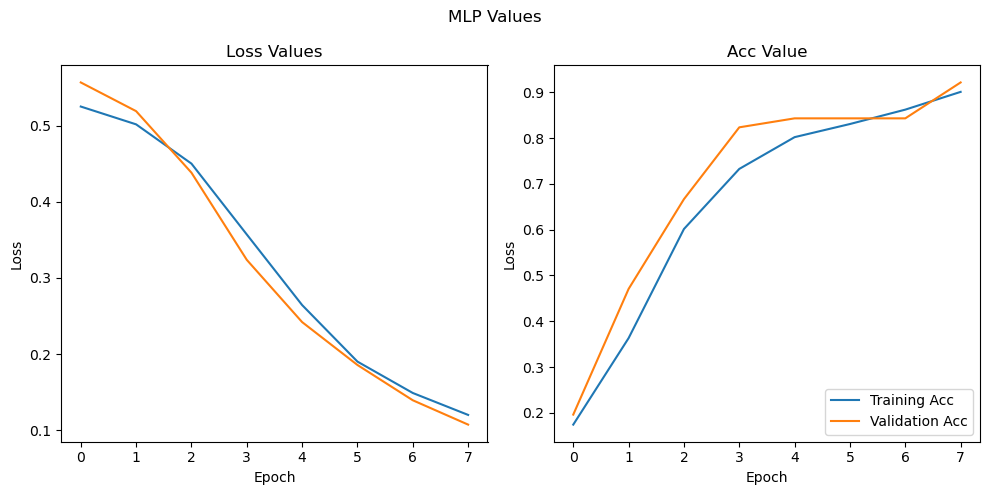

Evaluating with the Training data
Confusion Matrix:
 [[73  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  0  0]
 [ 0  0 79  0  0  0  0  0  0]
 [ 0  0  0 38  0  6  0  7  0]
 [ 0  0  0  0 14  4  1  4  0]
 [ 0  0  0  0  5 21  0  0  0]
 [ 0  0  0  0  0  0 22  3  0]
 [ 0  0  0  0  0  0  0 40  0]
 [ 2  3  0  0  0  0  0  0 60]]
F1 Score:  0.9154147039099088
Accuracy:  0.9154589371980676
Precison:  0.9261193742638304
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  2  1  0  0  0]
 [ 0  0  0  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  1  0  0  0  0  0  0  7]]
F1 Score:  0.9200746965452847
Accuracy:  0.9215686274509803
Precison:  0.9298871063576946
Evaluating with the Test data
Confusion Matrix:
 [[14  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  1  0]
 

In [118]:
# lr = 0.001
evaluate_model(cnn_simple_cw_adam_ce_3,X_train, y_train, X_val, y_val, X_test, y_test, 'Simple CNN w/ CW, Adam, CrossEntropy amd lr = 0.007')

###### **Data Oversampling SGD and CrossEntropy**

SGD and CrossEntropy w/ lr=0.007
Epoch [1/25], Train Loss: 2.2188, Val Loss: 2.1952, Train Acc: 0.1413, Val Acc: 0.1569
Epoch [2/25], Train Loss: 2.2023, Val Loss: 2.1929, Train Acc: 0.1413, Val Acc: 0.1569
Epoch [3/25], Train Loss: 2.1972, Val Loss: 2.1852, Train Acc: 0.1413, Val Acc: 0.1569
Epoch [4/25], Train Loss: 2.1916, Val Loss: 2.1750, Train Acc: 0.1413, Val Acc: 0.1961
Epoch [5/25], Train Loss: 2.1674, Val Loss: 2.1266, Train Acc: 0.1753, Val Acc: 0.2745
Epoch [6/25], Train Loss: 2.1190, Val Loss: 2.1324, Train Acc: 0.1982, Val Acc: 0.3333
Epoch [7/25], Train Loss: 2.0788, Val Loss: 2.1775, Train Acc: 0.2178, Val Acc: 0.4118
Epoch [8/25], Train Loss: 2.0975, Val Loss: 1.8736, Train Acc: 0.2382, Val Acc: 0.2549
Epoch [9/25], Train Loss: 1.9209, Val Loss: 2.1864, Train Acc: 0.2993, Val Acc: 0.0784
Epoch [10/25], Train Loss: 2.2478, Val Loss: 2.2005, Train Acc: 0.1821, Val Acc: 0.0392
Epoch [11/25], Train Loss: 2.2181, Val Loss: 2.1374, Train Acc: 0.1481, Val Acc: 0.1569
Epoch [1

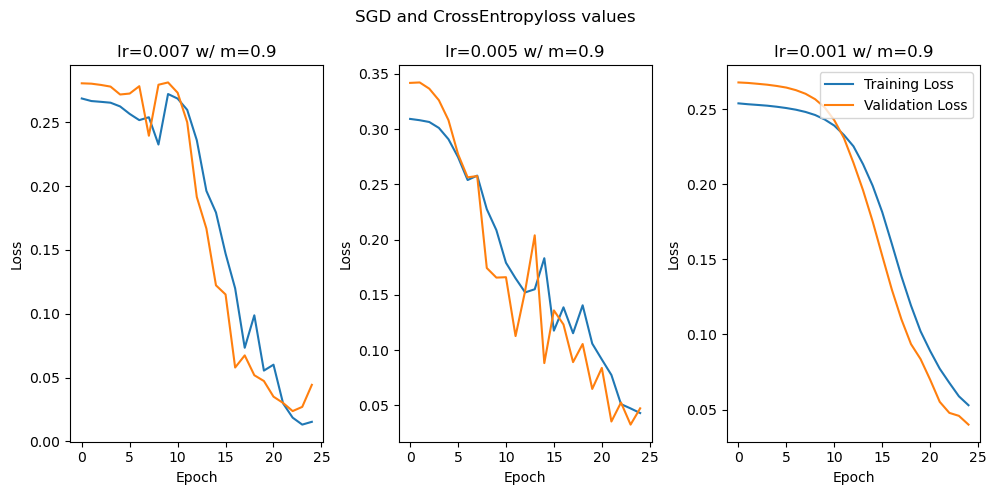

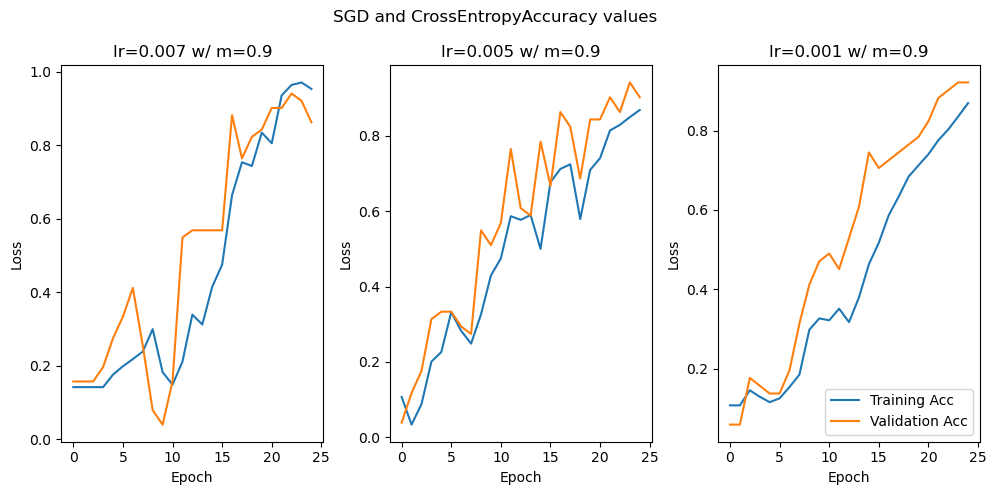

In [130]:
cnn_simple_dos_sgd_ce_1, cnn_simple_dos_sgd_ce_2, cnn_simple_dos_sgd_ce_3 = train_val_model_ev_best_optmizer(CNN_simple, 3, 0, num_classes, X_train_ovs, y_train_ovs, X_val, y_val, criterion_CrossEntropy, 'SGD', 25, 'SGD and CrossEntropy', type='CNN')

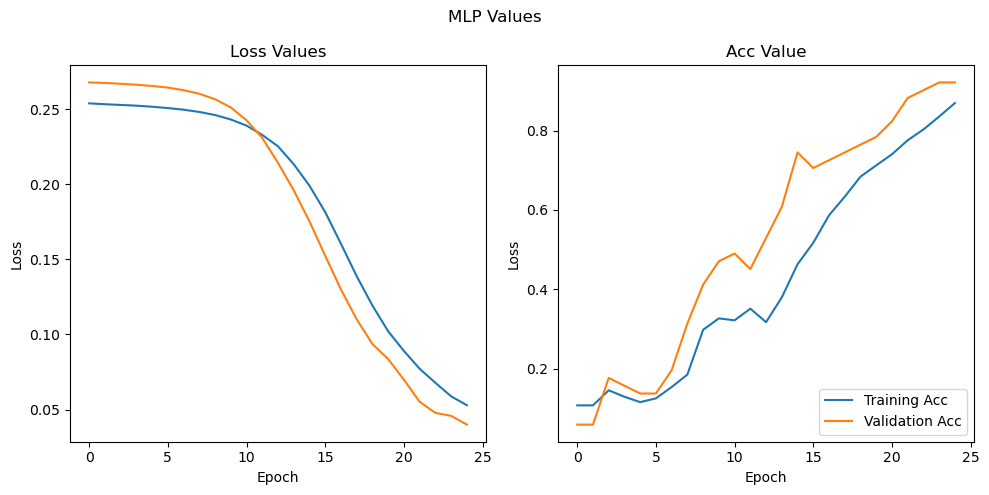

Evaluating with the Training data
Confusion Matrix:
 [[79  0  0  0  0  0  0  0  0]
 [ 0 79  0  0  0  0  0  0  0]
 [ 0  0 79  0  0  0  0  0  0]
 [ 0  0  0 54  0 25  0  0  0]
 [ 0  0  0  0 45 30  0  4  0]
 [ 0  0  0  0  6 73  0  0  0]
 [ 0  0  0  0  4  6 68  1  0]
 [ 0  0  0  0  0  0  0 79  0]
 [ 0  6  0  0  0  0  0  0 73]]
F1 Score:  0.8875060052177418
Accuracy:  0.8846694796061885
Precison:  0.9147606547518751
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  1  1  0  1  0]
 [ 0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  1  0  0  1  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  8]]
F1 Score:  0.8992615227909346
Accuracy:  0.9215686274509803
Precison:  0.8839869281045752
Evaluating with the Test data
Confusion Matrix:
 [[14  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  2  0  1  0  0  0]
 

c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
# lr = 0.001
evaluate_model(cnn_simple_dos_sgd_ce_3,X_train_ovs, y_train_ovs, X_val, y_val, X_test, y_test, 'Simple CNN w/ SGD, CrossEntropy amd lr = 0.001')

###### **Class Weighting SGD and CrossEntropy**

SGD and CrossEntropy w/ lr=0.007
Epoch [1/15], Train Loss: 24.2445, Val Loss: 2.1642, Train Acc: 0.1668, Val Acc: 0.1765
Epoch [2/15], Train Loss: 23.7414, Val Loss: 1.9721, Train Acc: 0.2851, Val Acc: 0.3922
Epoch [3/15], Train Loss: 22.9004, Val Loss: 2.0867, Train Acc: 0.2824, Val Acc: 0.3137
Epoch [4/15], Train Loss: 20.3309, Val Loss: 1.4295, Train Acc: 0.3825, Val Acc: 0.5686
Epoch [5/15], Train Loss: 18.4494, Val Loss: 1.6026, Train Acc: 0.3915, Val Acc: 0.5098
Epoch [6/15], Train Loss: 18.0134, Val Loss: 1.6735, Train Acc: 0.4095, Val Acc: 0.7059
Epoch [7/15], Train Loss: 13.5189, Val Loss: 3.0244, Train Acc: 0.6790, Val Acc: 0.8235
Epoch [8/15], Train Loss: 19.4349, Val Loss: 0.9948, Train Acc: 0.5386, Val Acc: 0.6863
Epoch [9/15], Train Loss: 18.4813, Val Loss: 1.4014, Train Acc: 0.4330, Val Acc: 0.4706
Epoch [10/15], Train Loss: 18.1877, Val Loss: 1.9971, Train Acc: 0.4995, Val Acc: 0.2941
Epoch [11/15], Train Loss: 21.9031, Val Loss: 2.2291, Train Acc: 0.3495, Val Acc: 0.07

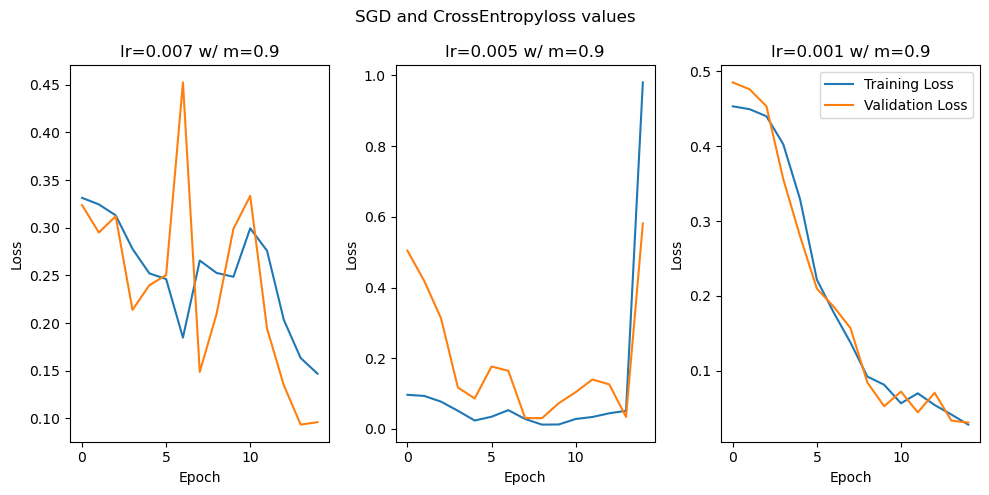

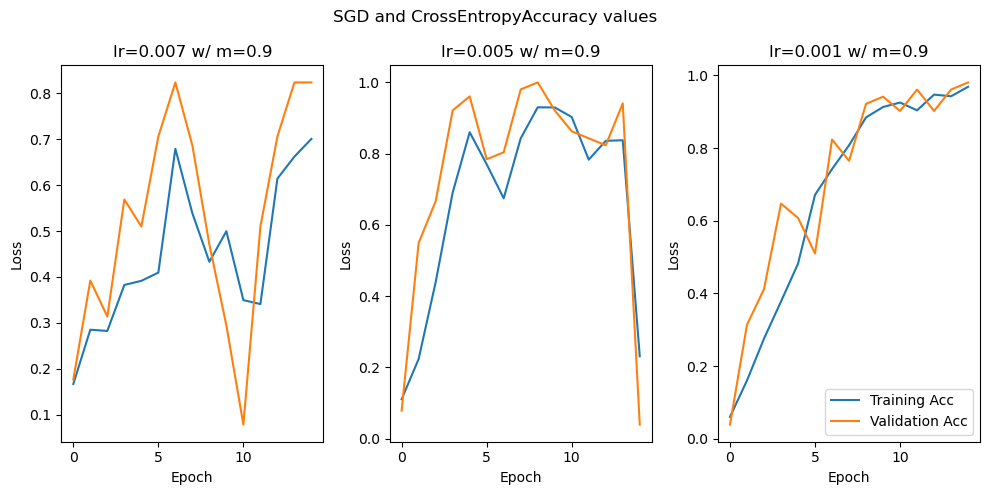

In [135]:
cnn_simple_cw_sgd_ce_1, cnn_simple_cw_sgd_ce_2, cnn_simple_cw_sgd_ce_3 = train_val_model_ev_best_optmizer(CNN_simple, 3, 0, num_classes, X_train, y_train, X_val, y_val, criterion_CrossEntropy_classWeight, 'SGD', 15, 'SGD and CrossEntropy', patience=10, ClassWeights=True, type='CNN')

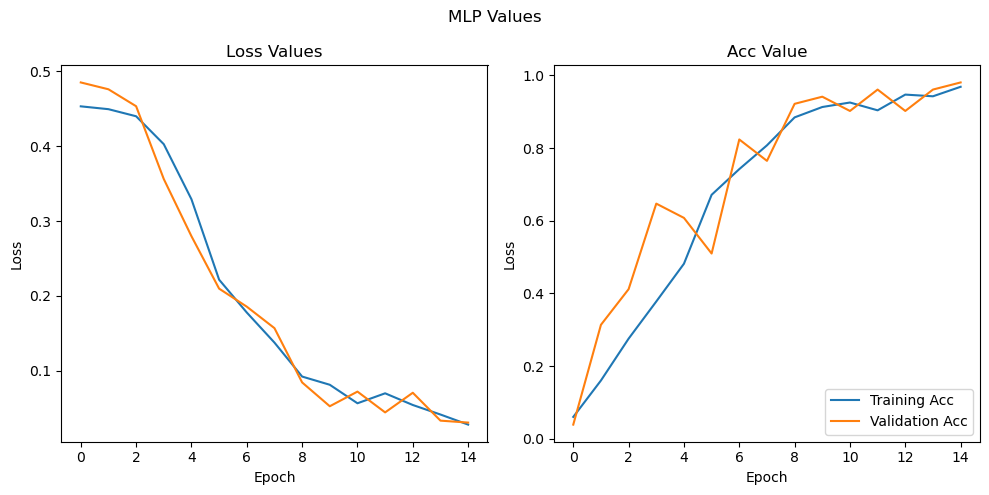

Evaluating with the Training data
Confusion Matrix:
 [[73  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  0  0]
 [ 0  0 79  0  0  0  0  0  0]
 [ 0  0  0 45  0  6  0  0  0]
 [ 0  0  0  0 23  0  0  0  0]
 [ 0  0  0  0  3 23  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 40  0]
 [ 0  0  0  0  0  0  0  0 65]]
F1 Score:  0.9786226842515662
Accuracy:  0.9782608695652174
Precison:  0.9805962403413677
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  8]]
F1 Score:  0.9798319327731093
Accuracy:  0.9803921568627451
Precison:  0.9852941176470589
Evaluating with the Test data
Confusion Matrix:
 [[14  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0]
 

In [136]:
# lr = 0.001
evaluate_model(cnn_simple_cw_sgd_ce_3, X_train, y_train, X_val, y_val, X_test, y_test, 'Simple CNN w/ SGD, CrossEntropy amd lr = 0.001')

###### **Plot the results**

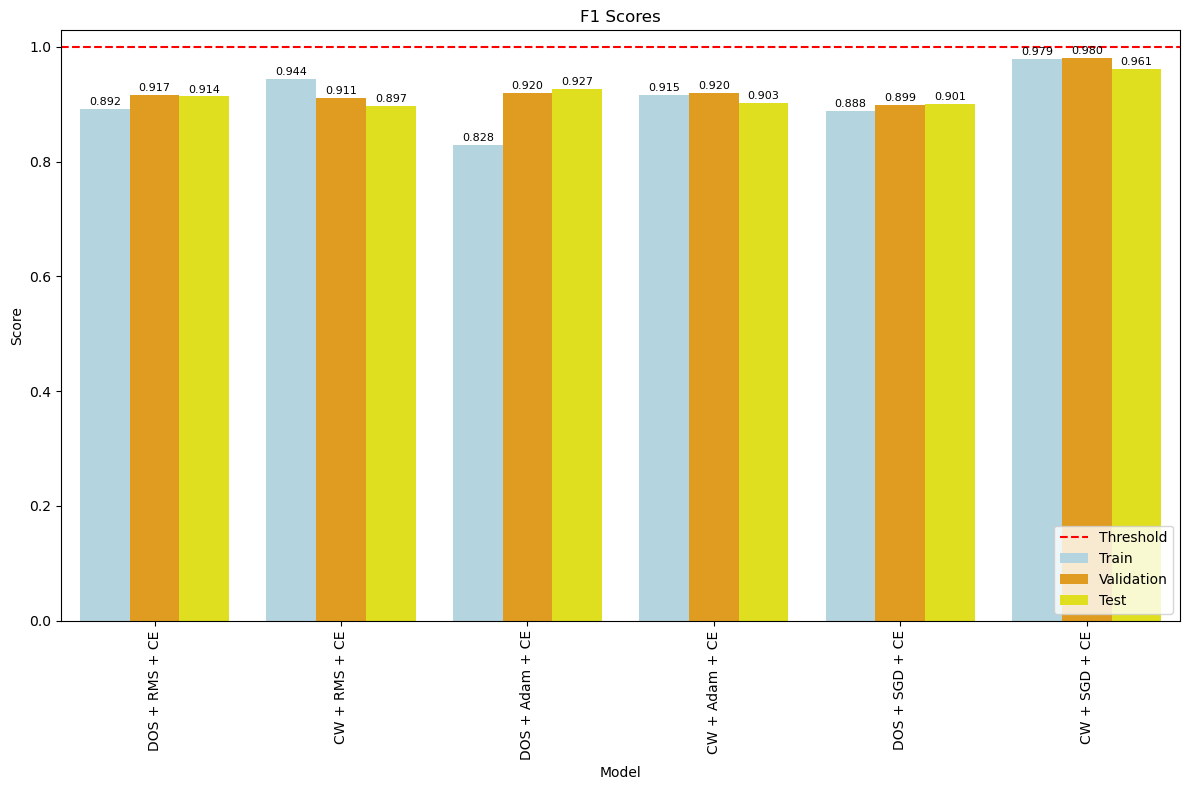

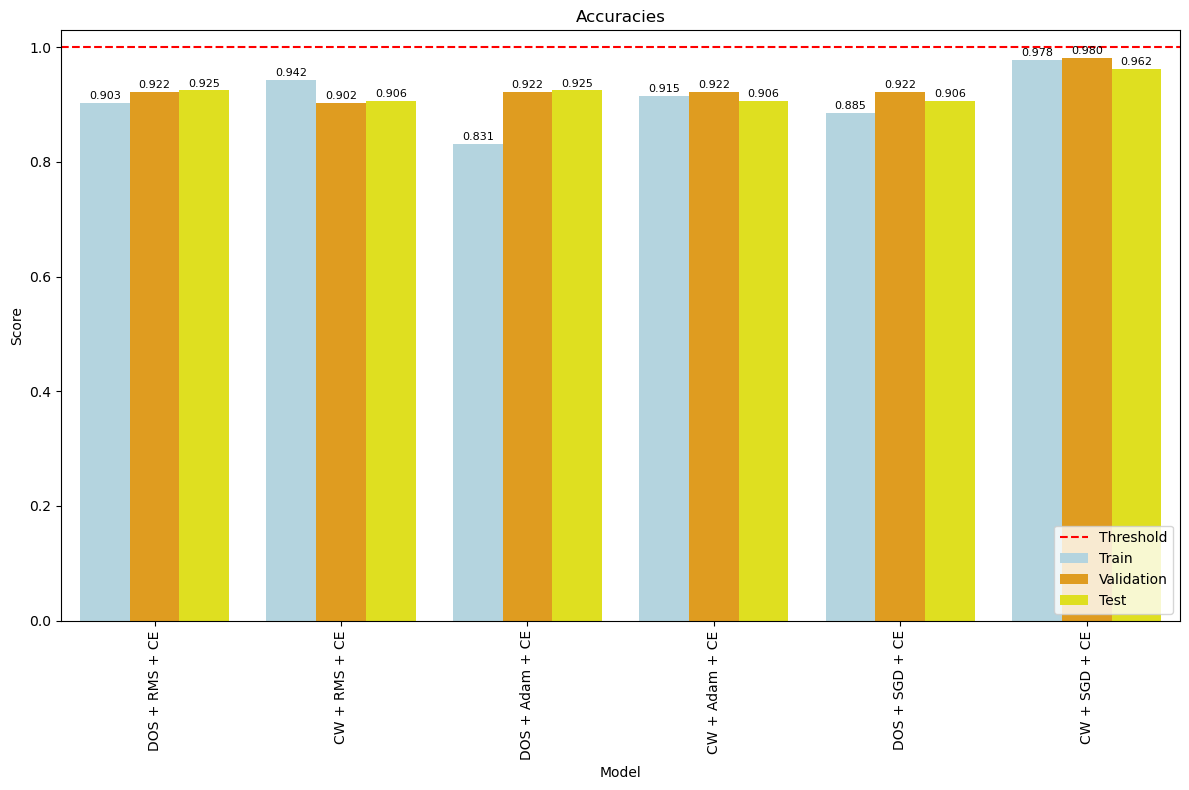

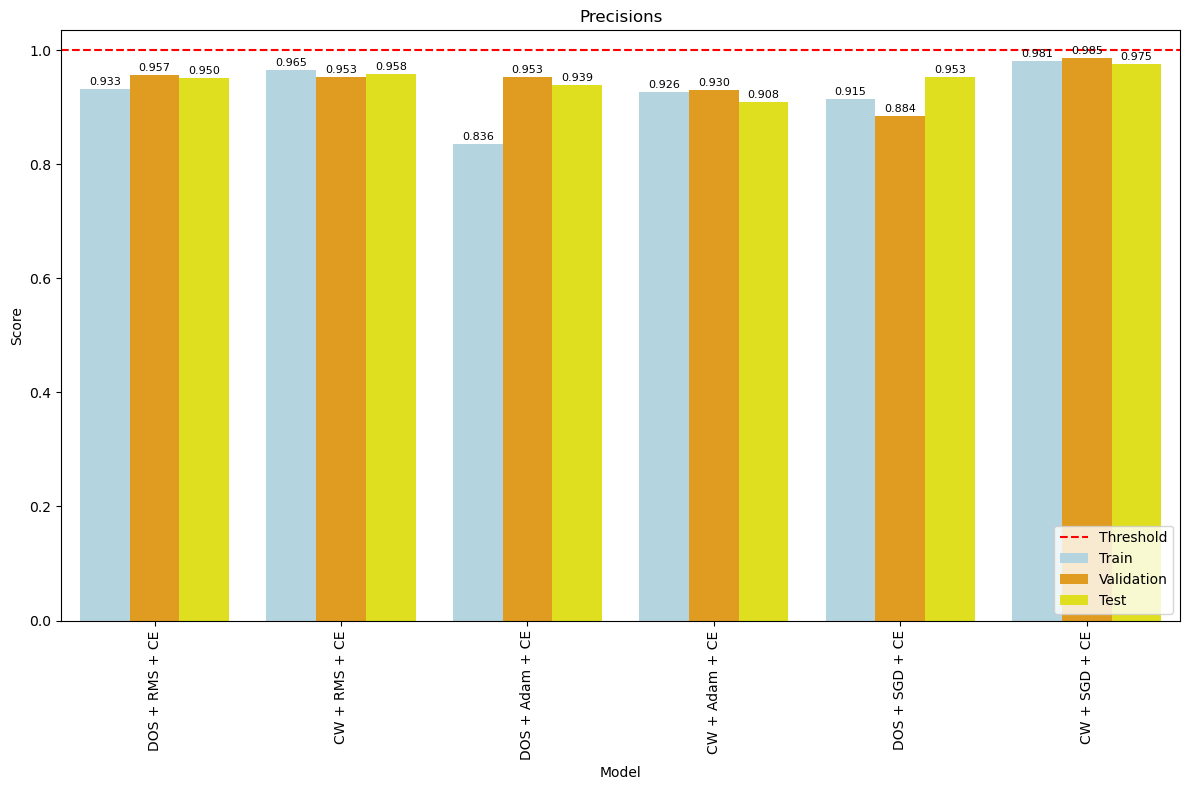

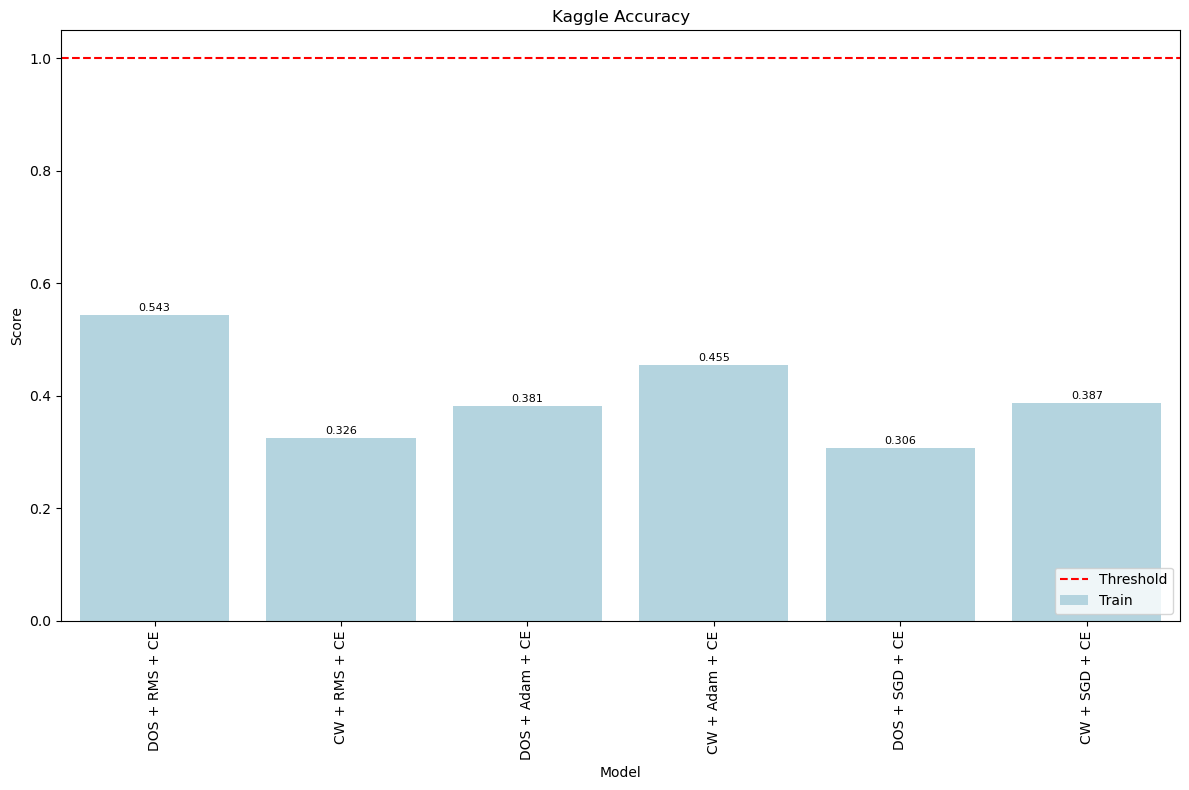

In [51]:
labels = ["DOS + RMS + CE", "CW + RMS + CE", "DOS + Adam + CE", "CW + Adam + CE", "DOS + SGD + CE", "CW + SGD + CE"]
f1_scores_train = [0.8916292582064994, 0.9442673097313699, 0.8284710163606215, 0.9154147039099088, 0.8875060052177418, 0.9786226842515662]
f1_scores_validation = [0.9166666666666666, 0.9109161311583458, 0.9200746965452847, 0.9200746965452847, 0.8992615227909346, 0.9798319327731093]
f1_scores_test = [0.9135220125786163, 0.8967585873246251, 0.9270440251572327, 0.9027023291174233, 0.9006289308176101, 0.9613207547169812]

accuracy_train = [0.9029535864978903, 0.9420289855072463, 0.8312236286919831, 0.9154589371980676, 0.8846694796061885, 0.9782608695652174]
accuracy_validation = [0.9215686274509803, 0.9019607843137255, 0.9215686274509803, 0.9215686274509803, 0.9215686274509803, 0.9803921568627451]
accuracy_test = [0.9245283018867925, 0.9056603773584906, 0.9245283018867925, 0.9056603773584906, 0.9056603773584906, 0.9622641509433962]

precision_train = [0.932599499266166, 0.9648033126293997, 0.8356552674507757, 0.9261193742638304, 0.9147606547518751, 0.9805962403413677]
precision_validation = [0.9568627450980391, 0.9529411764705883, 0.9527629233511586, 0.9298871063576946, 0.8839869281045752, 0.9852941176470589]
precision_test = [0.9504043126684635, 0.9580712788259959, 0.9386792452830188, 0.9083557951482479, 0.9528301886792453, 0.9748427672955975]

accuracy_kaggle = [0.54321, 0.32555, 0.38136, 0.45472, 0.30633, 0.38736]

# F1_score Plot
plot_results(labels, f1_scores_train, f1_scores_validation, f1_scores_test, 'F1 Scores')

# Accuracy Plot
plot_results(labels, accuracy_train, accuracy_validation, accuracy_test, 'Accuracies')

# Precision Plot
plot_results(labels, precision_train, precision_validation, precision_test, 'Precisions')

# Kaggle Accuracy Plot
plot_results(labels, accuracy_kaggle, title='Kaggle Accuracy',n_values=1)

###### **Save the results**

In [88]:
save_file(cnn_simple_dos_rms_ce_3[2], id_kaggle, x_kaggle_1,'simple_cnn_rms_ce_dos.csv')

In [97]:
save_file(cnn_simple_cw_rms_ce_3[2], id_kaggle, x_kaggle_1,'simple_cnn_rms_ce_cw.csv')

In [103]:
save_file(cnn_simple_dos_adam_ce_3[2], id_kaggle, x_kaggle_1,'simple_cnn_adam_ce_dos.csv')

In [119]:
save_file(cnn_simple_cw_adam_ce_3[2], id_kaggle, x_kaggle_1,'simple_cnn_adam_ce_cw.csv')

In [132]:
save_file(cnn_simple_dos_sgd_ce_3[2], id_kaggle, x_kaggle_1,'simple_cnn_sgd_ce_dos.csv')

In [138]:
save_file(cnn_simple_cw_sgd_ce_3[2], id_kaggle, x_kaggle_1,'simple_cnn_sgd_ce_cw.csv')

##### **iii - VGG inspired CNN**

###### **Architecture**

In [50]:
class VGG(nn.Module):
    def __init__(self, input_channels=3, num_classes=9):
        super(VGG, self).__init__()

        # Input layer
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)  # 64 filters, 3x3 kernel
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2

        # Second convolutional block
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 filters
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2

        # Third convolutional block (optional)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2
        )
        
        # Fully-connected layers
        self.fc1 = nn.Linear(256 * 9 * 9, 512)  
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)

        x = self.conv3(x)  

        # Flatten for fully-connected layers
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

###### **Data Oversampling RMSprop and CrossEntropy**

RMSprop and CrossEntropy w/  lr=0.001
Epoch [1/10], Train Loss: 35.2875, Val Loss: 3.0177, Train Acc: 0.3098, Val Acc: 0.4314
Epoch [2/10], Train Loss: 1.8597, Val Loss: 1.1664, Train Acc: 0.5380, Val Acc: 0.6275
Epoch [3/10], Train Loss: 1.2128, Val Loss: 0.7462, Train Acc: 0.6223, Val Acc: 0.7451
Epoch [4/10], Train Loss: 0.8767, Val Loss: 0.4680, Train Acc: 0.7024, Val Acc: 0.8235
Epoch [5/10], Train Loss: 0.7439, Val Loss: 0.4200, Train Acc: 0.7215, Val Acc: 0.8824
Epoch [6/10], Train Loss: 0.6368, Val Loss: 1.1413, Train Acc: 0.7826, Val Acc: 0.6667
Epoch [7/10], Train Loss: 0.6774, Val Loss: 0.2604, Train Acc: 0.7840, Val Acc: 0.8824
Epoch [8/10], Train Loss: 0.4278, Val Loss: 0.2767, Train Acc: 0.8315, Val Acc: 0.8824
Epoch [9/10], Train Loss: 0.4293, Val Loss: 0.3522, Train Acc: 0.8682, Val Acc: 0.8627
Epoch [10/10], Train Loss: 0.4135, Val Loss: 1.8700, Train Acc: 0.8709, Val Acc: 0.6667
RMSprop and CrossEntropy w/  lr=0.0001
Epoch [1/10], Train Loss: 4.6396, Val Loss: 2.5041,

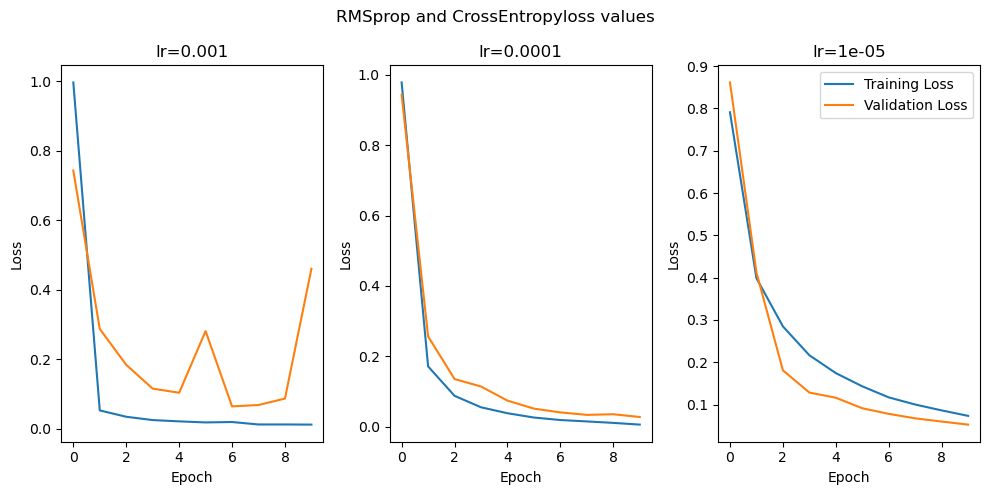

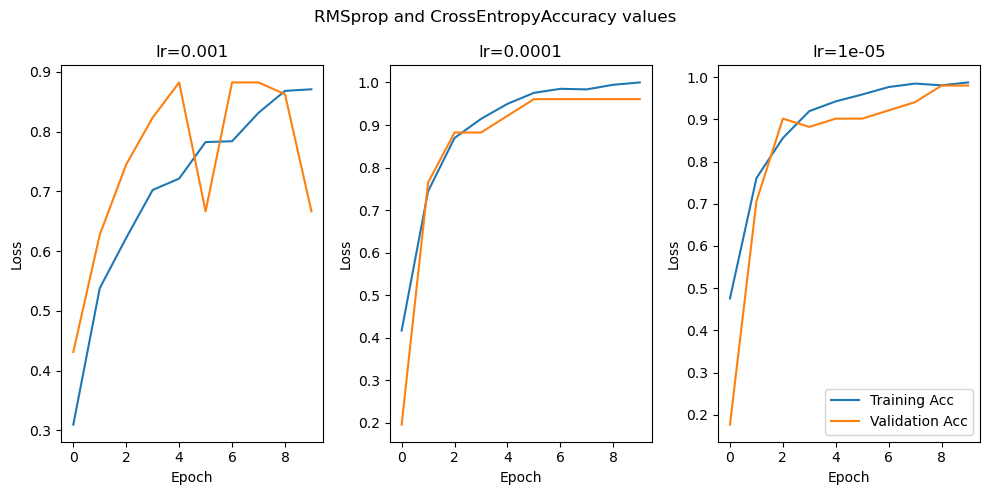

In [65]:
vgg_dos_rms_ce_1, vgg_dos_rms_ce_2, vgg_dos_rms_ce_3 = train_val_model_ev_best_optmizer(VGG, 3, 0, num_classes, X_train_ovs, y_train_ovs, X_val, y_val, criterion_CrossEntropy, 'RMSprop', 10, 'RMSprop and CrossEntropy', patience=5, type='CNN', lr=[0.001,0.0001,0.00001])

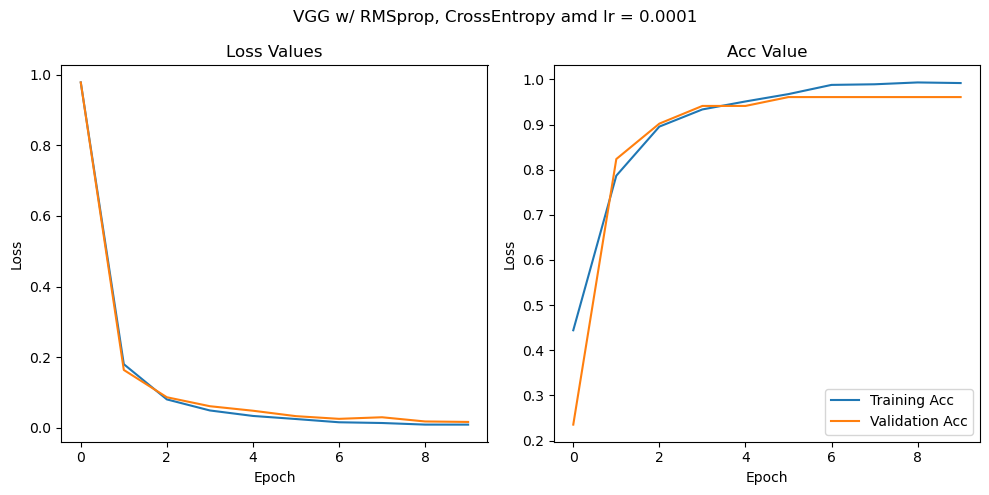

Evaluating with the Training data
Confusion Matrix:
 [[80  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0]
 [ 0  0  0 78  0  2  0  0  0]
 [ 0  0  0  0 80  0  0  0  0]
 [ 0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0  0  0 80]]
F1 Score:  0.9972217881266171
Accuracy:  0.9972222222222222
Precison:  0.997289972899729
Evaluating with the Validation data
Confusion Matrix:
 [[ 7  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9607843137254902
Accuracy:  0.9607843137254902
Precison:  0.9803921568627451
Evaluating with the Test data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0]
 [

In [63]:
# lr = 0.0001
evaluate_model(vgg_dos_rms_ce_2, X_train_ovs, y_train_ovs, X_val, y_val, X_test, y_test, 'VGG w/ RMSprop, CrossEntropy amd lr = 0.0001')

###### **Class Weighting RMSprop and CrossEntropy**

RMSprop and CrossEntropy w/  lr=0.001
Epoch [1/9], Train Loss: 63.5086, Val Loss: 2.2417, Train Acc: 0.2551, Val Acc: 0.4510
Epoch [2/9], Train Loss: 2.7607, Val Loss: 2.4173, Train Acc: 0.6377, Val Acc: 0.2941
Epoch [3/9], Train Loss: 1.5163, Val Loss: 1.5800, Train Acc: 0.8067, Val Acc: 0.4314
Epoch [4/9], Train Loss: 1.1391, Val Loss: 0.9477, Train Acc: 0.8550, Val Acc: 0.7255
Epoch [5/9], Train Loss: 0.5402, Val Loss: 0.2314, Train Acc: 0.8841, Val Acc: 0.9608
Epoch [6/9], Train Loss: 0.3732, Val Loss: 0.1965, Train Acc: 0.9276, Val Acc: 0.9412
Epoch [7/9], Train Loss: 0.3196, Val Loss: 0.1155, Train Acc: 0.9176, Val Acc: 0.9608
Epoch [8/9], Train Loss: 0.2160, Val Loss: 0.0958, Train Acc: 0.9468, Val Acc: 1.0000
Epoch [9/9], Train Loss: 0.1893, Val Loss: 0.0745, Train Acc: 0.9566, Val Acc: 1.0000
RMSprop and CrossEntropy w/  lr=0.0001
Epoch [1/9], Train Loss: 5.5191, Val Loss: 2.9112, Train Acc: 0.3873, Val Acc: 0.0784
Epoch [2/9], Train Loss: 0.7439, Val Loss: 3.2878, Train Acc: 

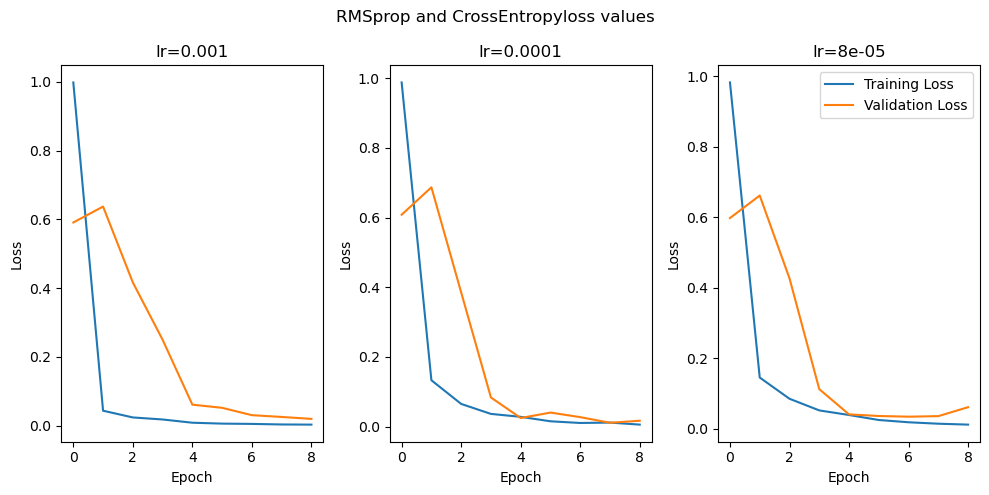

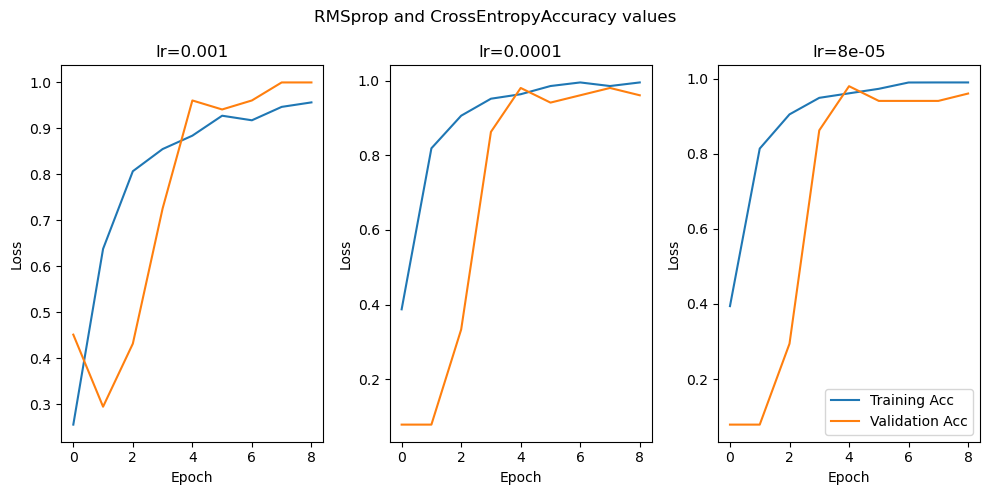

In [92]:
vgg_cw_rms_ce_1, vgg_cw_rms_ce_2, vgg_cw_rms_ce_3 = train_val_model_ev_best_optmizer(VGG, 3, 0, num_classes, X_train, y_train, X_val, y_val, criterion_CrossEntropy_classWeight, 'RMSprop', 9, 'RMSprop and CrossEntropy', patience=5, type='CNN', lr=[0.001,0.0001,0.00008])

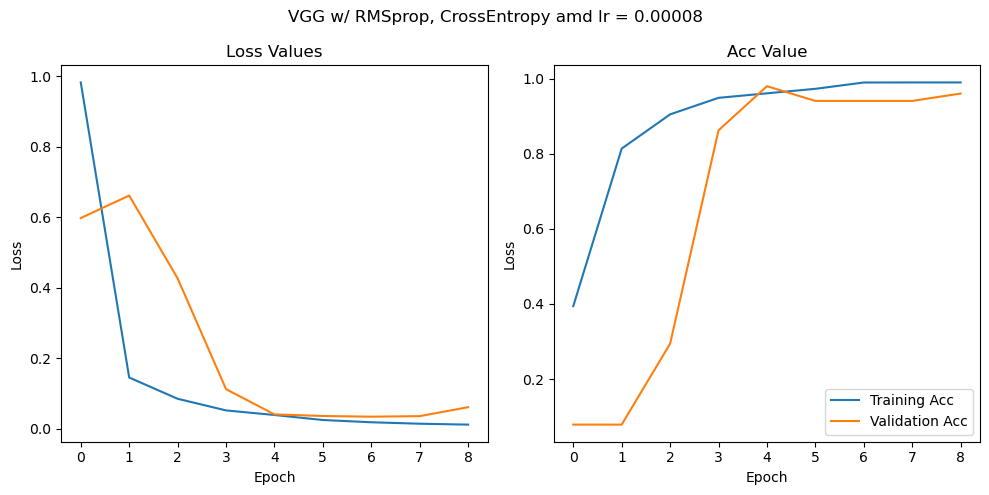

Evaluating with the Training data
Confusion Matrix:
 [[80  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0]
 [ 0  0  0 78  2  0  0  0  0]
 [ 0  0  0  0 80  0  0  0  0]
 [ 0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0  0  0 80]]
F1 Score:  0.9972217881266171
Accuracy:  0.9972222222222222
Precison:  0.997289972899729
Evaluating with the Validation data
Confusion Matrix:
 [[ 7  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9607843137254902
Accuracy:  0.9607843137254902
Precison:  0.9803921568627451
Evaluating with the Test data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  6  1  0  0  0  0]
 [

In [97]:
# lr = 0.00008
evaluate_model(vgg_cw_rms_ce_3, X_train_ovs, y_train_ovs, X_val, y_val, X_test, y_test, 'VGG w/ RMSprop, CrossEntropy amd lr = 0.00008')

###### **Data Oversampling Adam and CrossEntropy**

Adam and CrossEntropy w/  lr=0.01
Epoch [1/10], Train Loss: 56.3659, Val Loss: 9.7207, Train Acc: 0.2690, Val Acc: 0.3137
Epoch [2/10], Train Loss: 2.4009, Val Loss: 1.9024, Train Acc: 0.2527, Val Acc: 0.3922
Epoch [3/10], Train Loss: 1.8530, Val Loss: 1.2350, Train Acc: 0.2568, Val Acc: 0.5686
Epoch [4/10], Train Loss: 1.7991, Val Loss: 1.1899, Train Acc: 0.3111, Val Acc: 0.6078
Epoch [5/10], Train Loss: 1.8296, Val Loss: 1.0464, Train Acc: 0.3288, Val Acc: 0.6471
Epoch [6/10], Train Loss: 1.7052, Val Loss: 1.0128, Train Acc: 0.3764, Val Acc: 0.7059
Epoch [7/10], Train Loss: 1.6305, Val Loss: 1.0028, Train Acc: 0.3709, Val Acc: 0.7647
Epoch [8/10], Train Loss: 1.6266, Val Loss: 0.9222, Train Acc: 0.3899, Val Acc: 0.7451
Epoch [9/10], Train Loss: 1.5833, Val Loss: 0.7408, Train Acc: 0.4117, Val Acc: 0.7059
Epoch [10/10], Train Loss: 1.5215, Val Loss: 0.9681, Train Acc: 0.3913, Val Acc: 0.7647
Adam and CrossEntropy w/  lr=0.005
Epoch [1/10], Train Loss: 28.4429, Val Loss: 8.8469, Train 

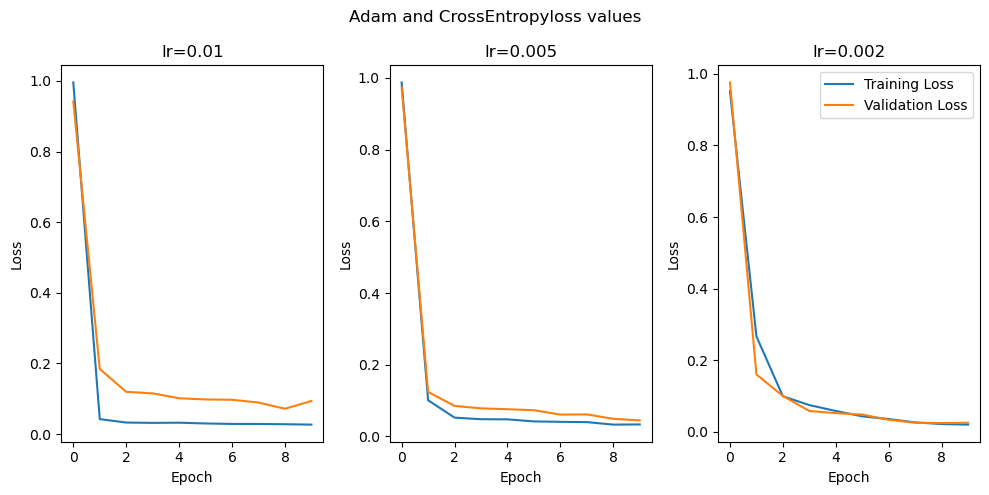

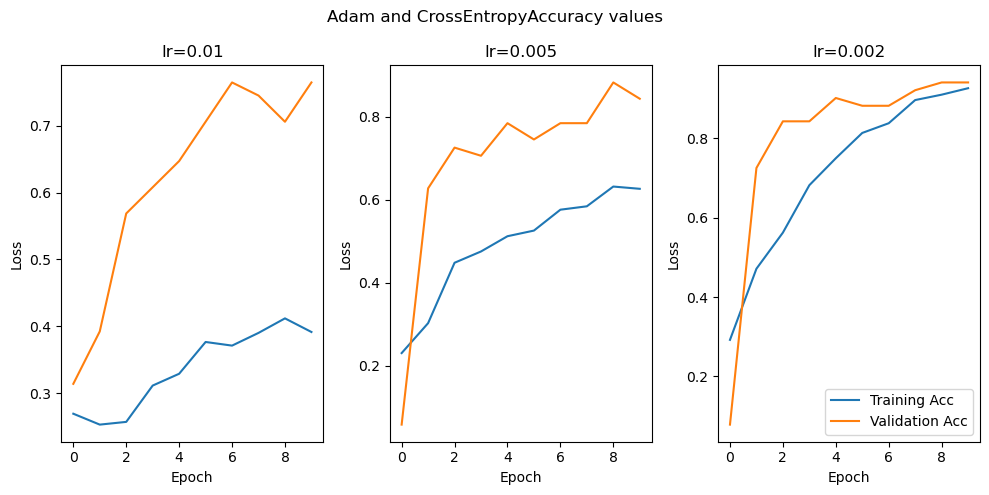

In [105]:
vgg_dos_adam_ce_1, vgg_dos_adam_ce_2, vgg_dos_adam_ce_3 = train_val_model_ev_best_optmizer(VGG, 3, 0, num_classes, X_train_ovs, y_train_ovs, X_val, y_val, criterion_CrossEntropy, 'Adam', 10, 'Adam and CrossEntropy', patience=5, type='CNN', lr=[0.01,0.005,0.002])

In [ ]:
# For the VGG model using Adam might lead to the model not learning a lot from the data, leading to a undersampling

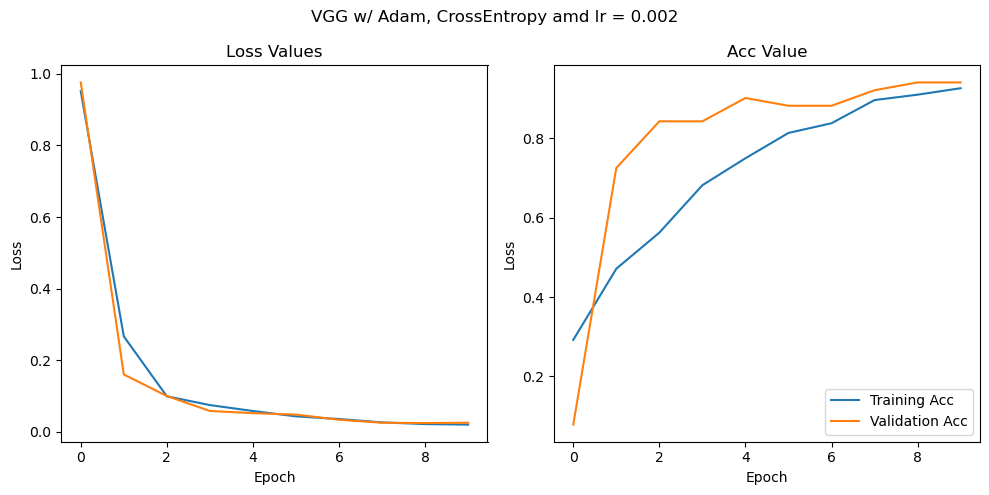

Evaluating with the Training data
Confusion Matrix:
 [[79  0  0  0  0  0  0  0  1]
 [ 0 80  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0]
 [ 0  0  0 78  0  2  0  0  0]
 [ 0  0  0  0 77  3  0  0  0]
 [ 0  0  0  4  0 76  0  0  0]
 [ 0  0  0  0  0  4 76  0  0]
 [ 0  0  0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0  0  0 80]]
F1 Score:  0.9807694766643287
Accuracy:  0.9805555555555555
Precison:  0.9814434978046223
Evaluating with the Validation data
Confusion Matrix:
 [[ 7  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  1  3  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9361344537815127
Accuracy:  0.9411764705882353
Precison:  0.9764705882352941
Evaluating with the Test data
Confusion Matrix:
 [[ 8  0  0  0  0  0  0  0  1]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0]
 

In [106]:
# lr = 0.002
evaluate_model(vgg_dos_adam_ce_3,X_train_ovs, y_train_ovs, X_val, y_val, X_test, y_test, 'VGG w/ Adam, CrossEntropy amd lr = 0.002')

###### **Class Weighting Adam and CrossEntropy**

Adam and CrossEntropy w/  lr=0.001
Epoch [1/10], Train Loss: 67.7085, Val Loss: 3.2602, Train Acc: 0.3899, Val Acc: 0.0588
Epoch [2/10], Train Loss: 10.9780, Val Loss: 3.7093, Train Acc: 0.7657, Val Acc: 0.1373
Epoch [3/10], Train Loss: 5.4100, Val Loss: 2.2330, Train Acc: 0.8889, Val Acc: 0.1961
Epoch [4/10], Train Loss: 2.9422, Val Loss: 0.4429, Train Acc: 0.9397, Val Acc: 0.9216
Epoch [5/10], Train Loss: 2.0985, Val Loss: 0.1673, Train Acc: 0.9588, Val Acc: 0.9412
Epoch [6/10], Train Loss: 1.3284, Val Loss: 0.1104, Train Acc: 0.9663, Val Acc: 0.9804
Epoch [7/10], Train Loss: 1.0003, Val Loss: 0.0543, Train Acc: 0.9808, Val Acc: 1.0000
Epoch [8/10], Train Loss: 0.8715, Val Loss: 0.1114, Train Acc: 0.9832, Val Acc: 0.9608
Epoch [9/10], Train Loss: 0.5605, Val Loss: 0.0131, Train Acc: 0.9928, Val Acc: 1.0000
Epoch [10/10], Train Loss: 0.5647, Val Loss: 0.1243, Train Acc: 0.9926, Val Acc: 0.9608
Adam and CrossEntropy w/  lr=0.0006
Epoch [1/10], Train Loss: 42.2374, Val Loss: 2.8254, Tra

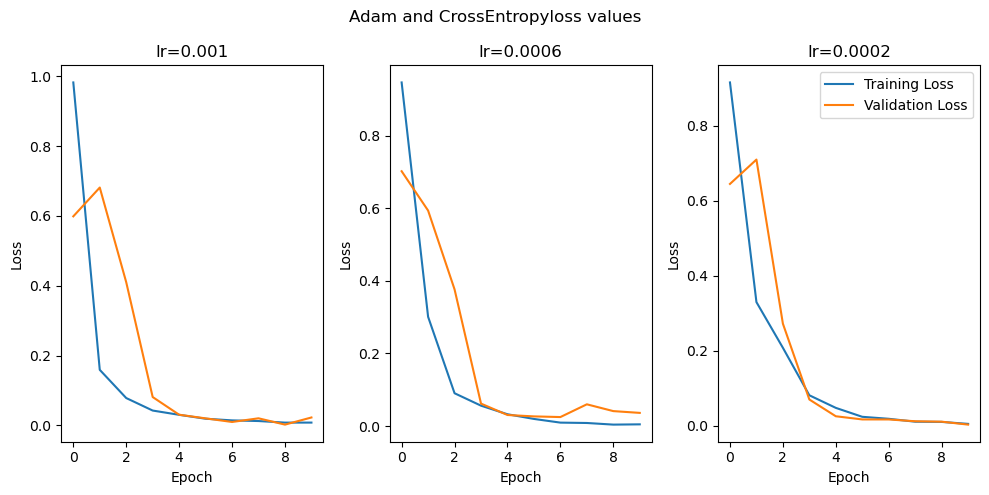

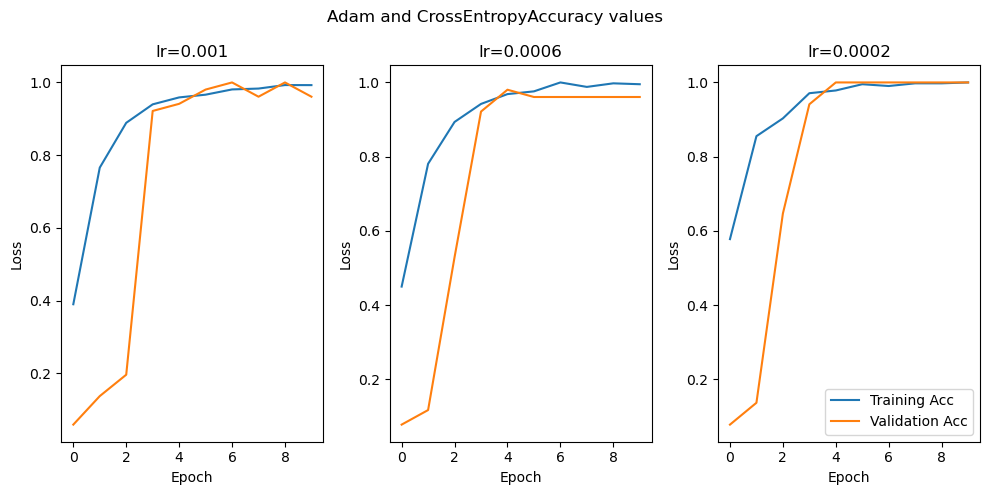

In [111]:
vgg_cw_adam_ce_1, vgg_cw_adam_ce_2, vgg_cw_adam_ce_3 = train_val_model_ev_best_optmizer(VGG, 3, 0, num_classes, X_train, y_train, X_val, y_val, criterion_CrossEntropy_classWeight, 'Adam', 10, 'Adam and CrossEntropy', patience=5, ClassWeights=True, type='CNN', lr=[0.001,0.0006,0.0002])

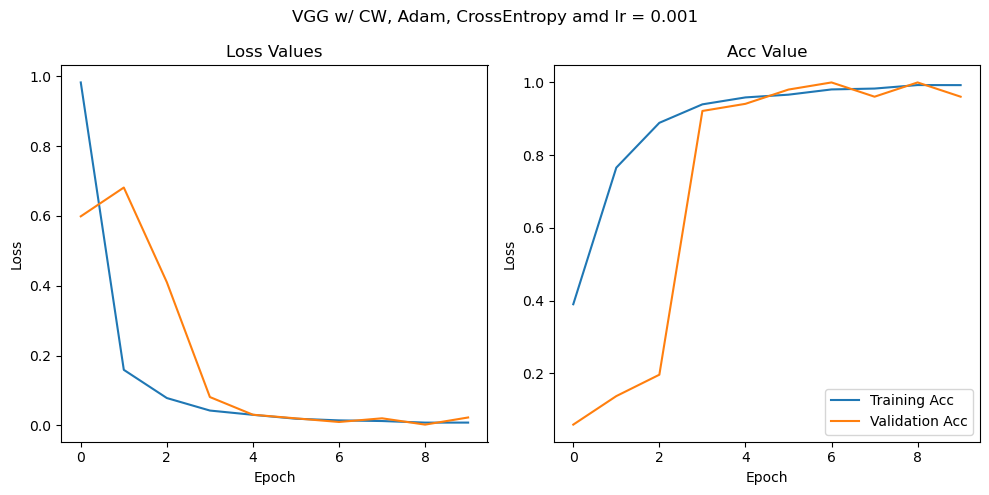

Evaluating with the Training data
Confusion Matrix:
 [[80  0  0  0  0  0  0  0  0]
 [ 0 27  0  0  0  0  0  0  0]
 [ 0  0 75  0  0  0  0  0  0]
 [ 0  0  0 46  1  0  0  0  0]
 [ 0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0  0  0 62]]
F1 Score:  0.9975983931570654
Accuracy:  0.9975845410628019
Precison:  0.9976895610165931
Evaluating with the Validation data
Confusion Matrix:
 [[ 7  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.9607843137254902
Accuracy:  0.9607843137254902
Precison:  0.9803921568627451
Evaluating with the Test data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  6  1  0  0  0  0]
 

In [112]:
# lr = 0.001
evaluate_model(vgg_cw_adam_ce_1,X_train, y_train, X_val, y_val, X_test, y_test, 'VGG w/ CW, Adam, CrossEntropy amd lr = 0.001')

###### **Data Oversampling SGD and CrossEntropy**

SGD and CrossEntropy w/  lr=0.007 w/ m=0.9
Epoch [1/10], Train Loss: 3.8930, Val Loss: 4.0624, Train Acc: 0.4524, Val Acc: 0.1176
Epoch [2/10], Train Loss: 2.1951, Val Loss: 1.6214, Train Acc: 0.2976, Val Acc: 0.4706
Epoch [3/10], Train Loss: 1.9140, Val Loss: 1.3013, Train Acc: 0.2880, Val Acc: 0.5882
Epoch [4/10], Train Loss: 1.8016, Val Loss: 1.2362, Train Acc: 0.3587, Val Acc: 0.5490
Epoch [5/10], Train Loss: 1.7600, Val Loss: 1.3101, Train Acc: 0.3899, Val Acc: 0.5686
Epoch [6/10], Train Loss: 1.6021, Val Loss: 1.0294, Train Acc: 0.3791, Val Acc: 0.6078
Epoch [7/10], Train Loss: 1.5555, Val Loss: 1.0146, Train Acc: 0.4035, Val Acc: 0.6078
Epoch [8/10], Train Loss: 1.5386, Val Loss: 1.1189, Train Acc: 0.4266, Val Acc: 0.5686
Epoch [9/10], Train Loss: 1.5784, Val Loss: 1.0380, Train Acc: 0.3995, Val Acc: 0.5882
Epoch [10/10], Train Loss: 1.4543, Val Loss: 0.8878, Train Acc: 0.4524, Val Acc: 0.6667
SGD and CrossEntropy w/  lr=0.002 w/ m=0.9
Epoch [1/10], Train Loss: 2.3192, Val Loss:

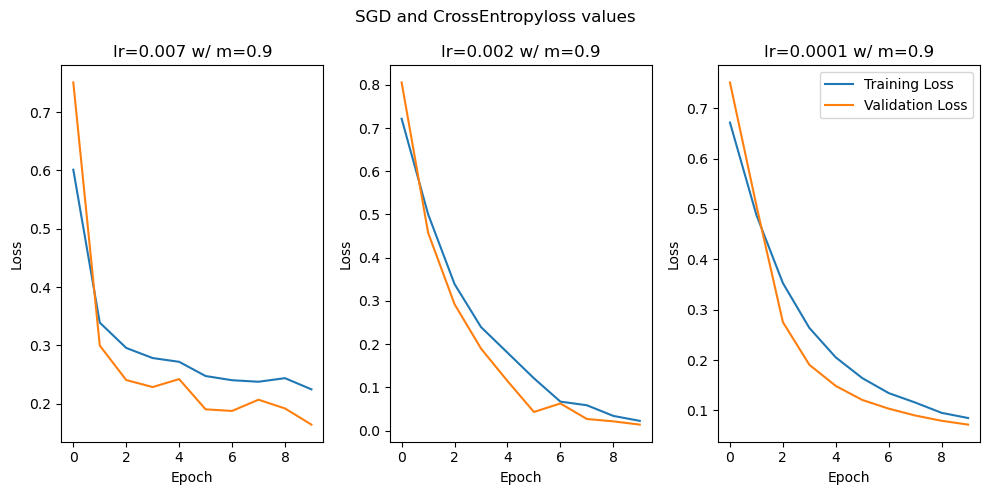

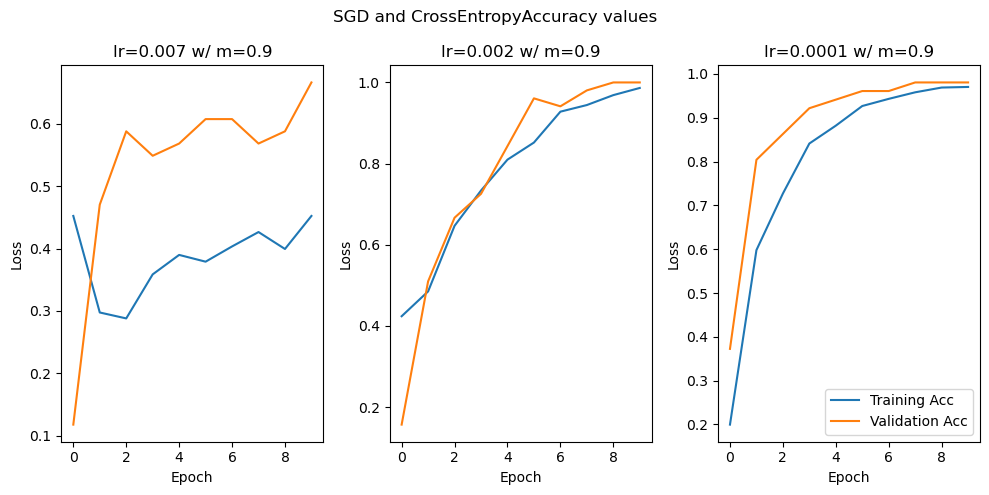

In [119]:
vgg_dos_sgd_ce_1, vgg_dos_sgd_ce_2, vgg_dos_sgd_ce_3 = train_val_model_ev_best_optmizer(VGG, 3, 0, num_classes, X_train_ovs, y_train_ovs, X_val, y_val, criterion_CrossEntropy, 'SGD', 10, 'SGD and CrossEntropy', type='CNN', lr=[0.007,0.002,0.0001])

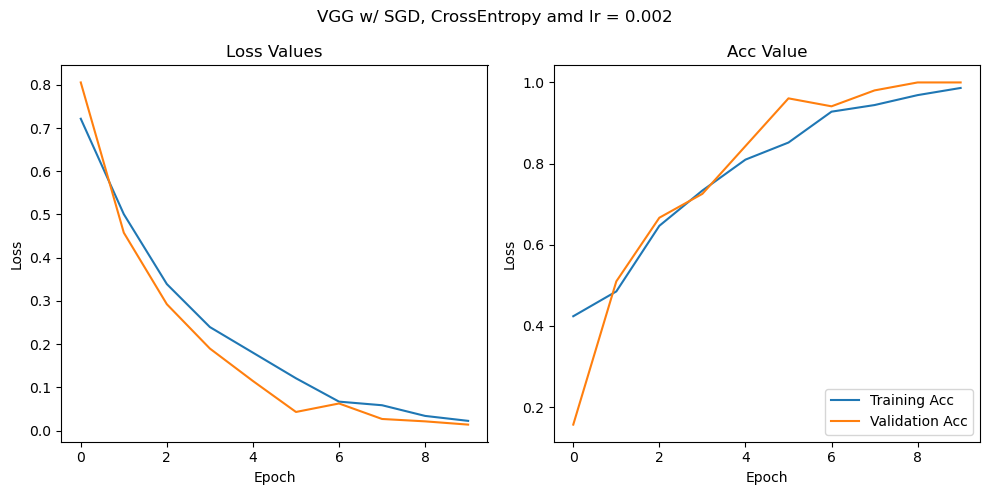

Evaluating with the Training data
Confusion Matrix:
 [[80  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0]
 [ 0  0  0 80  0  0  0  0  0]
 [ 0  0  0  0 80  0  0  0  0]
 [ 0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0  0  0 80]]
F1 Score:  1.0
Accuracy:  1.0
Precison:  1.0
Evaluating with the Validation data
Confusion Matrix:
 [[ 7  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  1.0
Accuracy:  1.0
Precison:  1.0
Evaluating with the Test data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 

In [120]:
# lr = 0.002
evaluate_model(vgg_dos_sgd_ce_2,X_train_ovs, y_train_ovs, X_val, y_val, X_test, y_test, 'VGG w/ SGD, CrossEntropy amd lr = 0.002')

###### **Class Weighting SGD and CrossEntropy**

SGD and CrossEntropy w/  lr=0.01 w/ m=0.9
Epoch [1/20], Train Loss: 344.1490, Val Loss: 26.1348, Train Acc: 0.1619, Val Acc: 0.1765
Epoch [2/20], Train Loss: 24.1551, Val Loss: 15.0451, Train Acc: 0.2631, Val Acc: 0.1765
Epoch [3/20], Train Loss: 23.9520, Val Loss: 2.2882, Train Acc: 0.2923, Val Acc: 0.2745
Epoch [4/20], Train Loss: 22.5300, Val Loss: 2.0015, Train Acc: 0.3306, Val Acc: 0.3725
Epoch [5/20], Train Loss: 23.6503, Val Loss: 1.5550, Train Acc: 0.2546, Val Acc: 0.4902
Epoch [6/20], Train Loss: 20.7826, Val Loss: 1.6292, Train Acc: 0.4296, Val Acc: 0.4706
Epoch [7/20], Train Loss: 18.5567, Val Loss: 0.8290, Train Acc: 0.5194, Val Acc: 0.8039
Epoch [8/20], Train Loss: 14.9401, Val Loss: 0.6644, Train Acc: 0.6902, Val Acc: 0.8235
Epoch [9/20], Train Loss: 11.2915, Val Loss: 0.4597, Train Acc: 0.7301, Val Acc: 0.8824
Epoch [10/20], Train Loss: 12.8785, Val Loss: 0.8260, Train Acc: 0.7582, Val Acc: 0.7451
Epoch [11/20], Train Loss: 11.4624, Val Loss: 0.4444, Train Acc: 0.7220, V

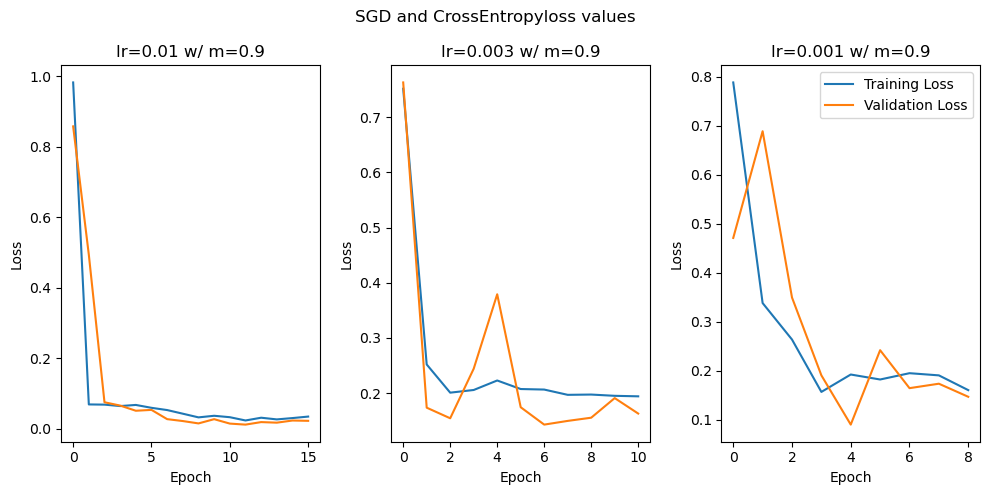

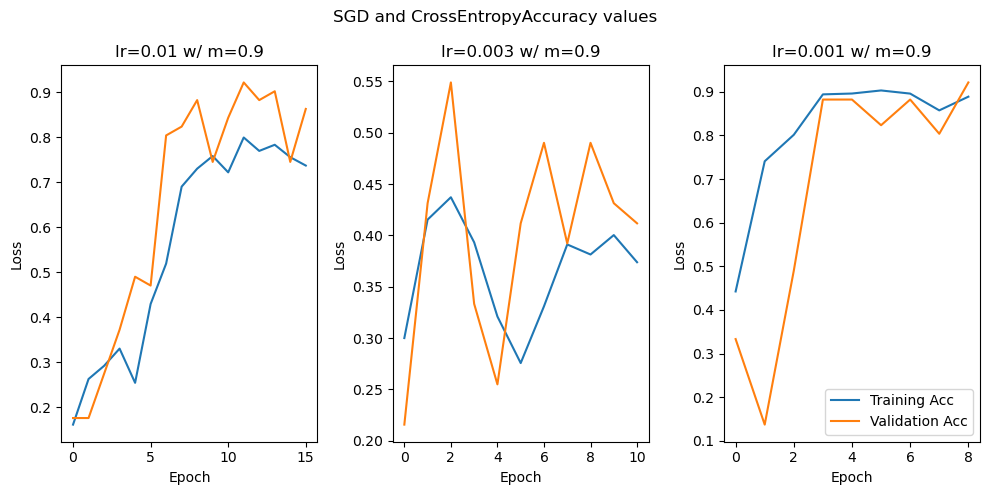

In [57]:
vgg_cw_sgd_ce_1, vgg_cw_sgd_ce_2, vgg_cw_sgd_ce_3 = train_val_model_ev_best_optmizer(VGG, 3, 0, num_classes, X_train, y_train, X_val, y_val, criterion_CrossEntropy_classWeight, 'SGD', 20, 'SGD and CrossEntropy', patience=5, ClassWeights=True, type='CNN', lr=[0.01,0.003, 0.001])

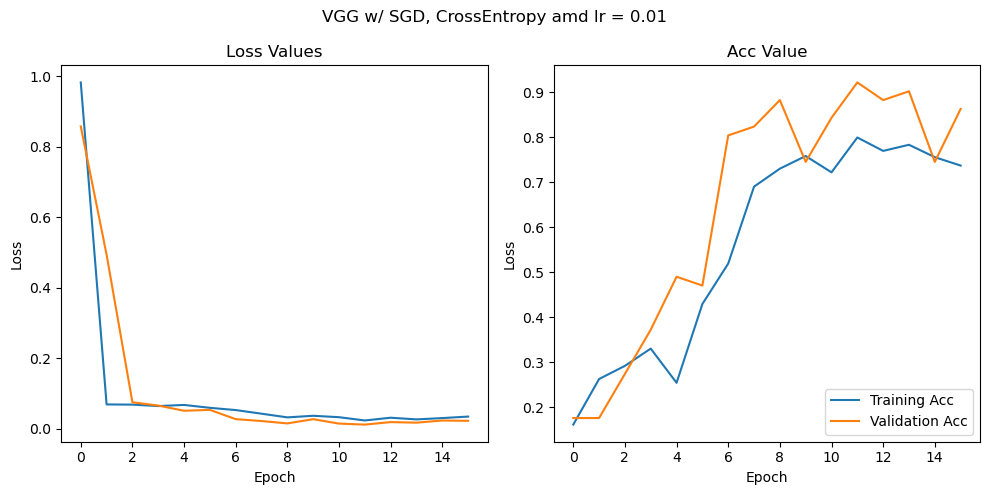

Evaluating with the Training data
Confusion Matrix:
 [[70  0  0  0  7  0  0  0  0]
 [ 3 24  0  0  0  0  0  0  0]
 [ 0  0 78  0  0  0  0  0  0]
 [ 0  3  0 39  5  0  3  0  0]
 [ 0  0  0  0 24  0  0  0  0]
 [ 0  0  0  0  8 16  0  0  0]
 [ 0  0  0  0  2  0 21  0  0]
 [ 0  0  0  0  4  0  0 44  0]
 [ 0  0  0  0 11  0  4  0 48]]
F1 Score:  0.8931897077236087
Accuracy:  0.8792270531400966
Precison:  0.936058549249217
Evaluating with the Validation data
Confusion Matrix:
 [[8 0 0 0 1 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0]
 [0 1 0 4 1 0 0 0 0]
 [0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 3 0 1 0]
 [0 0 0 0 0 0 5 0 0]
 [0 0 0 0 2 0 2 1 0]
 [0 0 0 0 0 0 0 0 9]]
F1 Score:  0.8410666227275223
Accuracy:  0.8431372549019608
Precison:  0.8837535014005602
Evaluating with the Test data
Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0]
 [ 1  6  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  1  0  0]
 [ 0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  2  3  0  1  0]
 [ 0  0  0  0  0  0  2 

In [58]:
# lr = 0.01
evaluate_model(vgg_cw_sgd_ce_1, X_train, y_train, X_val, y_val, X_test, y_test, 'VGG w/ SGD, CrossEntropy amd lr = 0.01')

###### **Plot the results**

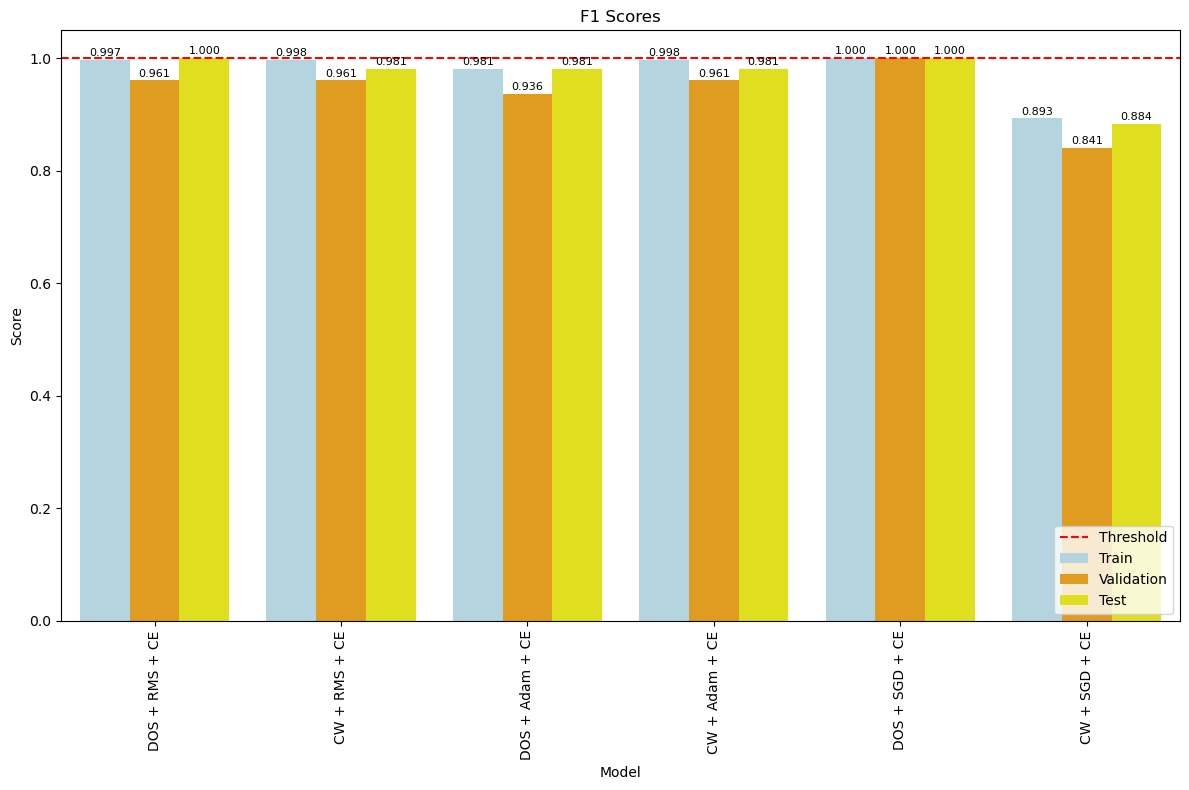

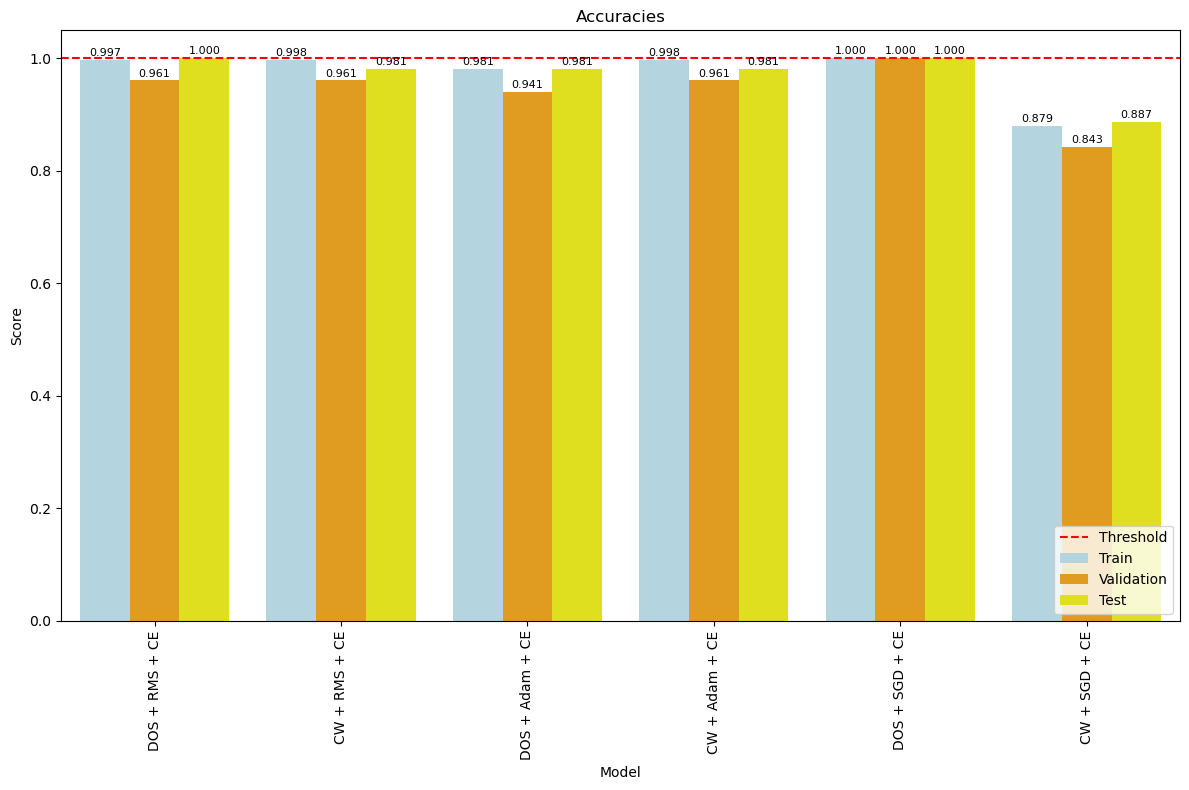

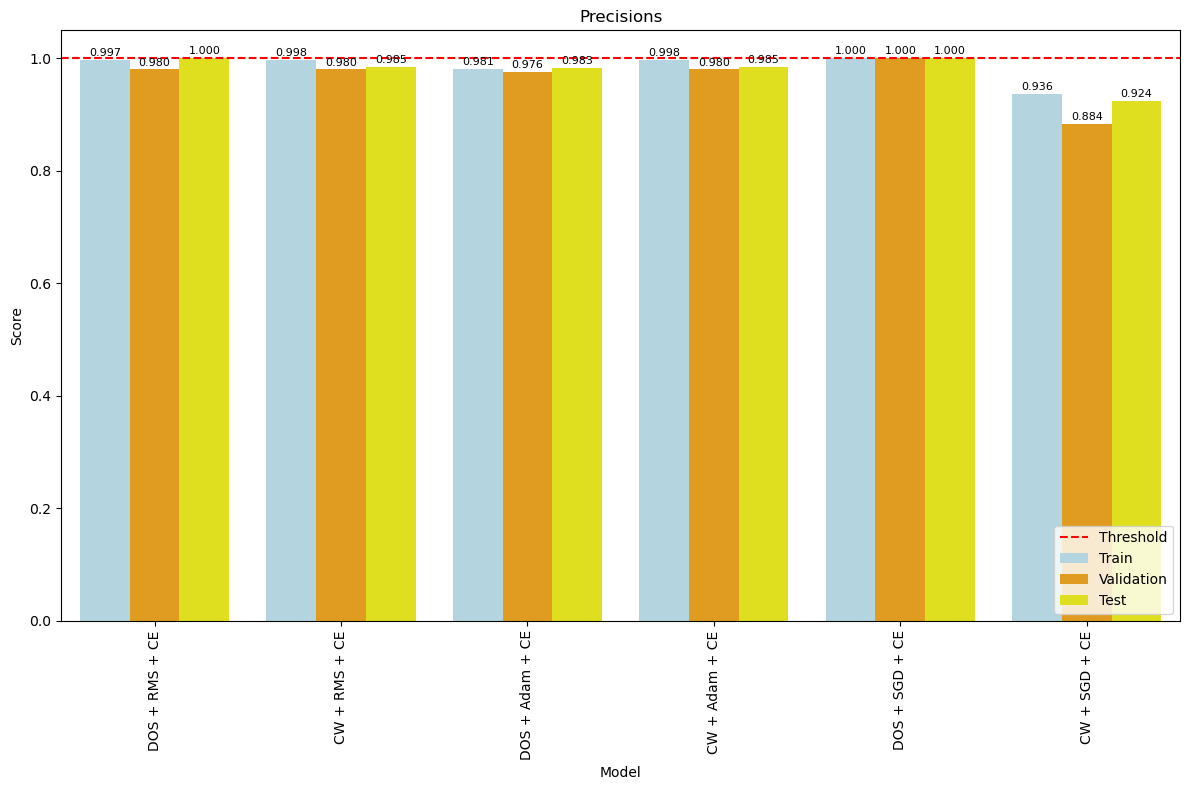

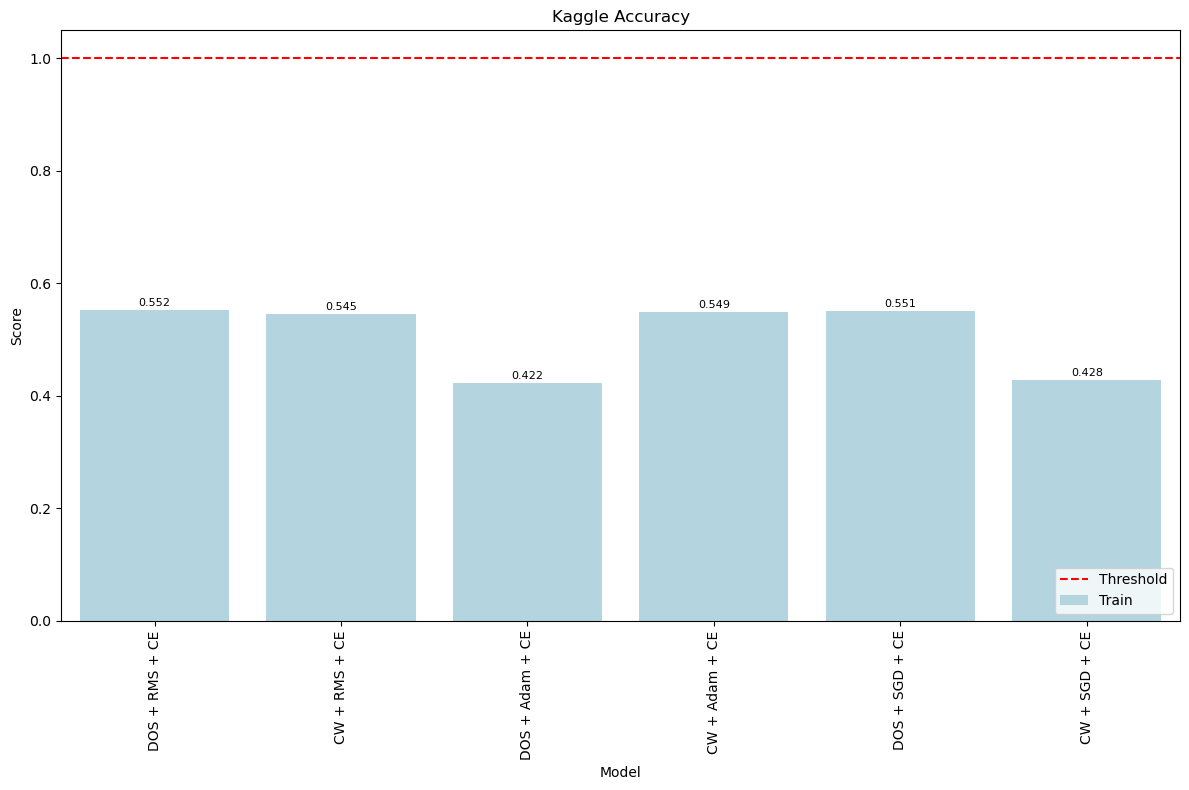

In [61]:
labels = ["DOS + RMS + CE", "CW + RMS + CE", "DOS + Adam + CE", "CW + Adam + CE", "DOS + SGD + CE", "CW + SGD + CE"]
f1_scores_train = [0.9972217881266171, 0.9975983931570654, 0.9807694766643287, 0.9975983931570654, 1.0, 0.8931897077236087]
f1_scores_validation = [0.9607843137254902, 0.9607843137254902, 0.9361344537815127, 0.9607843137254902, 1.0, 0.8410666227275223]
f1_scores_test = [1.0, 0.9814546040961135, 0.9810736608446755, 0.9814546040961135, 1.0, 0.8840329481838916]

accuracy_train = [0.9972222222222222, 0.9975845410628019, 0.9805555555555555, 0.9975845410628019, 1.0, 0.8792270531400966]
accuracy_validation = [0.9607843137254902, 0.9607843137254902, 0.9411764705882353, 0.9607843137254902, 1.0, 0.8431372549019608]
accuracy_test = [1.0, 0.9811320754716981, 0.9811320754716981, 0.9811320754716981, 1.0, 0.8867924528301887]

precision_train = [0.997289972899729, 0.9976895610165931, 0.9814434978046223, 0.9976895610165931, 1.0, 0.936058549249217]
precision_validation = [0.9803921568627451, 0.9803921568627451, 0.9764705882352941, 0.9803921568627451, 1.0, 0.8837535014005602]
precision_test = [1.0, 0.9849056603773585, 0.9830188679245283, 0.9849056603773585, 1.0, 0.9237727681123907]

accuracy_kaggle = [0.55195, 0.54532, 0.42227, 0.54871, 0.55082, 0.42805]

# F1_score Plot
plot_results(labels, f1_scores_train, f1_scores_validation, f1_scores_test, 'F1 Scores')

# Accuracy Plot
plot_results(labels, accuracy_train, accuracy_validation, accuracy_test, 'Accuracies')

# Precision Plot
plot_results(labels, precision_train, precision_validation, precision_test, 'Precisions')

# Kaggle Accuracy Plot
plot_results(labels, accuracy_kaggle, title='Kaggle Accuracy',n_values=1)

###### **Save the results**

In [59]:
save_file(vgg_cw_sgd_ce_1[2], id_kaggle, x_kaggle_1,'vgg_cw_sgd_ce.csv')

##### **iV - GoogLeNet CNN**

###### **Architecture**

In [68]:
class InceptionModule(nn.Module):
    def __init__(self, input_channels=3, num_classes=9):
        super(InceptionModule, self).__init__()
        relu = nn.ReLU()
        self.branch1 = nn.Sequential(
            nn.Conv2d(input_channels, out_channels=num_classes, kernel_size=1, stride=1, padding=0),
            relu)

        conv3_1 = nn.Conv2d(input_channels, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        conv3_3 = nn.Conv2d(num_classes, num_classes, kernel_size=3, stride=1, padding=1)
        self.branch2 = nn.Sequential(conv3_1, conv3_3,relu)

        conv5_1 = nn.Conv2d(input_channels, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        conv5_5 = nn.Conv2d(num_classes, num_classes, kernel_size=5, stride=1, padding=2)
        self.branch3 = nn.Sequential(conv5_1,conv5_5,relu)

        max_pool_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        conv_max_1 = nn.Conv2d(input_channels, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        self.branch4 = nn.Sequential(max_pool_1, conv_max_1,relu)

    def forward(self, input):
        output1 = self.branch1(input)
        output2 = self.branch2(input)
        output3 = self.branch3(input)
        output4 = self.branch4(input)
        return torch.cat([output1, output2, output3, output4], dim=1)

In [ ]:
# Source: https://theaisummer.com/cnn-architectures/

###### **Data Oversampling RMSprop and CrossEntropy**

In [69]:
googleLeNet_dos_rms_ce_1, googleLeNet_dos_rms_ce_2, googleLeNet_dos_rms_ce_3 = train_val_model_ev_best_optmizer(InceptionModule, 3, 0, num_classes, X_train_ovs, y_train_ovs, X_val, y_val, criterion_CrossEntropy, 'RMSprop', 10, 'RMSprop and CrossEntropy', patience=5, type='CNN', lr=[0.001,0.0001,0.00001])

RMSprop and CrossEntropy w/  lr=0.001


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1